# TMDB Box Office Prediction

In this competition we need to predict overall worldwide box office revenue for movies.

My main goal is to conduct exploratory data analysis (EDA) of dataset and answer to below questions:
- What movies makes the most money at the box office?
- How much does a director matter?
- How much does the budget matter?

Before we will dive into code you need to know a little bit about me, so you will know what to expect. I am new to data science and before this kernel I only tried to predict survivals of the Titanic, prices of houses and digit recognition (MNIST). As you see I do not have much experience, so if you have any suggestions or find mistakes let me know.

Moreover I am not a native English speaker so you need to expect some mistakes.

# EDA

In [1]:
# Import libraries
import pandas as pd
import numpy as np

import seaborn as sns
import matplotlib.pyplot as plt
import matplotlib.ticker as ticker
%matplotlib inline

import json
import ast

from wordcloud import WordCloud, STOPWORDS
import nltk
from nltk.probability import FreqDist

from collections import Counter

import plotly.graph_objs as go
from plotly.offline import init_notebook_mode, iplot

init_notebook_mode(connected=True)

In [2]:
# Load train and test data
train = pd.read_csv('./data/train.csv')
test = pd.read_csv('./data/test.csv')

# Print shape of train and test data
print('Train data shape: ', train.shape)
print('Test data shape: ', test.shape)

Train data shape:  (3000, 23)
Test data shape:  (4398, 22)


There are 3000 movies in train data and 4398 movies in test data. Both sets have 22 features (train have +1 because of box office revenue).

In [3]:
# Lets inspect some sample rows from train data
train.sample(3)

# Lots of features are dictionaries so we will need to take closer look to them.
# Some features like homepage cound be binarized.

id belongs_to_collection  budget  \
2894  2895                   NaN       0   
2684  2685                   NaN       0   
588    589                   NaN   90000   

                                                 genres homepage    imdb_id  \
2894  [{'id': 35, 'name': 'Comedy'}, {'id': 18, 'nam...      NaN  tt0113448   
2684  [{'id': 28, 'name': 'Action'}, {'id': 80, 'nam...      NaN  tt0083190   
588   [{'id': 27, 'name': 'Horror'}, {'id': 53, 'nam...      NaN  tt0051885   

     original_language original_title  \
2894                en   Jack & Sarah   
2684                en          Thief   
588                 en        Macabre   

                                               overview  popularity  ...  \
2894  Jack always lands on his feet. He lands on his...    1.523446  ...   
2684  Frank is an expert professional safecracker, s...   10.480229  ...   
588   A doctor's daughter is kidnapped and buried al...    0.837849  ...   

     release_date runtime                          spoken_languages    status  \
2894       6/2/95   110.0  [{'iso_639_1': 'en', 'name': 'English'}]  Released   
2684      3/27/81   122.0  [{'iso_639_1': 'en', 'name': 'English'}]  Released   
588       10/1/58    72.0  [{'iso_639_1': 'en', 'name': 'English'}]  Released   

                                                tagline         title  \
2894  She's not proper, she's not fitting, she's not...  Jack & Sarah   
2684  Tonight, his take home pay is $410,000... tax ...         Thief   
588            As Blood-Chilling As Being Buried Alive!       Macabre   

                                               Keywords  \
2894  [{'id': 212, 'name': 'london england'}, {'id':...   
2684  [{'id': 520, 'name': 'chicago'}, {'id': 1437, ...   
588   [{'id': 428, 'name': 'nurse'}, {'id': 456, 'na...   

                                                   cast  \
2894  [{'cast_id': 1, 'character': 'Jack', 'credit_i...   
2684  [{'cast_id': 1, 'character': 'Frank', 'credit_...   
588   [{'cast_id': 5, 'character': 'Dr. Rodney Barre...   

                                                   crew  revenue  
2894  [{'credit_id': '52fe432dc3a36847f80402df', 'de...   218626  
2684  [{'credit_id': '52fe44529251416c75030985', 'de...  4300000  
588   [{'credit_id': '590f036ac3a36864fc01e215', 'de...  5000000  

[3 rows x 23 columns]

In [4]:
# Describe train data
train.describe()

id        budget   popularity      runtime       revenue
count  3000.000000  3.000000e+03  3000.000000  2998.000000  3.000000e+03
mean   1500.500000  2.253133e+07     8.463274   107.856571  6.672585e+07
std     866.169729  3.702609e+07    12.104000    22.086434  1.375323e+08
min       1.000000  0.000000e+00     0.000001     0.000000  1.000000e+00
25%     750.750000  0.000000e+00     4.018053    94.000000  2.379808e+06
50%    1500.500000  8.000000e+06     7.374861   104.000000  1.680707e+07
75%    2250.250000  2.900000e+07    10.890983   118.000000  6.891920e+07
max    3000.000000  3.800000e+08   294.337037   338.000000  1.519558e+09

In [5]:
# Inspect test data
test.sample(3)

id belongs_to_collection  budget  \
934   3935                   NaN     500   
441   3442                   NaN       0   
4216  7217                   NaN       0   

                                                 genres homepage    imdb_id  \
934   [{'id': 35, 'name': 'Comedy'}, {'id': 18, 'nam...      NaN  tt0361322   
441   [{'id': 35, 'name': 'Comedy'}, {'id': 18, 'nam...      NaN  tt0119054   
4216  [{'id': 10749, 'name': 'Romance'}, {'id': 14, ...      NaN  tt0342882   

     original_language                  original_title  \
934                 en                 Assisted Living   
441                 en               Eight Days a Week   
4216                en  The Piano Tuner of Earthquakes   

                                               overview  popularity  ...  \
934   "Assisted Living" chronicles a day in the life...    0.261278  ...   
441   Peter loves his next door neighbour Erica and,...    4.515523  ...   
4216  Dark fairytale about a demonic doctor who abdu...    2.933613  ...   

                                   production_countries release_date runtime  \
934   [{'iso_3166_1': 'US', 'name': 'United States o...       2/2/05    78.0   
441   [{'iso_3166_1': 'US', 'name': 'United States o...      1/17/97    92.0   
4216  [{'iso_3166_1': 'FR', 'name': 'France'}, {'iso...       9/9/05    99.0   

                                       spoken_languages    status  \
934            [{'iso_639_1': 'en', 'name': 'English'}]  Released   
441            [{'iso_639_1': 'en', 'name': 'English'}]  Released   
4216  [{'iso_639_1': 'en', 'name': 'English'}, {'iso...  Released   

                             tagline                           title  \
934                              NaN                 Assisted Living   
441   He Came. He Sat. He Conquered.               Eight Days a Week   
4216                             NaN  The Piano Tuner of Earthquakes   

                                               Keywords  \
934   [{'id': 4992, 'name': 'senility'}, {'id': 1180...   
441   [{'id': 293, 'name': 'female nudity'}, {'id': ...   
4216  [{'id': 554, 'name': 'manager'}, {'id': 1436, ...   

                                                   cast  \
934   [{'cast_id': 1, 'character': 'Todd', 'credit_i...   
441   [{'cast_id': 4, 'character': 'Peter', 'credit_...   
4216  [{'cast_id': 3, 'character': 'Malvina van Stil...   

                                                   crew  
934   [{'credit_id': '52fe4cd59251416c91101b31', 'de...  
441   [{'credit_id': '52fe46449251416c75072c79', 'de...  
4216  [{'credit_id': '52fe468bc3a36847f8104d4f', 'de...  

[3 rows x 22 columns]

In [6]:
# Check missing data
pd.concat([train.isnull().sum(), test.isnull().sum()], keys=['train','test'], axis=1, sort=False)

train    test
id                         0     0.0
belongs_to_collection   2396  3521.0
budget                     0     0.0
genres                     7    16.0
homepage                2054  2978.0
imdb_id                    0     0.0
original_language          0     0.0
original_title             0     0.0
overview                   8    14.0
popularity                 0     0.0
poster_path                1     1.0
production_companies     156   258.0
production_countries      55   102.0
release_date               0     1.0
runtime                    2     4.0
spoken_languages          20    42.0
status                     0     2.0
tagline                  597   863.0
title                      0     3.0
Keywords                 276   393.0
cast                      13    13.0
crew                      16    22.0
revenue                    0     NaN

I will go through all features keeping the order form above table and try to analyze the data.

In [7]:
# How many missing values have feature in train and test set.
def how_many_missing_values(feature):
    print('Missing {} in train set: {}/{} ({}%)'.format(feature,
                                                        train[feature].isnull().sum(), 
                                                        train[feature].size,
                                                        train[feature].isnull().sum()/train[feature].size))

    print('Missing {} in test set: {}/{} ({}%)'.format(feature,
                                                       test[feature].isnull().sum(), 
                                                       test[feature].size,
                                                       test[feature].isnull().sum()/test[feature].size))

## id

Just the id of the movie. Starts from number 1. Feature not important and can be deleted.

In [8]:
# Remove id feature
#train.drop(labels=['id'], axis=1, inplace=True)
#test.drop(labels=['id'], axis=1, inplace=True)

## belongs_to_collection

This feature represents if a movie belongs to a series of movies. For example James Bond Collection.

In [9]:
# Count uniqe values for belongs_to_collection
train['belongs_to_collection'].value_counts().head(10)

[{'id': 645, 'name': 'James Bond Collection', 'poster_path': '/HORpg5CSkmeQlAolx3bKMrKgfi.jpg', 'backdrop_path': '/6VcVl48kNKvdXOZfJPdarlUGOsk.jpg'}]                      16
[{'id': 9735, 'name': 'Friday the 13th Collection', 'poster_path': '/uobgqpLQff9WvxGKE2OSvXv1RHm.jpg', 'backdrop_path': '/c7pMKwv5NzIN6N3KM4L8fYMTtPw.jpg'}]                7
[{'id': 937, 'name': 'The Pink Panther (Original) Collection', 'poster_path': '/xu6gZ0zGUSR8SC2QLKFaUrX2niM.jpg', 'backdrop_path': '/6KE7AguGR3UqwUn5RkzkoBc3MLy.jpg'}]     6
[{'id': 9338, 'name': 'Police Academy Collection', 'poster_path': '/1VRdXVy2FYlX4EtllnLKWK6kYDJ.jpg', 'backdrop_path': '/RhpI828r9EKPV4x0pyHiqCDZDQ.jpg'}]                  5
[{'id': 34055, 'name': 'Pokémon Collection', 'poster_path': '/j5te0YNZAMXDBnsqTUDKIBEt8iu.jpg', 'backdrop_path': '/iGoYKA0TFfgSoZpG2u5viTJMGfK.jpg'}]                       5
[{'id': 41437, 'name': 'Paranormal Activity Collection', 'poster_path': '/lYXAMmm9XlYmj5Dr4O9diLQVCJS.jpg', 'backdrop_path': '/hZM

In [10]:
# Get the collection name
def get_collection_name(dataset):
    return dataset['belongs_to_collection'].fillna(0).apply(lambda x: eval(x)[0]['name'] if x != 0 else 0)

# Check if movie belongs to collection
def is_belonging_to_collection(dataset):
    return dataset['belongs_to_collection'].fillna(0).apply(lambda x: 1 if x != 0 else 0)

# New feature collection name
train['collection_name'] = get_collection_name(train)
test['collection_name'] = get_collection_name(test)

# Change belongs_to_collection to bool
train['belongs_to_collection'] = is_belonging_to_collection(train)
test['belongs_to_collection'] = is_belonging_to_collection(test)

**How many movies belongs to collection?**

0    2396
1     604
Name: belongs_to_collection, dtype: int64

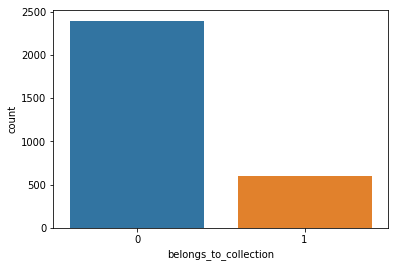

In [11]:
sns.countplot(train['belongs_to_collection'])
train['belongs_to_collection'].value_counts()

There are 604 movies that belongs to collection.

**How many movies are in each collection?**

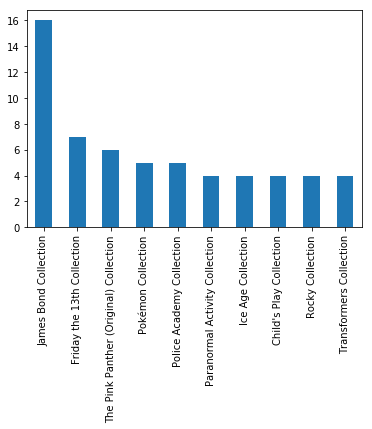

In [12]:
# train['collection_name'].value_counts()
train[train['belongs_to_collection'] == 1]['collection_name'].value_counts().head(10).plot(kind='bar')

We can see top 10 biggest collections. Not suprisingly 'James Bond Collection' is in the first place.

**Will movie make more money on box office if belongs to collection?**

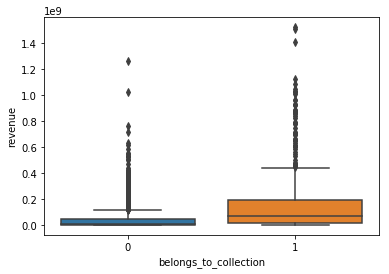

In [13]:
sns.boxplot(x='belongs_to_collection', y='revenue', data=train)

As we can see, if a movie belongs to collection, then it have greater chances of bigger box office revenue.

**Which collection had the biggest revenue?**

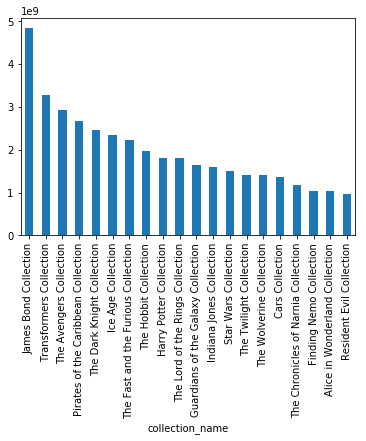

In [14]:
(train[train['belongs_to_collection'] == 1].groupby('collection_name')['revenue']
 .agg('sum').sort_values(ascending=False).head(20).plot(kind='bar'))

One could suspect that James Bond Collection will have number one spot. But when you closely look at the plot you will see that it did not reflect the true revenue, because some collections (like James Bond) have many movies and other (like Finding Nemo Collection) only couple. 

So which collection really had the biggest revenue?

Lets plot collections revenue with the selection of individual films.

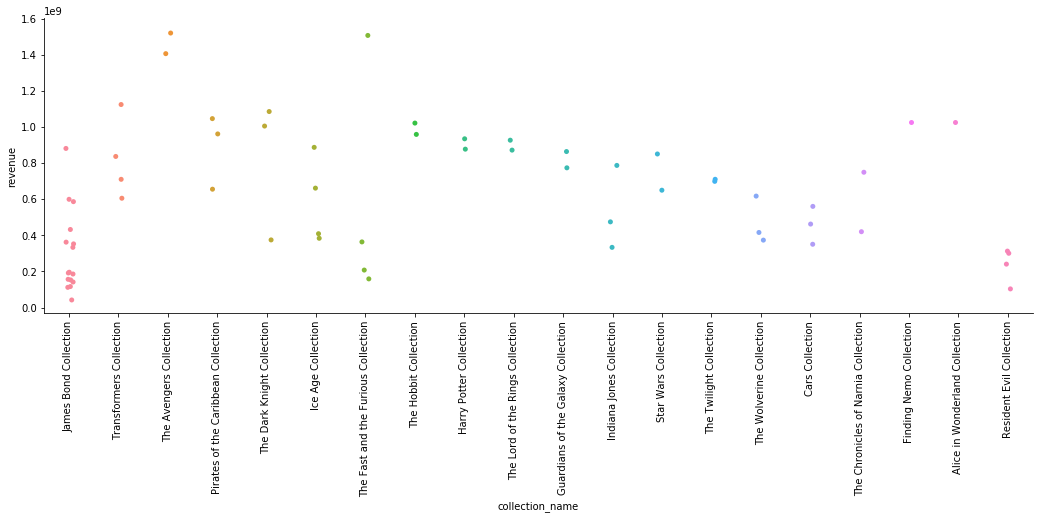

In [15]:
g = sns.catplot(x='collection_name', y='revenue', data=train[train['belongs_to_collection'] == 1],
                order=train[train['belongs_to_collection'] == 1].groupby('collection_name')['revenue']
                .agg('sum').sort_values(ascending=False).head(20).index, aspect=3)
g.set_xticklabels(rotation=90)

Now it is much more clear that some collections with only couple of movies had much more bigger revenue per movie.

**Which collection made the most money per movie?**

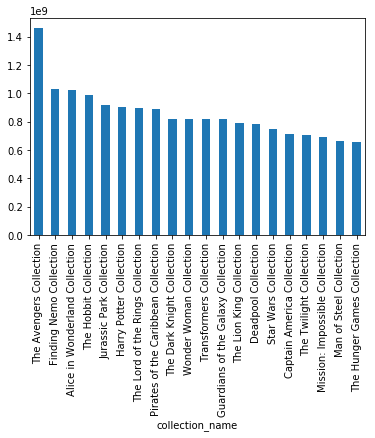

In [16]:
(train[train['belongs_to_collection'] == 1].groupby('collection_name')['revenue']
 .agg('mean').sort_values(ascending=False).head(20).plot(kind='bar'))

As I mention before some collections had big revenue because had multiple movies. In case of revenue per movie in collection it all looks differently. 

What can't be surprise that almost all movies are from last two decades. This is because of inflation (changes in prices of currency). I wonder where James Bond Collection would be if price of currency would be the same in all past years. 

## budget

Budget of a movie.

**Which movies had the biggest budget?**

In [17]:
train[['title','budget']].sort_values(by='budget',ascending=False).head(10)

title     budget
2135  Pirates of the Caribbean: On Stranger Tides  380000000
2209     Pirates of the Caribbean: At World's End  300000000
2770                      Avengers: Age of Ultron  280000000
1425                             Superman Returns  270000000
1270                                  John Carter  260000000
1630                Transformers: The Last Knight  260000000
2532            The Hobbit: An Unexpected Journey  250000000
961        Harry Potter and the Half-Blood Prince  250000000
906                         The Dark Knight Rises  250000000
666           The Hobbit: The Desolation of Smaug  250000000

**How the budget affects revenue?**

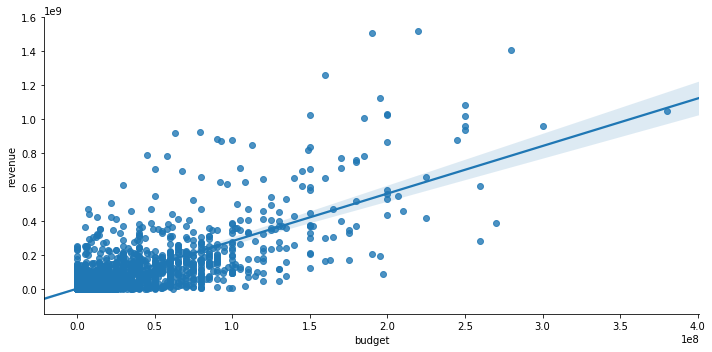

In [18]:
sns.lmplot(x='budget', y='revenue', data=train, height=5, aspect=2)

The bigger the budget the higher the revenue (in general).

**Did movies from collection had bigger budget?**

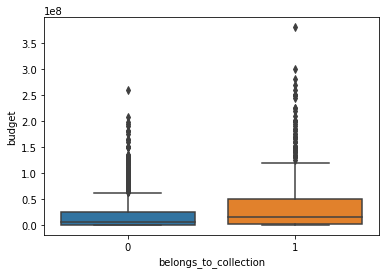

In [19]:
sns.boxplot(x='belongs_to_collection', y='budget', data=train)

If a movie belongs to a collection, then it probably has bigger budget.

To really see if budget matters the most in box office revenue, we need to see what ratio between budget and revenue movies have. Also, I will create feature representing profit of the movie.

In [20]:
# Create new features for ratio and profit
train = train.assign(ratio = lambda df: df['revenue']/df['budget'])
train = train.assign(profit = lambda df: df['revenue']-df['budget'])

In data there are movies with budget equal to 0, which probably means that budget is unknown. I won't be using those movies in analysis below.

In [21]:
# Get Top 10 movies with biggest revenue/budget ratio.
train[train['budget'] > 0][['title','budget','revenue','ratio','profit']].sort_values(by='ratio', ascending=False).head(10)

title  budget    revenue         ratio  \
849                      Modern Times       1    8500000  8.500000e+06   
796             Welcome to Dongmakgol       8   33579813  4.197477e+06   
469           The Karate Kid, Part II     113  115103979  1.018619e+06   
2695                        Nurse 3-D      10   10000000  1.000000e+06   
512                From Prada to Nada      93    2500000  2.688172e+04   
1230              Paranormal Activity   15000  193355800  1.289039e+04   
1679          The Blair Witch Project   60000  248000000  4.133333e+03   
2610  The Tiger: An Old Hunter's Tale    5000   11083449  2.216690e+03   
1893                   Pink Flamingos   12000    6000000  5.000000e+02   
817         The Legend of Boggy Creek  100000   22000000  2.200000e+02   

         profit  
849     8499999  
796    33579805  
469   115103866  
2695    9999990  
512     2499907  
1230  193340800  
1679  247940000  
2610   11078449  
1893    5988000  
817    21900000

Low budget for those movies probably indicate corrupted data. For the Top 5 movies data is definitely corrupted.

Let see how ratio looks like for movies with top budget.

In [22]:
# Get Top 10 movies with the biggest budget
train[['title','budget','revenue','ratio','profit']].sort_values(by='budget', ascending=False).head(10)

title     budget     revenue  \
2135  Pirates of the Caribbean: On Stranger Tides  380000000  1045713802   
2209     Pirates of the Caribbean: At World's End  300000000   961000000   
2770                      Avengers: Age of Ultron  280000000  1405403694   
1425                             Superman Returns  270000000   391081192   
1270                                  John Carter  260000000   284139100   
1630                Transformers: The Last Knight  260000000   604942143   
2532            The Hobbit: An Unexpected Journey  250000000  1021103568   
961        Harry Potter and the Half-Blood Prince  250000000   933959197   
906                         The Dark Knight Rises  250000000  1084939099   
666           The Hobbit: The Desolation of Smaug  250000000   958400000   

         ratio      profit  
2135  2.751878   665713802  
2209  3.203333   661000000  
2770  5.019299  1125403694  
1425  1.448449   121081192  
1270  1.092843    24139100  
1630  2.326701   344942143  
2532  4.084414   771103568  
961   3.735837   683959197  
906   4.339756   834939099  
666   3.833600   708400000

Looking at this data we can see that some movies with top budget didn't bring big profit.

**Which movie had the biggest profit?**

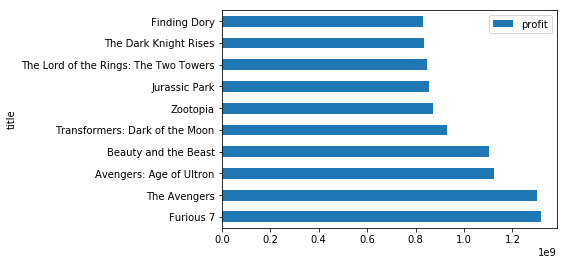

In [23]:
# Plot movies with the biggest profit
train.sort_values(by='profit', ascending=False).head(10).plot(x='title', y='profit', kind='barh')

It is worth mention Jurassic Park on the list because it was released in 1993. Respect.

**How many movies made profit?**

True     2337
False     663
Name: made_profit, dtype: int64

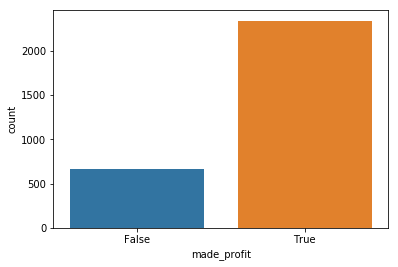

In [24]:
# Get movies that made profit
train['made_profit'] = train['profit'] > 0
sns.countplot(x='made_profit', data=train)
train['made_profit'].value_counts()

Most movies made profit. If this wouldn't be the case movies wouldn't be popular and the number of movies released every year would be low.

## genres

What genre the film belongs to.

List of dictionaries (id of genre, genre name).

In [25]:
# Show top five rows
train['genres'].head(5)

0                       [{'id': 35, 'name': 'Comedy'}]
1    [{'id': 35, 'name': 'Comedy'}, {'id': 18, 'nam...
2                        [{'id': 18, 'name': 'Drama'}]
3    [{'id': 53, 'name': 'Thriller'}, {'id': 18, 'n...
4    [{'id': 28, 'name': 'Action'}, {'id': 53, 'nam...
Name: genres, dtype: object

In [26]:
# Parse json data
def parse_json(x):
    try: return json.loads(x.replace("'", '"'))
    except: return ''
    
# Parse genres
train['genres'] = train['genres'].apply(parse_json)

**How many genres movies have?**

Mean:  2.5036666666666667


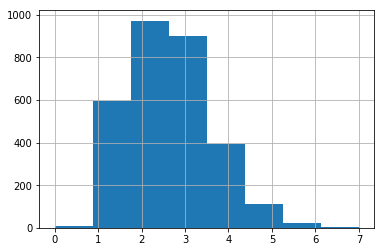

In [27]:
# Get number of genres for movies
train['genres'].apply(len).hist(bins=8)
print('Mean: ', train['genres'].apply(len).mean())

Average movie has 2-3 genres, but there are some exaples of films with more categories. For example movies with 7 genres. 
Also there are some movies with 0 genres which means that data is missing.

In [28]:
# Get the number of genres as a new feature
train['number_of_genres'] = train['genres'].apply(len)

**How number of genres affects budget, revenue and profit?**

In [29]:
# Get budget, revenue, profit data for movies based on number of genres
(train.groupby('number_of_genres')[['budget','revenue','profit']].agg(['mean','median','count'])
 .sort_values(by=('profit','mean'), ascending=False))

budget                       revenue              \
                          mean    median count          mean      median   
number_of_genres                                                           
4                 3.674839e+07  20000000   393  1.066105e+08  32710894.0   
3                 2.969107e+07  12000000   900  8.888497e+07  22797209.5   
6                 4.104762e+07  40000000    21  9.233659e+07  48093211.0   
5                 3.308109e+07  15000000   111  8.258928e+07  36754634.0   
7                 1.700000e+07  14000000     3  4.736216e+07  61141030.0   
2                 1.503906e+07   5000000   972  4.475659e+07  11198569.5   
1                 1.217733e+07   3000000   593  3.966845e+07   8533973.0   
0                 8.285714e+05    400000     7  1.110844e+06    486937.0   

                              profit                    
                 count          mean      median count  
number_of_genres                                        
4                  393  6.986214e+07  14000000.0   393  
3                  900  5.919391e+07   8608927.0   900  
6                   21  5.128897e+07  21890845.0    21  
5                  111  4.950819e+07  12881056.0   111  
7                    3  3.036216e+07  49141030.0     3  
2                  972  2.971753e+07   3991998.5   972  
1                  593  2.749112e+07   3124130.0   593  
0                    7  2.822723e+05    123182.0     7

Movies with four genres had the highest revenue and profit. Movies with six genres had secend best result in revenue, but based on profit they are on third position. In case of movies with three genres their revenue is number three in chart, but they had a bigger profit, so their final position is number two.

The rest of the movies are in correct places based on both mean revenue and mean profit.

Conclusion: it is worth to get top 4 genres as new features.

In [30]:
# Get top 4 genres
def top_genres(genres):
    if len(genres) == 1:
        return pd.Series([genres[0]['name'], '', '', ''], 
                         index=['genre1', 'genre2', 'genre3', 'genre4'])
    if len(genres) == 2:
        return pd.Series([genres[0]['name'], genres[1]['name'], '', ''], 
                         index=['genre1', 'genre2', 'genre3', 'genre4'])
    if len(genres) == 3:
        return pd.Series([genres[0]['name'], genres[1]['name'], genres[2]['name'], ''], 
                         index=['genre1', 'genre2', 'genre3', 'genre4'])
    if len(genres) > 3:
        return pd.Series([genres[0]['name'], genres[1]['name'], genres[2]['name'], genres[3]['name']], 
                         index=['genre1', 'genre2', 'genre3', 'genre4'])
    return pd.Series(['','','',''], index=['genre1','genre2','genre3','genre4'])

train[['genre1', 'genre2', 'genre3', 'genre4']] = train['genres'].apply(top_genres)

**Which genre is most popular?**

In [31]:
genres_df = pd.concat([train['genre1'].value_counts(), train['genre2'].value_counts(), 
                       train['genre3'].value_counts(), train['genre4'].value_counts()], 
                      axis=1, sort=False)
genres_df['sum'] = genres_df.sum(axis=1)

# Show genres data
genres_df

genre1  genre2  genre3  genre4     sum
Drama               785   521.0   190.0    28.0  1524.0
Comedy              604   298.0   103.0    19.0  1024.0
Action              520   155.0    56.0     8.0   739.0
Adventure           187   174.0    53.0    19.0   433.0
Horror              170    84.0    36.0     8.0   298.0
Crime               147   167.0   108.0    41.0   463.0
Thriller            116   239.0   254.0   142.0   751.0
Animation            76    46.0    16.0     3.0   141.0
Documentary          71    15.0     1.0     NaN    87.0
Fantasy              68    78.0    55.0    21.0   222.0
Romance              67   237.0   189.0    54.0   547.0
Science Fiction      41    67.0   109.0    53.0   270.0
Family               36    93.0    79.0    37.0   245.0
Mystery              33    66.0    79.0    36.0   214.0
Music                20    48.0    20.0     8.0    96.0
War                  20    27.0    28.0    19.0    94.0
History              16    60.0    36.0    19.0   131.0
Western              13    10.0     8.0     8.0    39.0
                      7   600.0  1572.0  2472.0  4651.0
Foreign               2    15.0     8.0     5.0    30.0
TV Movie              1     NaN     NaN     NaN     1.0

**Which genre is the most popular from all fourth first genres of a movie (excluding missing genre)?**

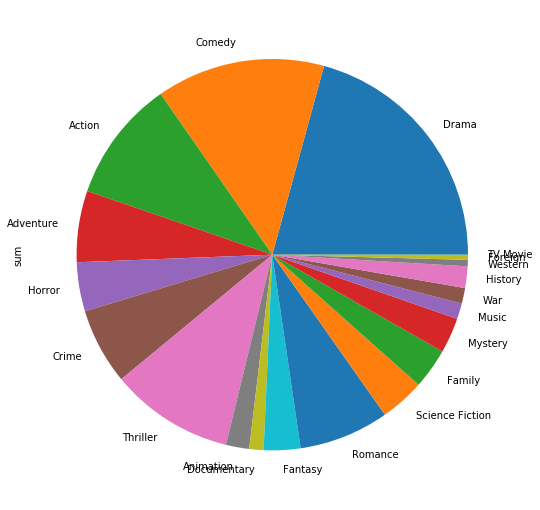

In [32]:
genres_df[~genres_df.index.isin([''])]['sum'].plot(kind='pie', figsize=(9,9))

**Which genre is the most popular based on its position (excluding missing genre)?**

array([[<matplotlib.axes._subplots.AxesSubplot object at 0x000000001832D9E8>,
      dtype=object)

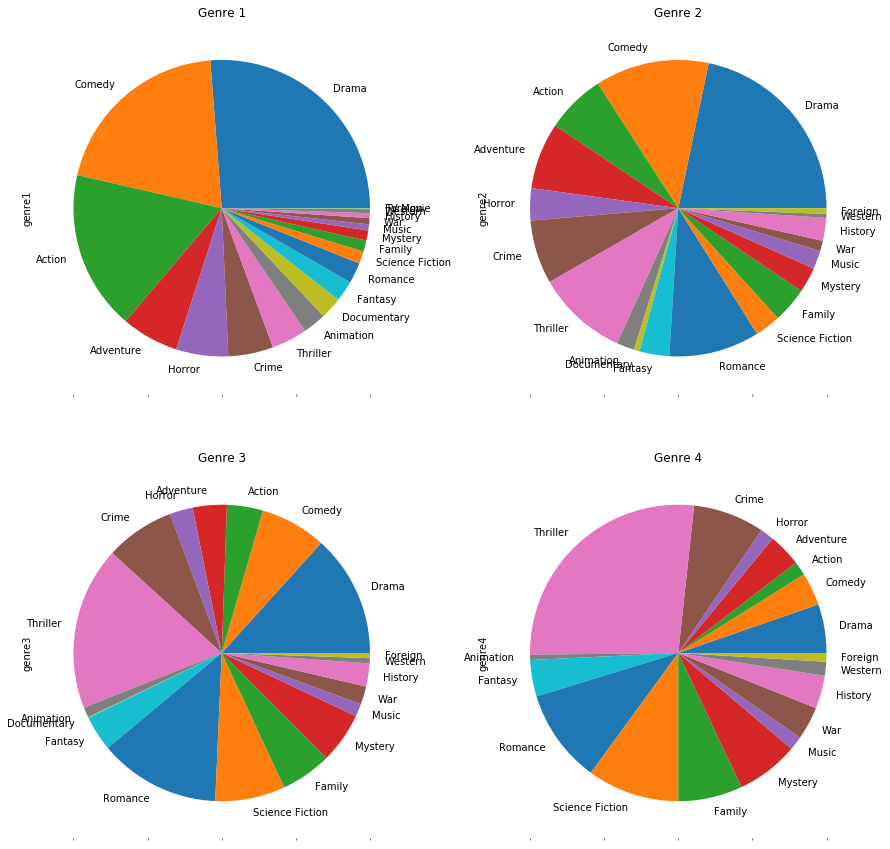

In [33]:
genres_df[~genres_df.index.isin([''])][['genre1','genre2','genre3','genre4']].plot(kind='pie', subplots='True', 
                                                                                   figsize=(15,15), layout=(2,2), 
                                                                                   legend=False, 
                                                                                   title=['Genre 1','Genre 2',
                                                                                          'Genre 3','Genre 4'])

**How first choice genre (genre1) affects revenue?**

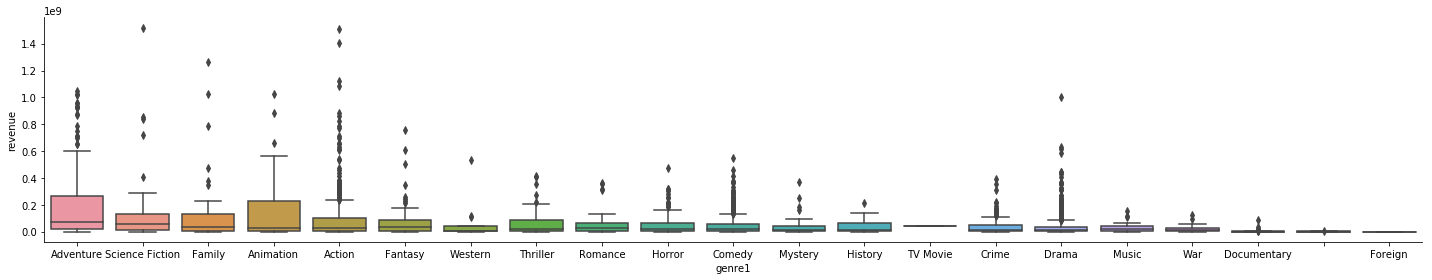

In [34]:
sns.catplot(x='genre1', y='revenue', data=train, 
            order=train.groupby('genre1')['revenue'].mean().sort_values(ascending=False).index, 
            kind='box', height=4, aspect=5)

Adventure movies have the highest mean revenue. Surprisingly drama is not in the top 5 (it is in the six spot from the end). Movies that are filled in some capacity with action or are family/animation have the highest revenue. It is worth mention that action movies are highly unstable in box office revenue (very high number of outliers). So if you want to make a movie that will have higher revenue, you should make adventure or animated movie.

**How genre 1 affects budget?**

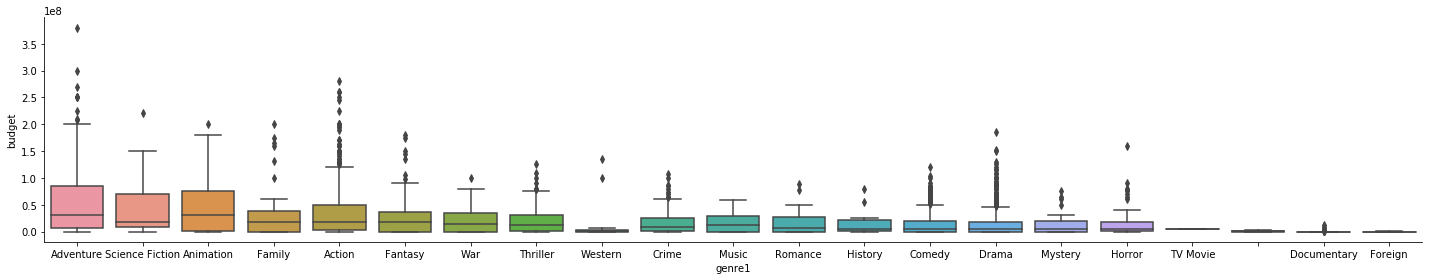

In [35]:
sns.catplot(x='genre1', y='budget', data=train, 
            order=train.groupby('genre1')['budget'].mean().sort_values(ascending=False).index, 
            kind='box', height=4, aspect=5)

You need the biggest budget for adventure, science fiction and animated movies.

This plot shows the same conclusion with the one stated before, that bigger budget means higher revenue.

On the other hand, to make adventure/science fiction/(animated ?) movies you need a lot money for scenography to make them look realistic.

**How genre 1 affects profit?**

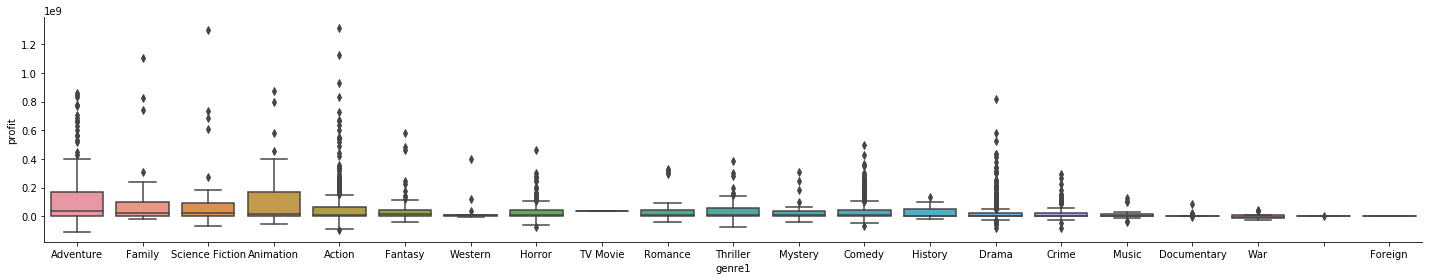

In [36]:
sns.catplot(x='genre1', y='profit', data=train, 
            order=train.groupby('genre1')['profit'].mean().sort_values(ascending=False).index, 
            kind='box', height=4, aspect=5)

Still on number one spot adventure movies. What is different is that family movies are in second place. I think it is not surprising because a lot of parents take kids to cinema. Even when parents do not like a movie or it got bad reviews, kids will still want to go to the cinema and in most cases that will happen.

As I metioned before, action movies are unstable in case of their profits (looking at this data you can't be sure if profits will be hight or low).

## homepage

URL address of movie homepage.

**How many homepage addresses are filled?**

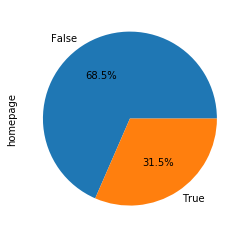

In [37]:
train['homepage'].notnull().value_counts().plot(kind='pie', autopct='%1.1f%%')

There are only 31.5% of filled homepage addresses (68.5% is missing). Lets create new feature indicating if a movie has homepage or not. After that this feature (with homepage addresses) can be dropped.

In [38]:
# Create new feature describing if a movie have a homepage.
train['has_homepage'] = train['homepage'].notnull()
test['has_homepage'] = test['homepage'].notnull()

In [39]:
# Remove homepage feature
#train.drop(labels=['homepage'], axis=1, inplace=True)
#test.drop(labels=['homepage'], axis=1, inplace=True)

**Do movies with homepage have higher revenue?**

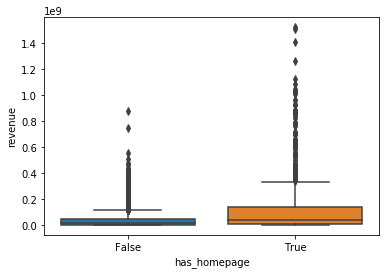

In [40]:
sns.boxplot(x='has_homepage', y='revenue', data=train)

Generally, movies with homepage have higher box office revenue.

**Does a budget decide about having a homepage?**

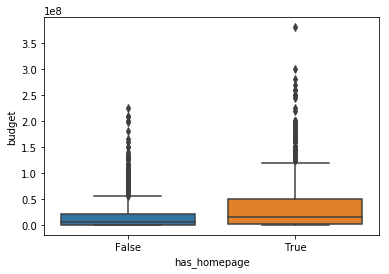

In [41]:
sns.boxplot(x='has_homepage', y='budget', data=train)

If a movie has a bigger budget, it means it should have a homepage. 

**How budget and heving homepage affects profit?**

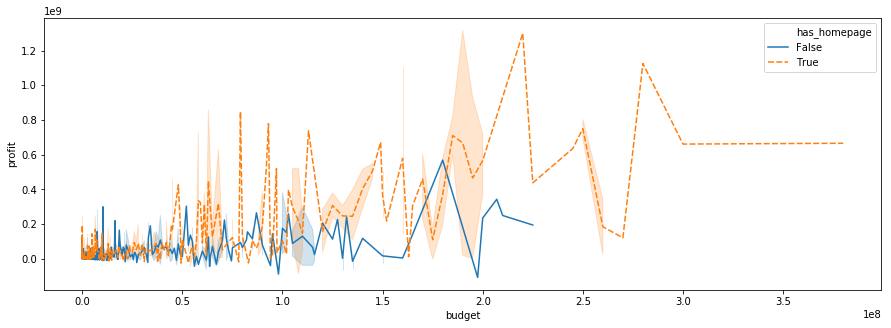

In [42]:
plt.figure(figsize=(15,5))
sns.lineplot(x='budget', y='profit', hue='has_homepage', data=train, style='has_homepage')

Having a bigger budget and having a homepage increases chances of getting bigger profit.

## imdb_id

URL address of IMDB page related to a movie.

This feature could be used to gather more data or fill in missing ones but in this kernel I won't be doing this.
So feature can be safely removed.

In [43]:
# Delete imdb_id feature
# train.drop(labels=['imdb_id'], axis=1, inplace=True)
# test.drop(labels=['imdb_id'], axis=1, inplace=True)

## original_language

Original language in which movie was released.

**Which original language is the most used?**

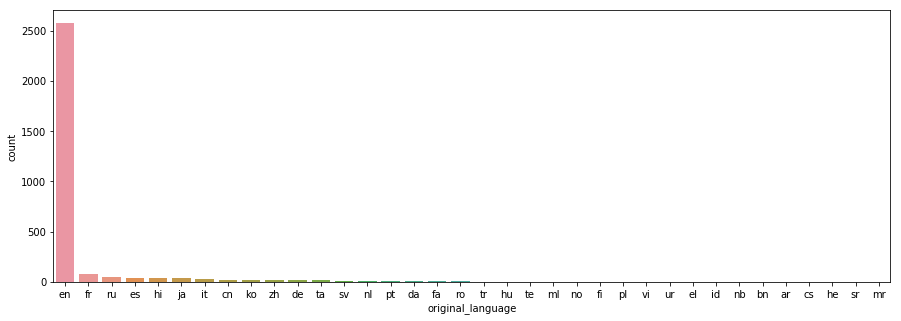

In [44]:
plt.figure(figsize=(15,5))
sns.countplot(x='original_language', data=train, order=train['original_language'].value_counts().index)

No surprises, English is the most popular original language. Probably the reasons for that is that most movies are produced by studios in USA and their movies are the most popular worldwide.
Another reason may be that they mainly collected English movies from TMDB to this dataset.

**Which original language has the highest revenue?**

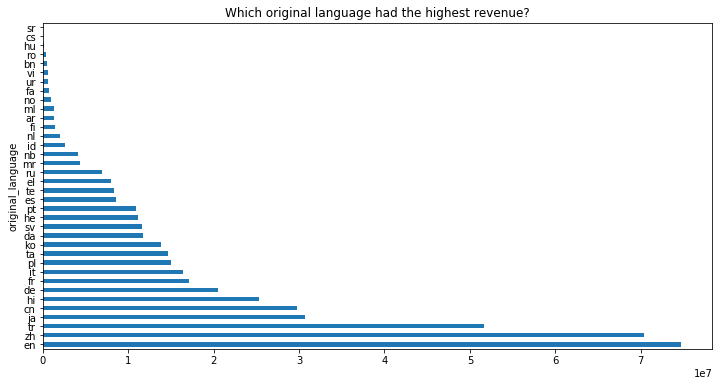

In [45]:
(train.groupby('original_language')['revenue'].mean().sort_values(ascending=False)
 .plot(kind='barh', figsize=(12,6), title='Which original language had the highest revenue?'))

The highest revenue have movies with English original language but movies with Chinese language are only slighty behind. Chinese language is maybe not that surprising considering China population but the next languages on the list are (third place belongs to Turkish ?!). I suspected that Hindi will be higher on the list because of Bollywood and that Spanish language movies will have higher revenue.

The most important thing is that these data is not precise due to the small number of other movies than English.

**How orginal language affects profit?**

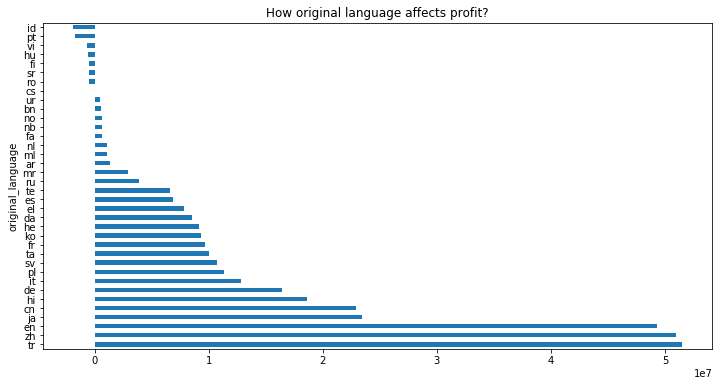

In [46]:
(train.groupby('original_language')['profit'].mean().sort_values(ascending=False)
 .plot(kind='barh', figsize=(12,6), title='How original language affects profit?'))

As before, we should not be sure of these results, given the small number of non-English films. But while working on what we have, we see that Chinese and Turkish films have slightly higher profits than English. Another funny thing is that movies with some languages do not bring profit, but losses. Conclusion: you should never produce movies in these languages.

## original_title

Movie orginal title.

**What are the most popular words in orginal title?**

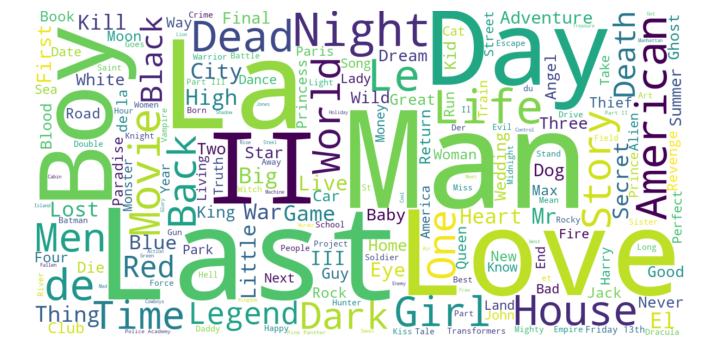

In [47]:
# Get all orginal titles
text = ' '.join(train['original_title'])

# Generate WordCloud from titles
wordcloud = WordCloud(max_font_size=None, background_color='white', width=1200, height=600).generate(text)

# Display wordcloud
plt.figure(figsize=(12,6))
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis('off')
plt.show()

In [48]:
# Get top 10 words in orginal title
stopwords = set(STOPWORDS)
words = text.lower().split(' ')
words = [word for word in words if (word not in stopwords and len(word) > 2)]
top_words = FreqDist(words).most_common(10)
top_words

[('man', 31),
 ('last', 30),
 ('love', 23),
 ('life', 21),
 ('movie', 20),
 ('american', 18),
 ('part', 18),
 ('dead', 18),
 ('house', 17),
 ('night', 16)]

**Having in orginal title popular words increases revenue?**

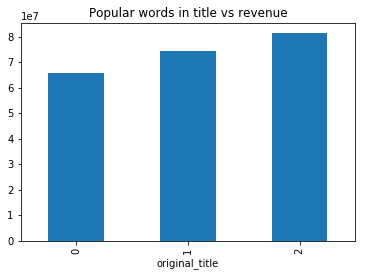

In [49]:
# Get only words from top_words
words = []
for word, _ in top_words:
    words.append(word)

has_popular_words = train['original_title'].apply(lambda title: len([True for word in words if (word in title.lower())]))
(pd.concat([train['revenue'], has_popular_words], axis=1).groupby('original_title')['revenue'].mean()
 .plot(kind='bar', title='Popular words in title vs revenue'))

Movies that contains top popular words in their titles have higher revenue. Having one word increases revenue, and having two words increases revenue even more.

## overview

Movie overwiew.

**Which words in overviews are most frequent?**

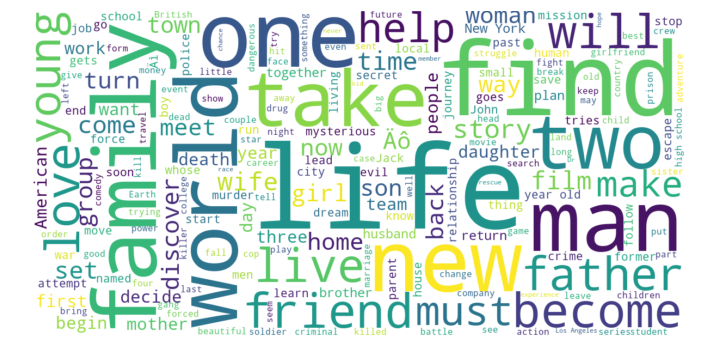

In [50]:
text = ' '.join(train['overview'].astype(str))

wordcloud = WordCloud(max_font_size=None, background_color='white', width=1200, height=600).generate(text)

plt.figure(figsize=(12,6))
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis('off')
plt.show()

FUTURE WORKS: try to rate overview in case of popularity/revenue of the movie. Which overviews have positive impact on revenue? How overview should look like to interest viewer?

## popularity

Popularity of the movie.

**How popularity rating looks like?**

In [51]:
train['popularity'].describe()

count    3000.000000
mean        8.463274
std        12.104000
min         0.000001
25%         4.018053
50%         7.374861
75%        10.890983
max       294.337037
Name: popularity, dtype: float64

 - No data missing. 
 - Average popularity rating is 8.463274.
 - Standard deviation is 12.104.
 - Max value looks wierd (anomaly like) based on mean +/- std.

**Which movies have the highest popularity? Are there any outliers (anomalies)?**

In [52]:
train[['original_title','popularity']].sort_values(by='popularity', ascending=False).head(10)

original_title  popularity
518                     Wonder Woman  294.337037
684             Beauty and the Beast  287.253654
1695                     Baby Driver  228.032744
2326                        Deadpool  187.860492
2126  Guardians of the Galaxy Vol. 2  185.330992
1309                       Gone Girl  154.801009
1715  War for the Planet of the Apes  146.161786
1673                 The Dark Knight  123.167259
1126                    The Avengers   89.887648
2293                      The Circle   88.439243

High popularity of some movies means that is buzz around them (people talking about them). We can see on the list movies that are released in last decade or are critically acclaimed. Conclusion: no outliers.

**How budget affect popularity?**

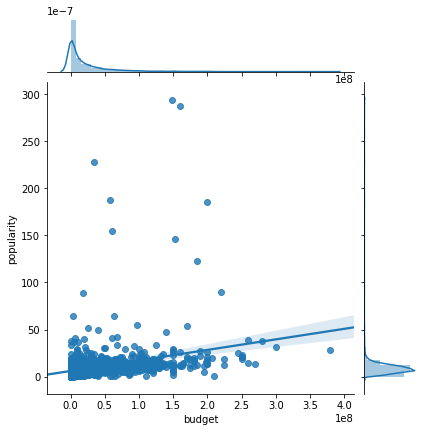

In [53]:
sns.jointplot(x='budget', y='popularity', data=train, kind='reg')

Looking at this data we can say that budget is not that important in case of movie popularity despite slightly positive slope. We need to take into account distribution of the data (low number of movies with high budget in contrast to high number of movies with low budget). Movies with the biggest budget are almost all under regression line.

**Does a popularity of a movie affects box office revenue?**

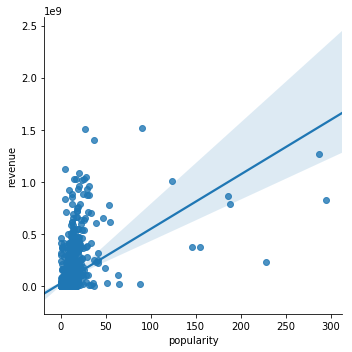

In [54]:
sns.lmplot(x='popularity', y='revenue', data=train)

Popularity of a movie has a positive impact on box office revenue.

**And what about profit?**

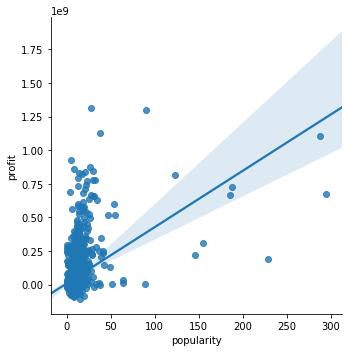

In [55]:
sns.lmplot(x='popularity', y='profit', data=train)

Popular movies tend to have bigger profits. I check this data because high revenue does not always mean high profit.

## poster_path

Path to image of the movie poster.

You could analyse posters to find out what features are important for movies with high revenue.
How poster should look like to draw a viewer to watch a movie?

I will skip this feature and delete it.

In [56]:
# Drop poster_path feature
#train.drop(labels=['poster_path'], axis=1, inplace=True)
#test.drop(labels=['poster_path'], axis=1, inplace=True)

## production_companies

Companies that produce a movie.

**How many companies take part in producing a single movie?**

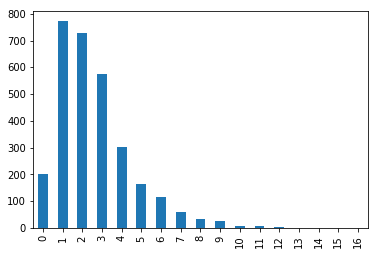

In [57]:
train['production_companies'] = train['production_companies'].apply(parse_json)
train['production_companies'].apply(len).value_counts().sort_index().plot(kind='bar')

In most cases movie is produce by one to three companies, sometimes by four. But in dataset we have movies that are produce by even 16 companies.

**Which companies produce the most movies?**

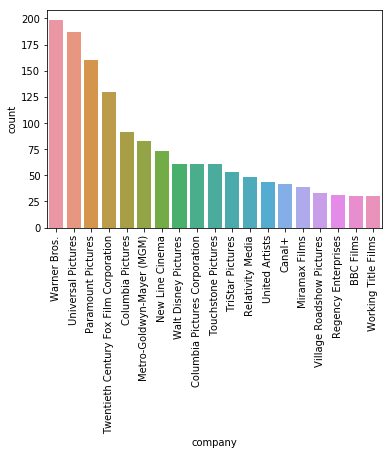

In [58]:
# Get only list of names from list of directories
def parse_to_names(l):
    return [str(x['name']) for x in l]

companies = Counter(','.join(train['production_companies'].apply(parse_to_names)
                             .apply(lambda x: ','.join(x))).split(',')).most_common(21)
c = []
v = []
for x in companies[1:-1]:
    c.append(x[0])
    v.append(x[1])

df = pd.DataFrame(data={'company':c, 'count':v})

g = sns.barplot(x='company', y='count', data=df).set_xticklabels(rotation=90, labels=df['company'])

Warner Bros produced the largest number of movies. Second place belongs to Universal Pictures.
Only four companies have produced more than 100 movies.

In [59]:
# Get full list of unique values from selected json feature
def get_list(df, feature):
    l = []
    for row in df[feature].apply(parse_to_names):
        l.extend(x for x in row if x not in l)
    return l

# Get companies names
companies = get_list(train, 'production_companies')

# Show five top entries
companies[:5]

['Paramount Pictures',
 'United Artists',
 'Metro-Goldwyn-Mayer (MGM)',
 'Walt Disney Pictures',
 'Bold Films']

In [60]:
# One hot encode all elements from list l with all movies based on json feature
# Returns new dataframe with one hot encoded data
def list_one_hot_encoding(df, feature, l):
    new_df = df.copy()
    for x in l:
        new_df[x] = df[feature].apply(parse_to_names).apply(lambda y: 1 if x in y else 0)
    return new_df
            
# One hot encoding of prodction companies
companies_df = list_one_hot_encoding(train, 'production_companies', companies)

In [61]:
# Show top rows of encoded production companies
companies_df[companies[:5]].head()

Paramount Pictures  United Artists  Metro-Goldwyn-Mayer (MGM)  \
0                   1               1                          1   
1                   0               0                          0   
2                   0               0                          0   
3                   0               0                          0   
4                   0               0                          0   

   Walt Disney Pictures  Bold Films  
0                     0           0  
1                     1           0  
2                     0           1  
3                     0           0  
4                     0           0

In [62]:
# Create new dataframe with aggregated data for passed list 'l' based on 'df' dataframe.
# name - name of elements in list
# Return new dataframe(name, movies_produced, most_popular_genre1, genre_1_count, top_language, language_count,
#                      mean_popularity, mean_budget, mean_revenue, mean_profit)
def aggregate_data(df, l, name):
    aggregated_df = pd.DataFrame(columns=[name, 'movies_produced', 'most_popular_genre1', 'genre1_count',
                                          'top_language', 'language_count', 'mean_popularity', 'mean_budget', 
                                          'mean_revenue', 'mean_profit'])
    for x in l:
        # Group data by element from the list and get its group
        group_df = df.groupby(x).get_group(1)
        
        # Create new row data and append it to dataframe
        aggregated_df = aggregated_df.append({name: x,
                                              'movies_produced': group_df['id'].count(),
                                              'most_popular_genre1': group_df['genre1'].value_counts().index[0],
                                              'genre1_count': group_df['genre1'].value_counts()[0],
                                              'top_language': group_df['original_language'].value_counts().index[0],
                                              'language_count': group_df['original_language'].value_counts()[0],
                                              'mean_popularity': group_df['popularity'].mean(),
                                              'mean_budget': group_df['budget'].mean(),
                                              'mean_revenue': group_df['revenue'].mean(),
                                              'mean_profit': group_df['profit'].mean()},
                                             ignore_index=True)
        
    # Return dataframe with aggregate data
    return aggregated_df
        
# Get aggregate companies data
companies_df = aggregate_data(companies_df, companies, 'company')

# Show top rows of companies dataframe
companies_df.head()

company movies_produced most_popular_genre1 genre1_count  \
0         Paramount Pictures             160              Comedy           34   
1             United Artists              44               Drama           11   
2  Metro-Goldwyn-Mayer (MGM)              83               Drama           19   
3       Walt Disney Pictures              61           Adventure           18   
4                 Bold Films               4               Drama            2   

  top_language language_count  mean_popularity   mean_budget  mean_revenue  \
0           en            158        10.062205  3.601408e+07  1.249136e+08   
1           en             43         8.697843  1.478253e+07  6.273135e+07   
2           en             83         7.052349  2.871009e+07  6.950379e+07   
3           en             59        20.439594  8.901475e+07  3.062071e+08   
4           en              4        25.031361  1.157500e+07  3.977773e+07   

    mean_profit  
0  8.889956e+07  
1  4.794881e+07  
2  4.079369e+07  
3  2.171924e+08  
4  2.820273e+07

In [63]:
# Plot with number of movies produced by each company was done earlier by different method.
# Which company produced the most movies?
#sns.barplot(x='company', y='movies_produced', data=companies_df.sort_values(by='movies_produced', ascending=False).head(20))

**Based on companies that produced the most movies which genre was most popular?**

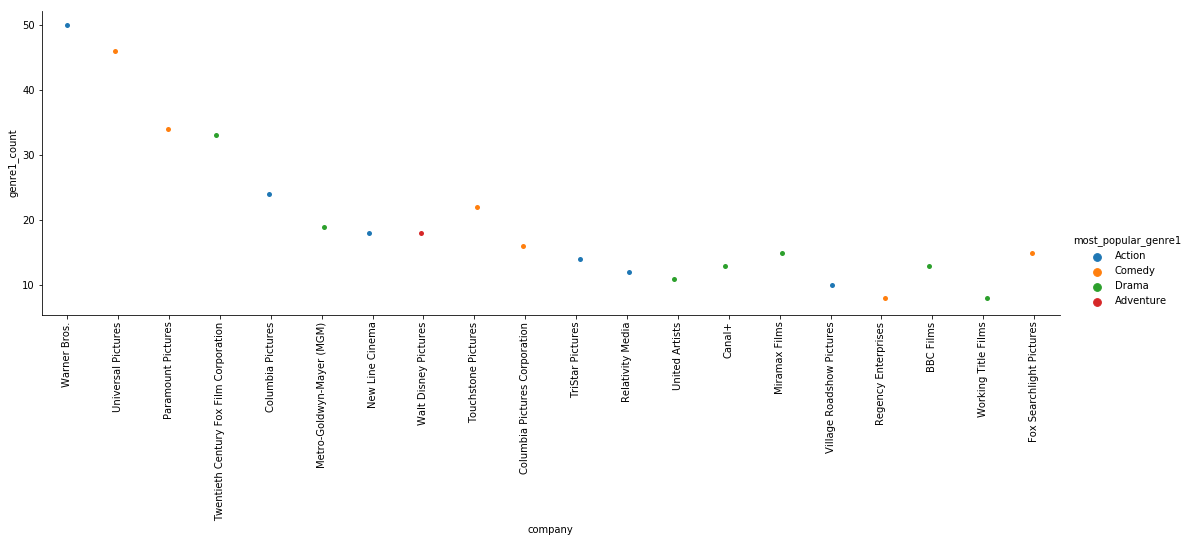

In [64]:
g = sns.catplot(x='company', y='genre1_count', hue='most_popular_genre1', 
                data=companies_df.sort_values(by='movies_produced', ascending=False).head(20), aspect=3)
g.set_xticklabels(rotation=90)

The most popular genres in companies are Action, Comedy and Drama. One different value is for Adventure movies which Walt Disney Pictures produces the most.

**Which company has the best mean movie popularity?**

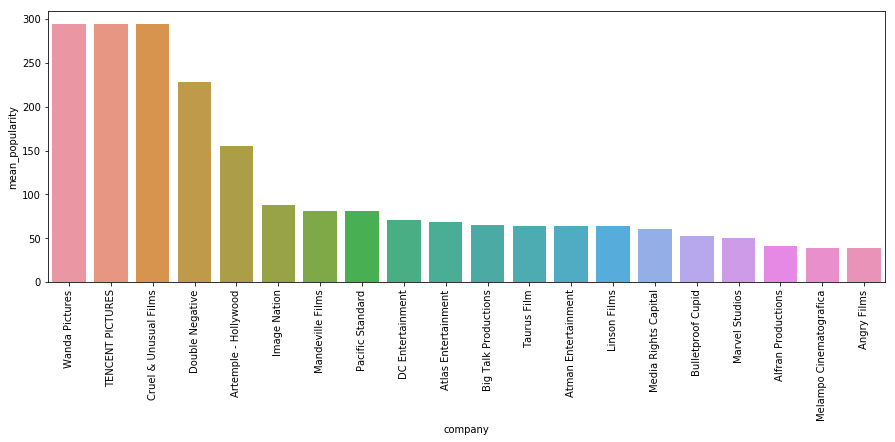

In [65]:
plt.figure(figsize=(15,5))
g = (sns.barplot(x='company', y='mean_popularity', 
                data=companies_df.sort_values(by='mean_popularity', ascending=False).head(20))
     .set_xticklabels(rotation=90, labels=companies_df.sort_values(by='mean_popularity', ascending=False)
                      .head(20)['company']))

Honestly, I do not know these companies except DC Entertainment and Marvel Studios. I assume that these companies have only a few movies and are therefore at the top of the list.

**How many movies our top companies produced?**

In [66]:
companies_df.sort_values(by='mean_popularity', ascending=False)[['company','movies_produced']].head(20)

company movies_produced
924            Wanda Pictures               1
923          TENCENT PICTURES               1
922     Cruel & Unusual Films               1
2366          Double Negative               1
1931     Artemple - Hollywood               1
2959             Image Nation               1
1159         Mandeville Films               4
1930         Pacific Standard               2
921          DC Entertainment               7
142       Atlas Entertainment               5
1806     Big Talk Productions               4
2996              Taurus Film               1
2998      Atman Entertainment               1
2997             Linson Films               1
593      Media Rights Capital               5
2700        Bulletproof Cupid               1
1707           Marvel Studios               8
1674       Alfran Productions               1
1730  Melampo Cinematografica               1
2292              Angry Films               1

The result coincides with what I predicted earlier. Almost all companies have produced only one movie.

So once again. 

**Which company has the best mean movie popularity from companies that have produced minimum six movies?**

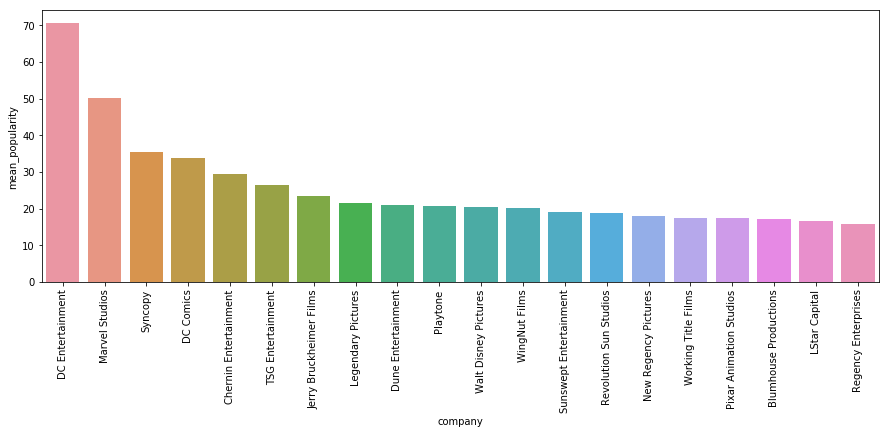

In [67]:
tmp = companies_df[companies_df['movies_produced'] > 5].sort_values(by='mean_popularity', ascending=False).head(20)

plt.figure(figsize=(15,5))
g = sns.barplot(x='company', y='mean_popularity', data=tmp).set_xticklabels(rotation=90, labels=tmp['company'])

Now, in my opinion, this plot looks better. After removing companies with less then six movies, we get more recognizable companies. What is more, we get results that are more accurate, because the production of only one popular movie can be a coincidence. In general, top places are for companies associated with production of movies based on comic books. Including Syncopy, which is Chrstopher Nolan's company, which produced The Dark Knight Trilogy, Man of Steel and Justic League, which are from DC Universe.

**Which company gives the biggest average budget to its movies?**

As before, I skip companies that have produced less than six movies.

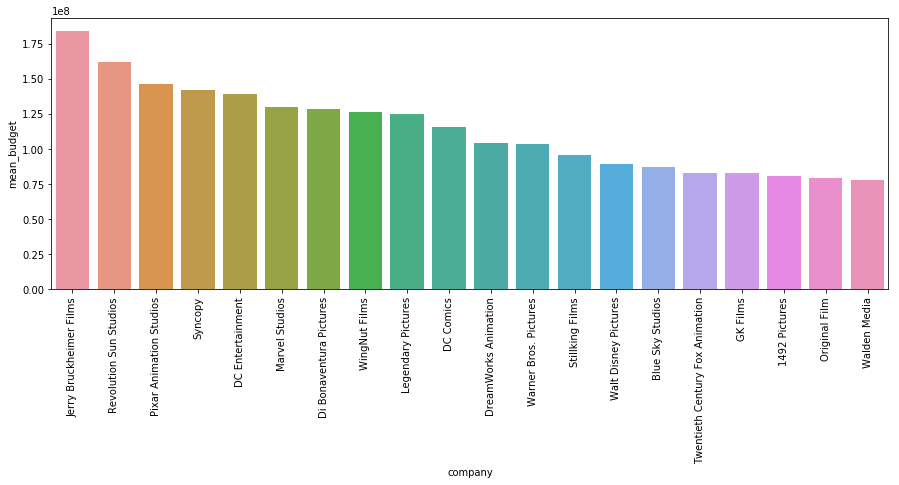

In [68]:
tmp = companies_df[companies_df['movies_produced'] > 5].sort_values(by='mean_budget', ascending=False).head(20)

plt.figure(figsize=(15,5))
g = sns.barplot(x='company', y='mean_budget', data=tmp).set_xticklabels(rotation=90, labels=tmp['company'])

On average, Jerry Bruckheimer Films gives biggest budget to its movies. Reason for that is that this company produced Pirates of the Caribbean movies which are the most expensive. In the leading places, we also have companies that produce comics adaptarions and Pixar which produces animations.

**Which company had the biggest average revenue form its movies?**

As before, I skip companies that have produced less than six movies.

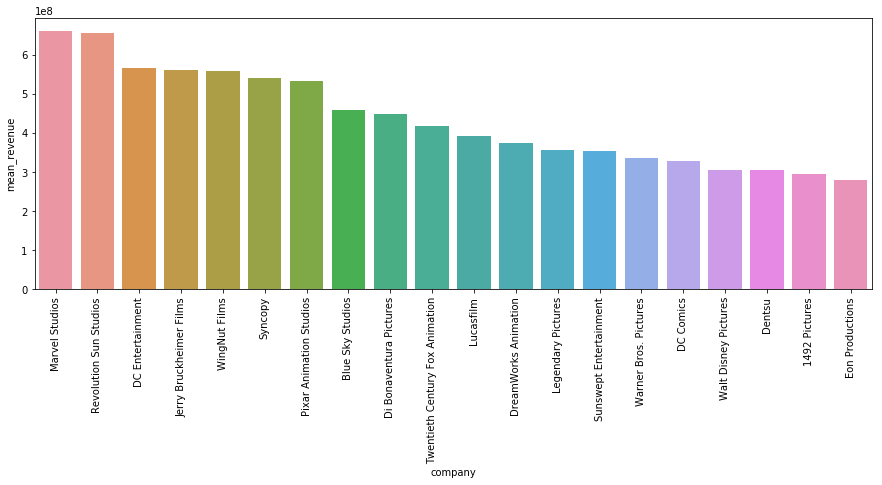

In [69]:
tmp = companies_df[companies_df['movies_produced'] > 5].sort_values(by='mean_revenue', ascending=False).head(20)

plt.figure(figsize=(15,5))
g = sns.barplot(x='company', y='mean_revenue', data=tmp).set_xticklabels(rotation=90, labels=tmp['company'])

The biggest average revenue have companies that produce blockbuster movies (comics adaptations, Pirates of the Caribbean, The Lord of the Rings, Star Wars or animations).

**Which company had the biggest average profit from its movies?**

As before, I skip companies that have produced less than six movies.

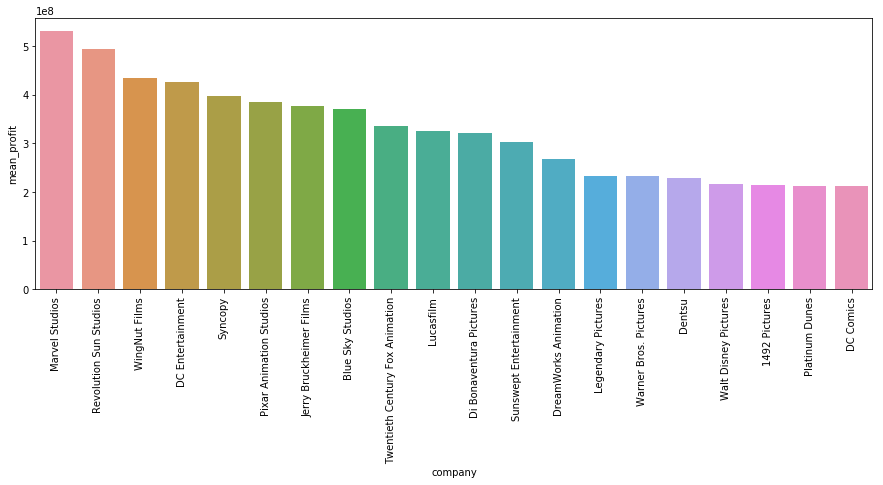

In [70]:
tmp = companies_df[companies_df['movies_produced'] > 5].sort_values(by='mean_profit', ascending=False).head(20)

plt.figure(figsize=(15,5))
g = sns.barplot(x='company', y='mean_profit', data=tmp).set_xticklabels(rotation=90, labels=tmp['company'])

The results are generally the same as before. Maybe with one reservation which is that Jerry Bruckheimer Films are the most expensive and should have bigger profits.

Conclusion: it is not worth to overpay for the production of movies. Above a certain budget value, profit does not go hand in hand.

In [71]:
# Delete companies dataframe from memory
del companies_df

And that will be all for production companies. It is worth mention that this analysis is not so accurate because some movies are produce by many companies which have different number of shares. Thay give diffrent amount of money for budget and then gets suitable percentage of revenues. And in this analysis I treated that if a company produces a movie, it givens the whole budget and has all revenues for itself. In other words, every movie data is included in whole in every company that produced it.

## production_countries

Countries where movie was made.

Dictionary with names of countries and their ISO codes.

In [72]:
# Show random values
train['production_countries'].sample(5)

1543    [{'iso_3166_1': 'US', 'name': 'United States o...
451     [{'iso_3166_1': 'US', 'name': 'United States o...
403     [{'iso_3166_1': 'US', 'name': 'United States o...
2743    [{'iso_3166_1': 'US', 'name': 'United States o...
2955    [{'iso_3166_1': 'US', 'name': 'United States o...
Name: production_countries, dtype: object

**In how many countries single movie is produced?**

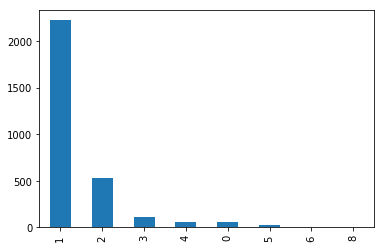

In [73]:
train['production_countries'].apply(parse_json).apply(len).value_counts().plot(kind='bar')

In most cases, movies are produced in one country. Sometimes in two, rarely in more then two (max 8). 0 production countries for a movie means missing value.

In [74]:
# Create new feature 'number of production countries'
train['production_countries_count'] = train['production_countries'].apply(parse_json).apply(len)
test['production_countries_count'] = test['production_countries'].apply(parse_json).apply(len)

In [75]:
# Parse countries to json
train['production_countries'] = train['production_countries'].apply(parse_json)

In [76]:
# Get list of unique production countries
countries = get_list(train, 'production_countries')

# Get countries data
countries_df = aggregate_data(list_one_hot_encoding(train, 'production_countries', countries), countries, 'country')

# Show top rows of countries dataframe
countries_df.head(5)

country movies_produced most_popular_genre1 genre1_count  \
0  United States of America            2282               Drama          542   
1                     India              81               Drama           27   
2               South Korea              22              Action            8   
3                    Canada             120              Action           27   
4                    Serbia               2              Action            1   

  top_language language_count  mean_popularity   mean_budget  mean_revenue  \
0           en           2260         9.504402  2.770047e+07  8.196680e+07   
1           hi             42         2.811573  7.332076e+06  2.348936e+07   
2           ko             20         4.989276  5.935591e+06  1.347524e+07   
3           en            114         9.525592  2.950754e+07  7.710796e+07   
4           en              1         4.136360  1.325000e+07  1.482897e+07   

    mean_profit  
0  5.426632e+07  
1  1.615729e+07  
2  7.539645e+06  
3  4.760042e+07  
4  1.578974e+06

**How many different production countries are there?**

In [77]:
len(countries)

74

**Which production country has the greatest mean popularity?**

I am taking into consideration production countries with minimum six movies.

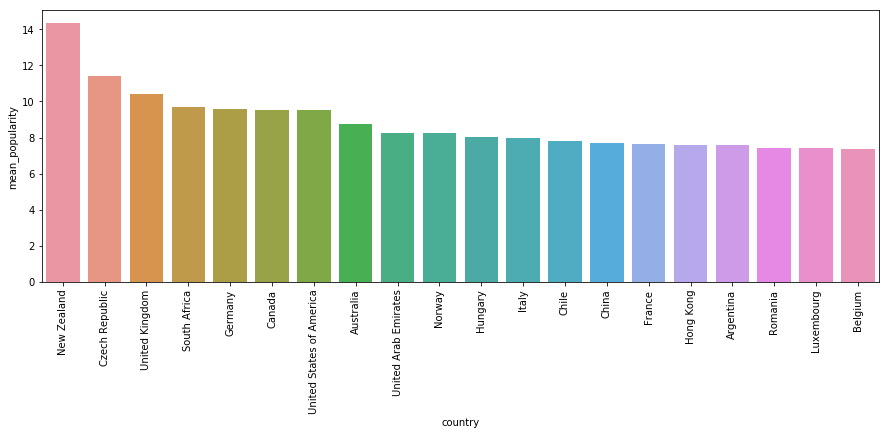

In [78]:
tmp = countries_df[countries_df['movies_produced'] > 5].sort_values(by='mean_popularity', ascending=False).head(20)

plt.figure(figsize=(15,5))
g = sns.barplot(x='country', y='mean_popularity', data=tmp).set_xticklabels(rotation=90, labels=tmp['country'])

New Zealand has the greatest mean popularity, but it only produced 17 movies. For example United Kingdom (3rd place) produced 380 movies. It is worth to remember that because of different number of produced movies it is hard to say that movies produced in one country are more popular than movies produced in other country. However in case of New Zealand first place in the list could be true because in this country they shot movies like: The Lord of the Rings trilogy, Hobbit trilogy or King Kong.

**In which production country movies had the biggest budget on average?**


I am taking into consideration production countries with minimum six movies.

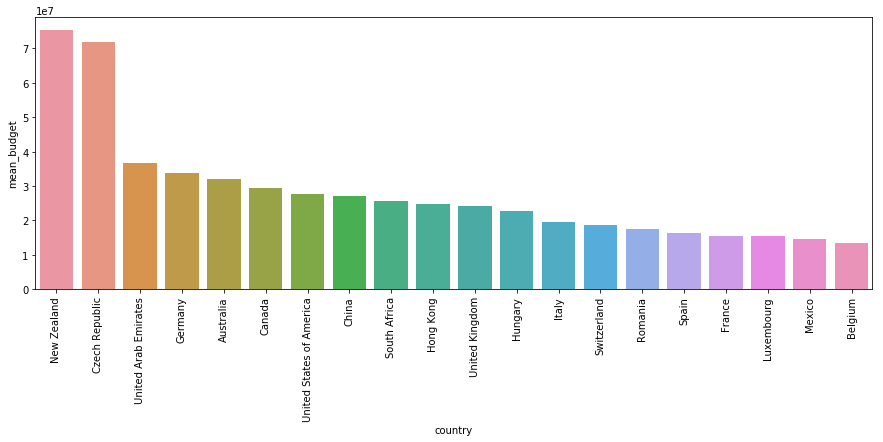

In [79]:
tmp = countries_df[countries_df['movies_produced'] > 5].sort_values(by='mean_budget', ascending=False).head(20)

plt.figure(figsize=(15,5))
g = sns.barplot(x='country', y='mean_budget', data=tmp).set_xticklabels(rotation=90, labels=tmp['country'])

In prevoius plot I mention movies produced in New Zealand, so it is not surprise that they are still in number one place. This huge advantage over other countries, such as  the USA and the UK (with exception of the Czech Republic), results from the small number of produced movies. Strangely, the Czech Republic is in second place with small loss to New Zealand. Movies shot in Czech Republic with a bigger budget are: Casino Royale, The Chronicles of Narnia: Prince Caspian, Van Helsing and Mission: Impossible - Ghost Protocol.

**In which production country movies had the biggest revenue on average?**

I am taking into consideration production countries with minimum six movies.

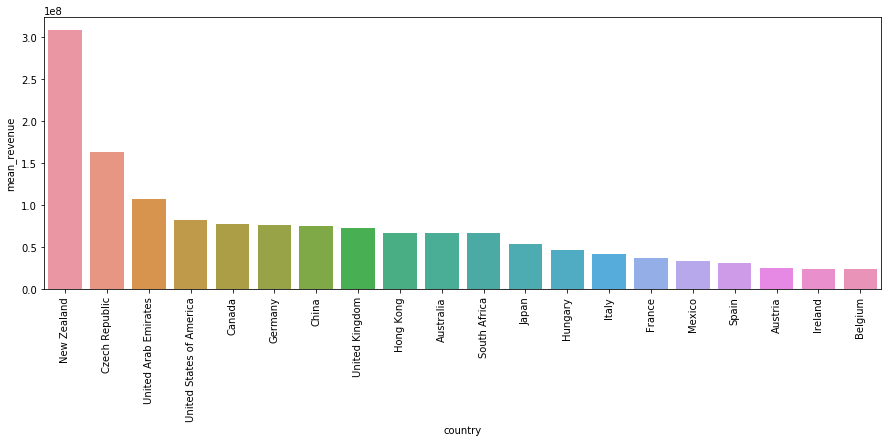

In [80]:
tmp = countries_df[countries_df['movies_produced'] > 5].sort_values(by='mean_revenue', ascending=False).head(20)

plt.figure(figsize=(15,5))
g = sns.barplot(x='country', y='mean_revenue', data=tmp).set_xticklabels(rotation=90, labels=tmp['country'])

No surprises, the New Zealand in first place. With only couple of **such** films there couldn't be any other winner.

**In which production country movies had the biggest profit on average?**

I am taking into consideration production countries with minimum six movies.

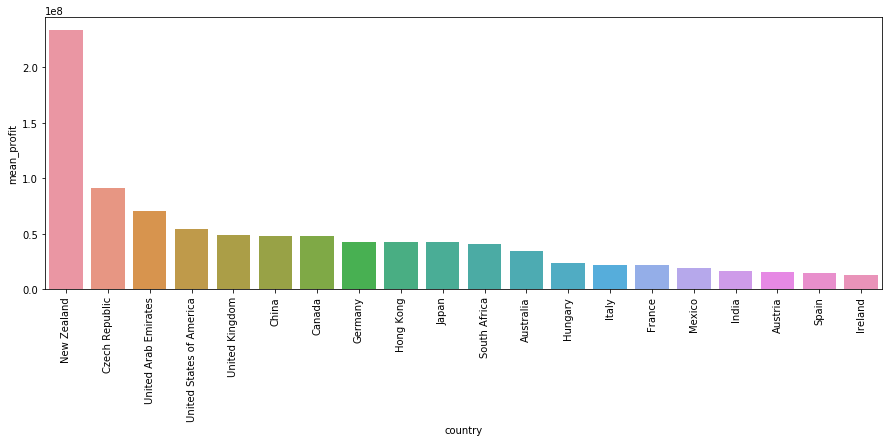

In [81]:
tmp = countries_df[countries_df['movies_produced'] > 5].sort_values(by='mean_profit', ascending=False).head(20)

plt.figure(figsize=(15,5))
g = sns.barplot(x='country', y='mean_profit', data=tmp).set_xticklabels(rotation=90, labels=tmp['country'])

I will not mention the New Zealand and the Czech Republic this time. The United Arab Emirates are that high because in this country they also shot Mission: Impossible - Ghost Protocol (like in the Czech Republic). The UK is on fourth place in case of profit and was in eighth place in case of revenue.

In [82]:
# Delete coutries dataframe from memory
del countries_df

## release_date

Date when movie was released.

MM/DD/YY

In [83]:
# Top 'release_date' rows
train['release_date'].head(10)

0     2/20/15
1      8/6/04
2    10/10/14
3      3/9/12
4      2/5/09
5      8/6/87
6     8/30/12
7     1/15/04
8     2/16/96
9     4/16/03
Name: release_date, dtype: object

In [84]:
# Convert correctly year from YY to YYYY format.
def convert_date(date):
    date = date.split('/')
    if int(date[2]) < 19:
        date[2] = '20' + date[2]
    else:
        date[2] = '19' + date[2]
    return '/'.join(date)

In [85]:
# Convert year (when you only use pandas to_datatime function, you will get wrong dates)
train['release_date'] = train['release_date'].apply(convert_date)

# Convert data to daytime64 type
train['release_date'] = pd.to_datetime(train['release_date'])

# Show converted data
train['release_date'].head(5)

0   2015-02-20
1   2004-08-06
2   2014-10-10
3   2012-03-09
4   2009-02-05
Name: release_date, dtype: datetime64[ns]

In [86]:
# Split data to parts as new features
train['release_date_year'] = train['release_date'].map(lambda x: x.year)
train['release_date_month'] = train['release_date'].map(lambda x: x.month)
train['release_date_day'] = train['release_date'].map(lambda x: x.day)
train['release_date_day_of_week'] = train['release_date'].apply(lambda x: x.dayofweek)

**How many movies were produced every year?**

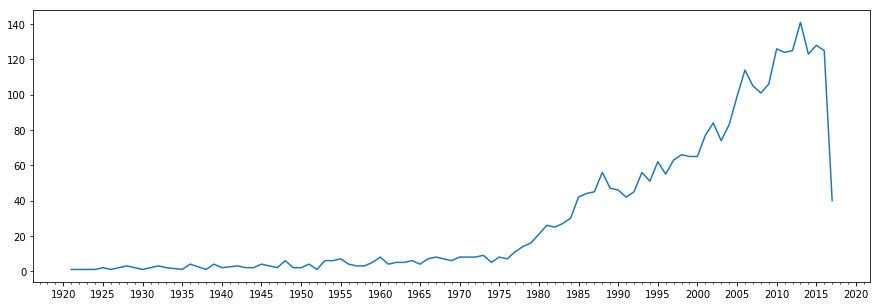

In [87]:
tmp = train['release_date_year'].value_counts()

plt.figure(figsize=(15,5))
ax = sns.lineplot(x=tmp.index, y=tmp.values)
ax.xaxis.set_major_locator(ticker.MultipleLocator(5))
ax.xaxis.set_minor_locator(ticker.MultipleLocator(1))

A larger increase in produced movies began just before the 1980s, when movies began to gain in popularity. Since then, more movies have been made with each year.

**Which month is the most popular when releasing a movie?**

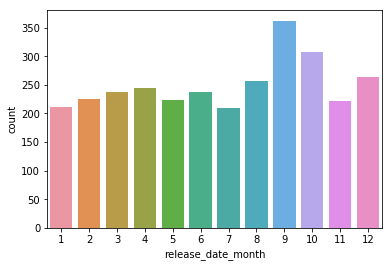

In [88]:
sns.countplot(x='release_date_month', data=train)

More movies released in September and October could be connected with Academy Awards. Later released movies are 'fresh' in memory so it have greater chance that academy nominates them. Personaly I thought that more movies would be released on summer when kids, teens have vacation and more time to go to a cinema.

**Which day is the most popular when releasing a movie?**

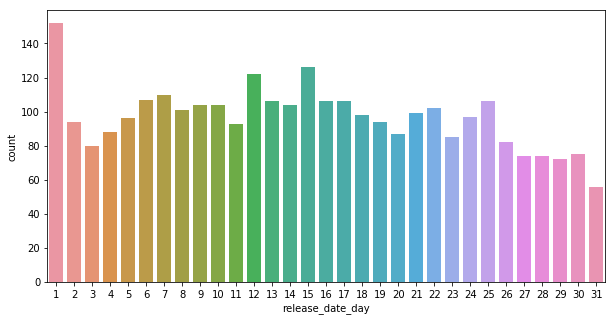

In [89]:
plt.figure(figsize=(10,5))
sns.countplot(x='release_date_day', data=train)

On the 1st of each month more movies are released. Also around the middle of the month, more movies appear than usual.

**Which day of the week is the most popular when releasing a movie?**

Day of week with Monday = 0 and Sunday = 6.

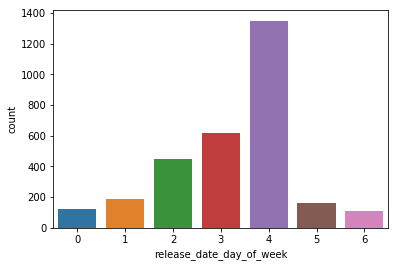

In [90]:
sns.countplot(x='release_date_day_of_week', data=train)

Most movies are released on Friday when weekend starts. Sometimes movies are released on Thursday or Wednesday. Almost no movies are released on Monday, Tuesday, Saturday and Sunday.

**How does the popularity of movies change with their release year?**

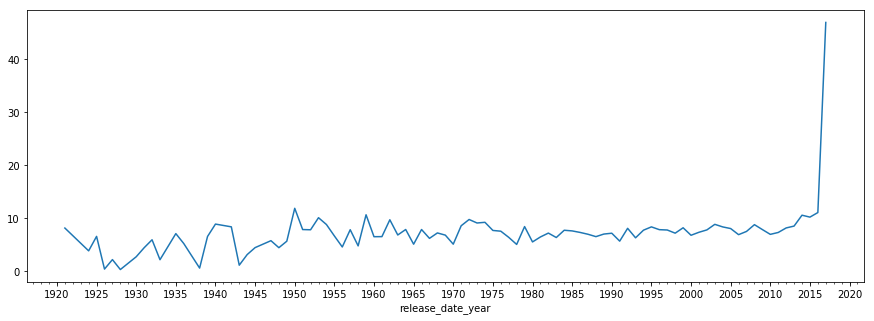

In [91]:
tmp = train.groupby(by='release_date_year')['popularity'].agg('mean')

plt.figure(figsize=(15,5))
ax = sns.lineplot(x=tmp.index, y=tmp.values)
ax.xaxis.set_major_locator(ticker.MultipleLocator(5))
ax.xaxis.set_minor_locator(ticker.MultipleLocator(1))

The popularity of the oldest movies is unstable. After 1950, the average popularity of movies begins to smooth around the value 9. Only new movies (released over the last year) have sky-high popularity (unlike other years).

**Which month has more poppular movies released?**

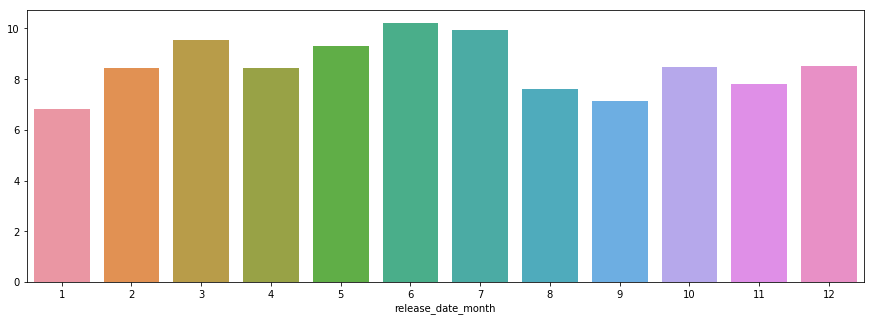

In [92]:
tmp = train.groupby(by='release_date_month')['popularity'].agg('mean')

plt.figure(figsize=(15,5))
ax = sns.barplot(x=tmp.index, y=tmp.values)

Popular movies are released more often in summer and in March.

**Which day of month has more poppular movies released?**

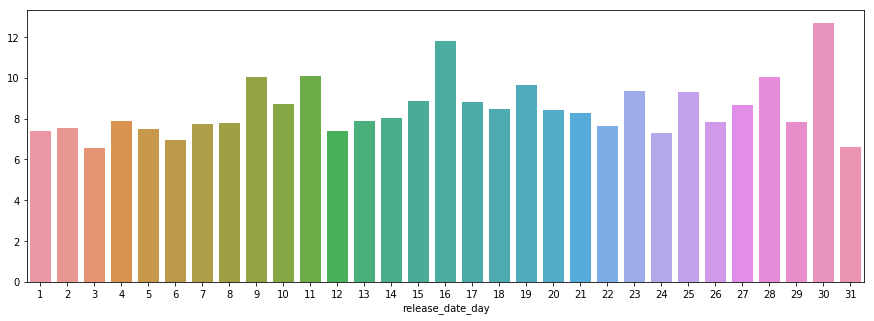

In [93]:
tmp = train.groupby(by='release_date_day')['popularity'].agg('mean')

plt.figure(figsize=(15,5))
ax = sns.barplot(x=tmp.index, y=tmp.values)

More popular movies were released at the end of the month (30th) or in the middle of the month (16th).

**Which day of the week has more poppular movies released?**

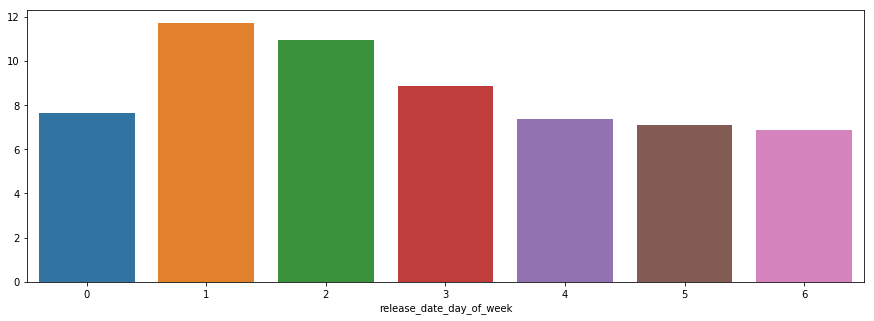

In [94]:
tmp = train.groupby(by='release_date_day_of_week')['popularity'].agg('mean')

plt.figure(figsize=(15,5))
ax = sns.barplot(x=tmp.index, y=tmp.values)

When most movies are released on Friday, more popular ones are released on Tuesday and Wednesday.

**How has the average budget of movies changed over the years?**

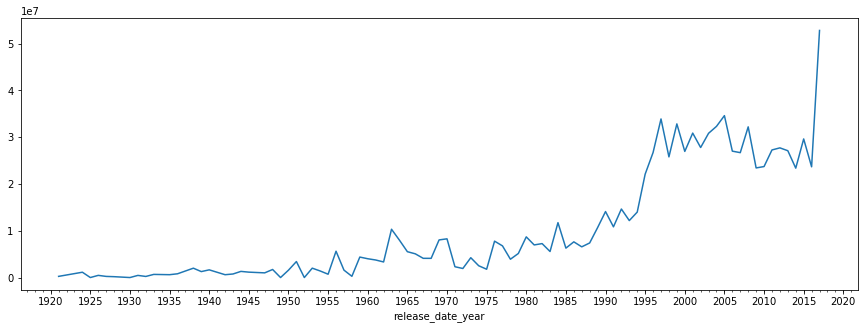

In [95]:
tmp = train.groupby(by='release_date_year')['budget'].agg('mean')

plt.figure(figsize=(15,5))
ax = sns.lineplot(x=tmp.index, y=tmp.values)
ax.xaxis.set_major_locator(ticker.MultipleLocator(5))
ax.xaxis.set_minor_locator(ticker.MultipleLocator(1))

The budget over the years grow gradually until 1995, when in the blink of the eye it doubles. This is probably related to the greater popularity of movies and the production of more movies.

**In which months do movies have an average higher budget?**

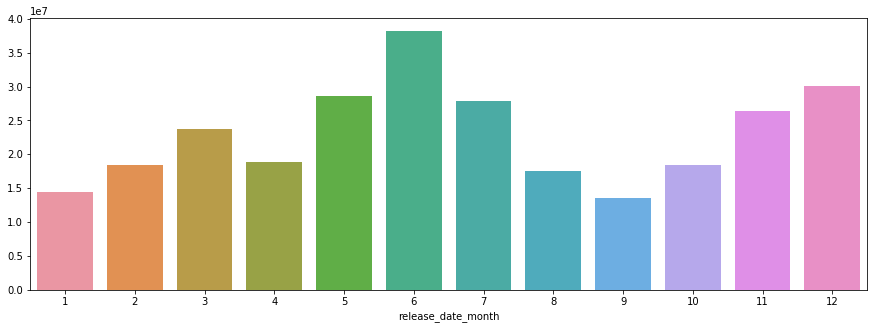

In [96]:
tmp = train.groupby(by='release_date_month')['budget'].agg('mean')

plt.figure(figsize=(15,5))
sns.barplot(x=tmp.index, y=tmp.values)

There are no surprises. When the summer begins, it is the time for blockbusters productions to hit the cinema. And these movies generaly have the largest budget. At the end of the year, the budget is also bigger, which is probably also releated to blockbuster productions (for example the Hobbit movies that where released in December).

**In what days do movies have a larger budget?**

Text(0.5, 1.0, 'Average budget in case of releasing a movie in different day of the week')

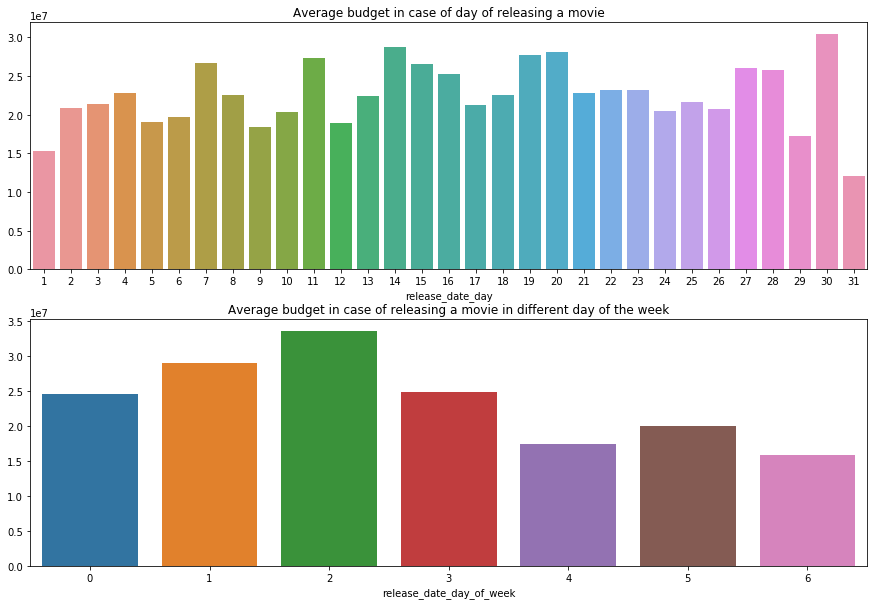

In [97]:
fig, ax = plt.subplots(2, 1, figsize=(15,10))

tmp = train.groupby(by='release_date_day')['budget'].agg('mean')
sns.barplot(x=tmp.index, y=tmp.values, ax=ax[0])
ax[0].set_title('Average budget in case of day of releasing a movie')

tmp = train.groupby(by='release_date_day_of_week')['budget'].agg('mean')
sns.barplot(x=tmp.index, y=tmp.values, ax=ax[1])
ax[1].set_title('Average budget in case of releasing a movie in different day of the week')

The day of the month is not important in case of budget size, but day of the week is. Movies have bigger budget on Tuesday and Wednesday which is probably connected with their popularity (popular movies are more often released on these days and what is more popular movies in most cases are blockbusters).

**How has the average movie box office revenue and profits changed over the years?**

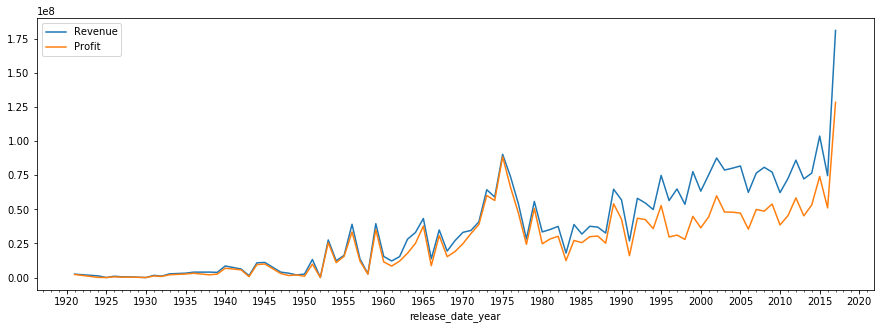

In [98]:
plt.figure(figsize=(15,5))

tmp = train.groupby(by='release_date_year')['revenue'].agg('mean')
ax = sns.lineplot(x=tmp.index, y=tmp.values, label='Revenue')

tmp = train.groupby(by='release_date_year')['profit'].agg('mean')
ax = sns.lineplot(x=tmp.index, y=tmp.values, label='Profit')

ax.xaxis.set_major_locator(ticker.MultipleLocator(5))
ax.xaxis.set_minor_locator(ticker.MultipleLocator(1))

At the beginning revenue and profit were almost the same till the 1980 when they began to diverge. Since then revenue and profit difference is more or less constant.

**How are average movie box office revenue and profit changes over months and days?**

Text(0.5, 1.0, 'Revenue and profit difference over the days')

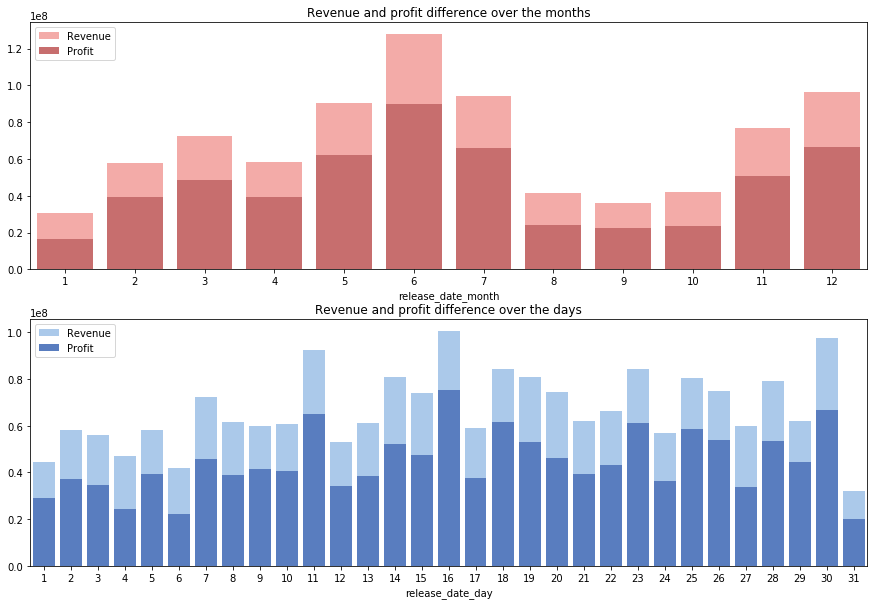

In [99]:
fix, ax = plt.subplots(2, 1, figsize=(15,10))

sns.set_color_codes('pastel')
tmp = train.groupby(by='release_date_month')['revenue'].agg('mean')
sns.barplot(x=tmp.index, y=tmp.values, ax=ax[0], label='Revenue', color='r')

sns.set_color_codes('muted')
tmp = train.groupby(by='release_date_month')['profit'].agg('mean')
sns.barplot(x=tmp.index, y=tmp.values, ax=ax[0], label='Profit', color='r')

ax[0].legend(loc="upper left")
ax[0].set_title('Revenue and profit difference over the months')

sns.set_color_codes('pastel')
tmp = train.groupby(by='release_date_day')['revenue'].agg('mean')
sns.barplot(x=tmp.index, y=tmp.values, ax=ax[1], label='Revenue', color='b')

sns.set_color_codes('muted')
tmp = train.groupby(by='release_date_day')['profit'].agg('mean')
sns.barplot(x=tmp.index, y=tmp.values, ax=ax[1], label='Profit', color='b')

ax[1].legend(loc="upper left")
ax[1].set_title('Revenue and profit difference over the days')

Movies have bigger revenue in summer and in the end of the year. They also have bigger revenue around  the middle of the month and on the last day of the month. As you can see the difference in revenue and profit is stable over the passing months and days.

**How are average movie box office revenue and profit changes over months?**

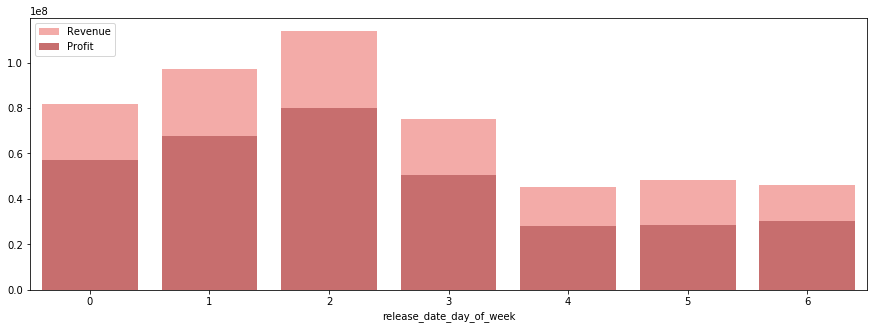

In [100]:
plt.figure(figsize=(15,5))

sns.set_color_codes('pastel')
tmp = train.groupby(by='release_date_day_of_week')['revenue'].agg('mean')
ax = sns.barplot(x=tmp.index, y=tmp.values, label='Revenue', color='r')

sns.set_color_codes('muted')
tmp = train.groupby(by='release_date_day_of_week')['profit'].agg('mean')
ax = sns.barplot(x=tmp.index, y=tmp.values, label='Profit', color='r')

ax.legend(loc="upper left")

Movies have higher revenue/profit at the beginning of the week, especially on Wednesday. As before, revenue and profit difference is stable.

## runtime

Runtime of a movie.

**How runtime distribution looks like?**

Average runtime:  107.85657104736491
Std of runtime:  22.08643442860854
Maximum runtime:  338.0


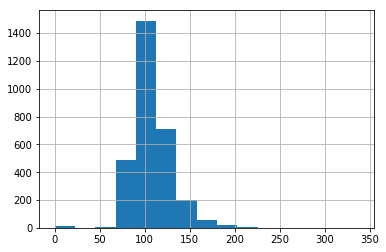

In [101]:
train['runtime'].hist(bins=15)
print('Average runtime: ', train['runtime'].mean())
print('Std of runtime: ', train['runtime'].std())
print('Maximum runtime: ', train['runtime'].max())

On average, movies last 108 minutes +/- 22 minutes. The longest movie is 338 minutes long.

**How is the runtime related to budget, revenue and profit, if it is at all?**

Text(0.5, 1.0, 'Impact of runtime to budget, revenue and profit')

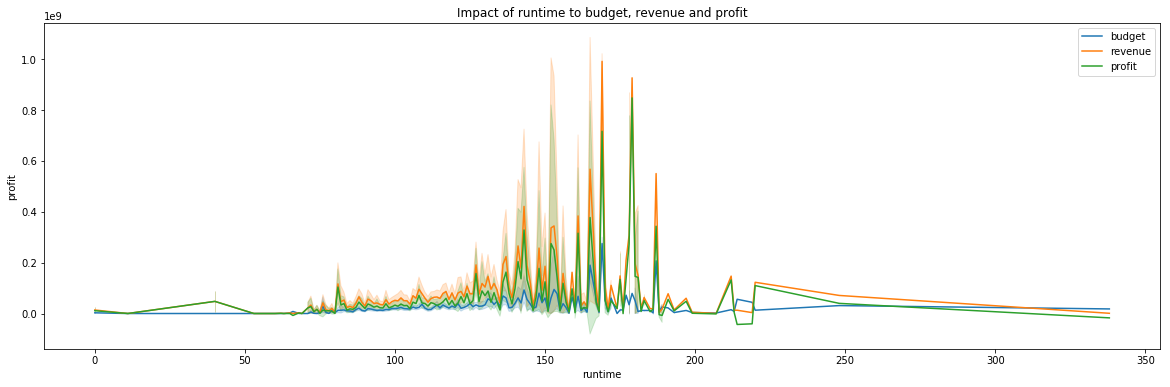

In [102]:
plt.figure(figsize=(20, 6))
sns.lineplot(x='runtime', y='budget', data=train, label='budget')
sns.lineplot(x='runtime', y='revenue', data=train, label='revenue')
sns.lineplot(x='runtime', y='profit', data=train, label='profit').set_title('Impact of runtime to budget, revenue and profit')

The runtime doesn't have huge impact on budget, revenue and profit. Maybe in case of movies longer than 190 minutes, because they have low revenue and profit. In addition, movies longer than 275 minuts have more costs than profits. Conclusion: you should not create movies that are too long because you will not have profit of them.

**How does the runtime change for main (first) movie genre?**

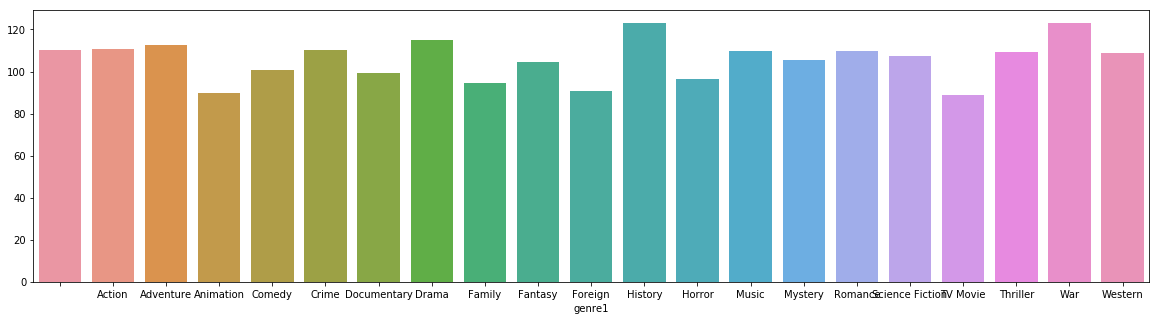

In [103]:
plt.figure(figsize=(20,5))
tmp = train.groupby(by='genre1')['runtime'].mean()
sns.barplot(x=tmp.index, y=tmp.values)

The first bar represents movies with missing genre data. The longest movies by genre are history and war. The shortest movies by genre are animation, tv movie and foreign.

## spoken_languages

Dictionary of languages used in a movie.

In [104]:
# Show top rows of spoken_languages
train['spoken_languages'].head()

0             [{'iso_639_1': 'en', 'name': 'English'}]
1             [{'iso_639_1': 'en', 'name': 'English'}]
2             [{'iso_639_1': 'en', 'name': 'English'}]
3    [{'iso_639_1': 'en', 'name': 'English'}, {'iso...
4             [{'iso_639_1': 'ko', 'name': '한국어/조선말'}]
Name: spoken_languages, dtype: object

In [105]:
# Parse spoken_languages to json
train['spoken_languages'] = train['spoken_languages'].apply(parse_json)

**How many languages are used in the movie?**

Average:  1.4523333333333333
Maximum languages used:  9


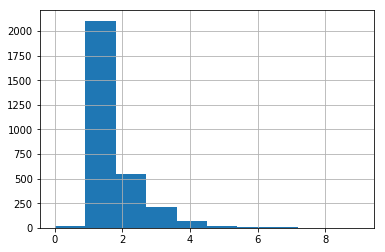

In [106]:
train['spoken_languages'].apply(len).hist(bins=10)
print('Average: ', train['spoken_languages'].apply(len).mean())
print('Maximum languages used: ', train['spoken_languages'].apply(len).max())

In most movies, the actors speak only in one language. Sometimes they speak in two languages. There is a movie that uses nine languages. This is the maximum number of languages in one movie. Movies without spoken language mean missing data.

In [107]:
# Create new feature representing number of languages spoken in a movie
train['spoken_languages_count'] = train['spoken_languages'].apply(len)

**In which movies actors are speaking with more than five languages?**

In [108]:
train[train['spoken_languages_count'] >= 6][['original_title','release_date','spoken_languages_count']].sort_values(by='spoken_languages_count')

original_title release_date  \
230                      Around the World in 80 Days   2004-06-16   
450                                  Chasing Liberty   2004-01-09   
646                                          Syriana   2005-11-23   
1615                                      District 9   2009-08-05   
1724                    Murder on the Orient Express   1974-11-24   
2349                                    The Exorcist   1973-12-26   
33                                   ABCs of Death 2   2014-10-02   
554                                       Metropolis   2001-05-26   
1059                            The Living Daylights   1987-06-29   
2158              The Life Aquatic with Steve Zissou   2004-12-10   
2176                             L'Auberge espagnole   2002-05-17   
2927                                 Die Another Day   2002-11-17   
609   The Swan Princess: Escape from Castle Mountain   1997-01-01   
1211                                          Carlos   2010-05-19   
2508                                            Pina   2011-02-24   

      spoken_languages_count  
230                        6  
450                        6  
646                        6  
1615                       6  
1724                       6  
2349                       6  
33                         7  
554                        7  
1059                       7  
2158                       7  
2176                       7  
2927                       7  
609                        8  
1211                       8  
2508                       9

There is even one movie from James Bond Collection (Die Another Day) on the list.

**Does the number of languages used affect the budget?**

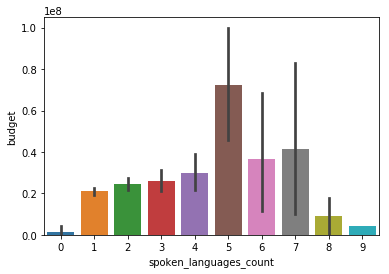

In [109]:
sns.barplot(x='spoken_languages_count', y='budget', data=train)

If in a movie actors are speaking multiple languages, budget of that movie must be larger. In case of one, two, three or even four languages there is no that much of a difference in a budget, but in case of five languages budget grows exponentially. It is also worth mentioning that the grater the number of used languages, the greater deviations from the average budget.

**Does the number of languages used affect revenue/profit?**

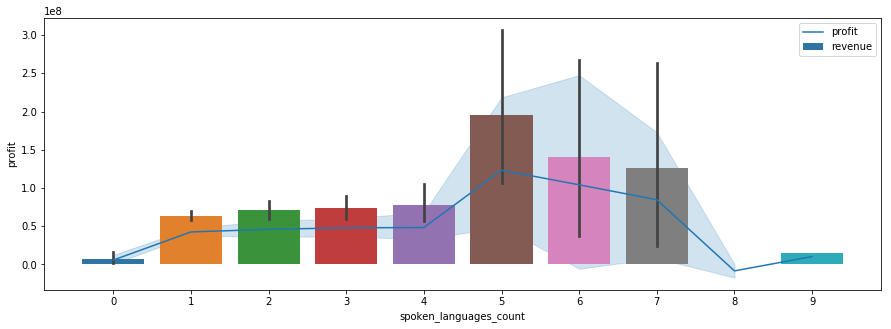

In [110]:
plt.figure(figsize=(15,5))
sns.barplot(x='spoken_languages_count', y='revenue', data=train, label='revenue')
sns.lineplot(x='spoken_languages_count', y='profit', data=train, label='profit')

Revenues and profits from movies using one to four languages are stable. Starting from five languages there are large deviations in revenues and profits (it is difficult to say whether a movie will have commercial success). Moreover, in case of six and more languages there is a possibility of a loss of money.

**How many languages are used based on genre?**

In [111]:
train.groupby(by='genre1')['spoken_languages_count'].mean()

genre1
                   0.571429
Action             1.626923
Adventure          1.545455
Animation          1.592105
Comedy             1.293046
Crime              1.421769
Documentary        1.352113
Drama              1.475159
Family             1.250000
Fantasy            1.573529
Foreign            1.000000
History            1.687500
Horror             1.317647
Music              1.450000
Mystery            1.212121
Romance            1.313433
Science Fiction    1.317073
TV Movie           1.000000
Thriller           1.508621
War                1.900000
Western            1.769231
Name: spoken_languages_count, dtype: float64

Typically, one to two languages are used in each genre.

In [112]:
# Get list of languages
languages = get_list(train, 'spoken_languages')

# Get languages data
languages_df = aggregate_data(list_one_hot_encoding(train, 'spoken_languages', languages), languages, 'language')

# Show top rows of languages dataframe
languages_df.head(5)

language movies_produced most_popular_genre1 genre1_count top_language  \
0  English            2618               Drama          659           en   
1   हिन्दी              56               Drama           22           hi   
2  한국어/조선말              37              Action           15           ko   
3  العربية              40               Drama           13           en   
4  Pусский             152              Action           40           en   

  language_count  mean_popularity   mean_budget  mean_revenue   mean_profit  
0           2516         9.120574  2.517456e+07  7.383859e+07  4.866403e+07  
1             41         3.625789  9.049120e+06  2.578711e+07  1.673799e+07  
2             20         7.353890  2.518381e+07  5.397148e+07  2.878767e+07  
3             33        10.207303  3.682219e+07  1.018556e+08  6.503341e+07  
4             93         6.193372  2.296566e+07  6.146659e+07  3.850093e+07

**Which movies are more popular based on the language used?**

Considering the languages used in at least 21 movies.

language  mean_popularity movies_produced
13      Latin        12.609301              23
7     Deutsch        10.378232             169
3     العربية        10.207303              40
14        普通话         9.519066              68
28    ภาษาไทย         9.278410              22
5     svenska         9.220666              22
9    Italiano         9.130362             124
0     English         9.120574            2618
15    Español         8.470600             239
10        日本語         8.463511              89
8    Français         8.370013             288
12  Português         8.132851              43
18                    7.391517              43
2     한국어/조선말         7.353890              37
17  广州话 / 廣州話         6.951134              36
24     Magyar         6.931593              24
4     Pусский         6.193372             152
22     Polski         6.034805              25
1      हिन्दी         3.625789              56
20      தமிழ்         2.013095              27

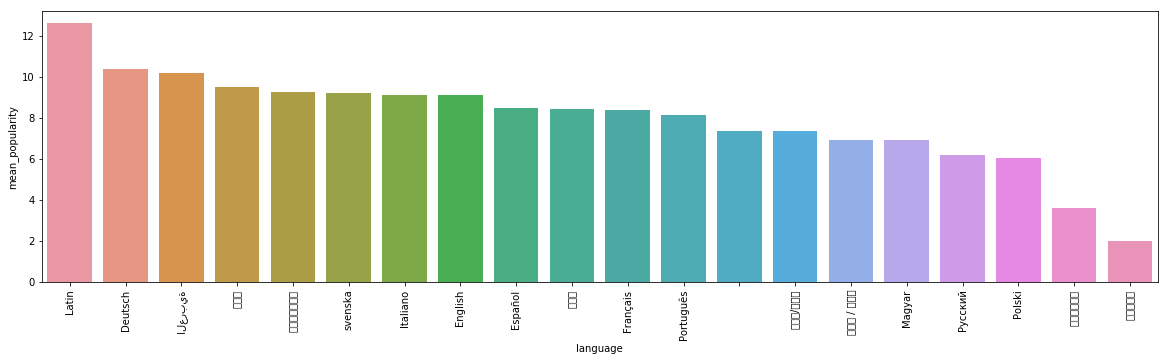

In [113]:
tmp = languages_df[languages_df['movies_produced'] > 20].sort_values(by='mean_popularity', ascending=False)

plt.figure(figsize=(20,5))
g = sns.barplot(x='language', y='mean_popularity', data=tmp).set_xticklabels(rotation=90, labels=tmp['language'].values)

tmp[['language','mean_popularity','movies_produced']]

The most popular are movies in which Latin is used. The second place belongs to German and the third to Arabic. Movies that have used Russian are not that popular (fourth place from the end), taking into account that there are 152 movies in this language.

**Which language has the average largest budget for a movie?**

Considering the languages used in at least 21 movies.

language   mean_budget movies_produced
13      Latin  5.142265e+07              23
28    ภาษาไทย  4.440909e+07              22
3     العربية  3.682219e+07              40
14        普通话  3.479818e+07              68
15    Español  2.796066e+07             239
12  Português  2.753641e+07              43
7     Deutsch  2.567287e+07             169
10        日本語  2.543456e+07              89
2     한국어/조선말  2.518381e+07              37
0     English  2.517456e+07            2618
18             2.421706e+07              43
8    Français  2.408695e+07             288
9    Italiano  2.399814e+07             124
4     Pусский  2.296566e+07             152
17  广州话 / 廣州話  2.225949e+07              36
5     svenska  2.081818e+07              22
22     Polski  1.236175e+07              25
24     Magyar  1.178312e+07              24
1      हिन्दी  9.049120e+06              56
20      தமிழ்  4.398990e+06              27

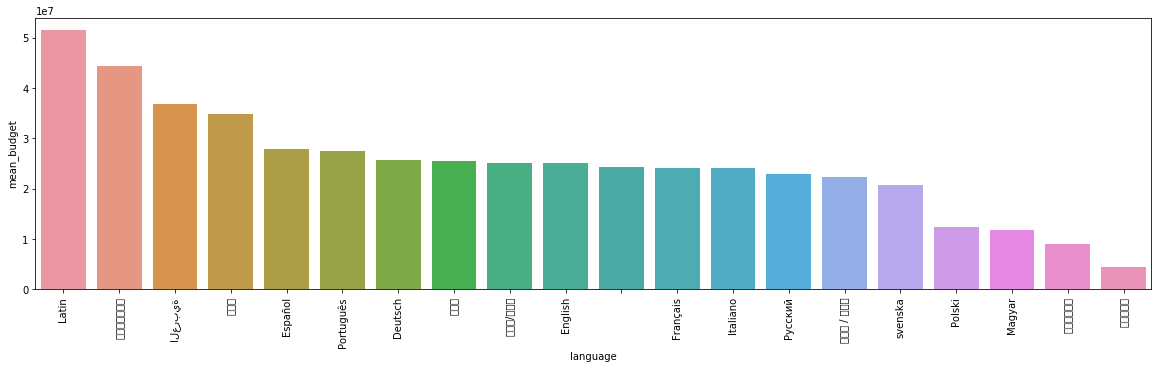

In [114]:
tmp = languages_df[languages_df['movies_produced'] > 20].sort_values(by='mean_budget', ascending=False)

plt.figure(figsize=(20,5))
g = sns.barplot(x='language', y='mean_budget', data=tmp).set_xticklabels(rotation=90, labels=tmp['language'].values)

tmp[['language','mean_budget','movies_produced']]

Movies that use Latin have the largest budget. Next are: Thai, Arabic and Standard Mandarin.

**Which language has the average biggest profit/revenue for a movie?**

Considering the languages used in at least 21 movies.

language movies_produced  mean_revenue   mean_profit
13      Latin              23  1.636938e+08  1.122711e+08
28    ภาษาไทย              22  1.351349e+08  9.072581e+07
5     svenska              22  9.447561e+07  7.365743e+07
14        普通话              68  1.020155e+08  6.721731e+07
3     العربية              40  1.018556e+08  6.503341e+07
9    Italiano             124  7.687754e+07  5.287940e+07
17  广州话 / 廣州話              36  7.386449e+07  5.160500e+07
15    Español             239  7.794961e+07  4.998895e+07
0     English            2618  7.383859e+07  4.866403e+07
18                         43  7.202958e+07  4.781252e+07
7     Deutsch             169  7.267119e+07  4.699832e+07
8    Français             288  6.944964e+07  4.536269e+07
10        日本語              89  6.423635e+07  3.880180e+07
4     Pусский             152  6.146659e+07  3.850093e+07
12  Português              43  6.198751e+07  3.445110e+07
2     한국어/조선말              37  5.397148e+07  2.878767e+07
1      हिन्दी              56  2.578711e+07  1.673799e+07
24     Magyar              24  2.498507e+07  1.320195e+07
22     Polski              25  2.134823e+07  8.986474e+06
20      தமிழ்              27  1.327855e+07  8.879560e+06

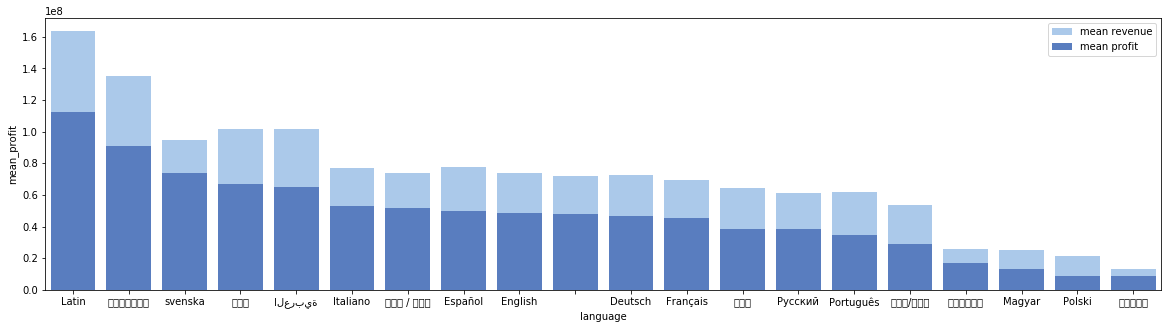

In [115]:
tmp = languages_df[languages_df['movies_produced'] > 20].sort_values(by='mean_profit', ascending=False)

plt.figure(figsize=(20,5))

sns.set_color_codes('pastel')
ax = sns.barplot(x='language', y='mean_revenue', data=tmp, label='mean revenue', color='b')

sns.set_color_codes('muted')
ax = sns.barplot(x='language', y='mean_profit', data=tmp, label='mean profit', color='b')

ax.legend(loc='upper right')

tmp[['language','movies_produced','mean_revenue','mean_profit']]

The biggest profit have those movies that use Latin, Thai, Swedish, Standard Mandarin and Arabic. Swedish has lower revenue than Standard Mandarin and Arabic, but has better profit.

## status

Status of the movie.

In [116]:
# Print unique values for status
print('From train set: ', train['status'].unique().tolist())
print('From test set: ', test['status'].unique().tolist())

From train set:  ['Released', 'Rumored']
From test set:  ['Released', 'Rumored', 'Post Production', nan]


**Which movies have status 'rumored' in train set?**

In [117]:
train[train['status'] == 'Rumored'][['original_title','release_date','revenue','status']]

original_title release_date   revenue  \
609   The Swan Princess: Escape from Castle Mountain   1997-01-01    273644   
1007                         Billy Gardell: Halftime   2011-02-05        60   
1216                                     Extremities   1986-08-22  13418091   
1618                          A Place Called Chiapas   1998-02-20    229000   

       status  
609   Rumored  
1007  Rumored  
1216  Rumored  
1618  Rumored

All these movies have been released. So we need to update their status.

**Which movies have status 'rumored' in test set?**

In [118]:
test[test['status'] == 'Rumored'][['original_title','release_date','status']]

original_title release_date   status
102   Good Morning, Babilonia      5/13/87  Rumored
1477         Любовь-морковь 2     12/23/08  Rumored

All these movies have been released. So we need to update their status.

**Which movies have status 'rumored' in test set?**

In [119]:
test[test['status'] == 'Post Production'][['original_title','release_date','status']]

original_title release_date           status
264     The Last Mountain       6/3/11  Post Production
847             Good Time      8/11/17  Post Production
1260     What Maisie Knew       5/2/13  Post Production
1448  Crimes of the Heart     12/12/86  Post Production
2585        Higher Ground      8/26/11  Post Production

All 'post production' movies were also released, so we need to update their status.

**Which movies have missing status in test set?**

In [120]:
test[test['status'].isnull()][['original_title','release_date','status']]

original_title release_date status
828   Jails, Hospitals & Hip-Hop          NaN    NaN
1056                      Stevie       9/9/02    NaN

As before, these movies were released.

Conclusion: after examining unique values other than 'Released' in both train and test set, I can state that all movies should have status set to 'Released'. By doing this I will get feature with only one possible value and this feature will not give any information during training the model, so it should be removed.

In [121]:
# Delete status feature
#train = train.drop(labels=['status'], axis=1)
#test = test.drop(labels=['status'], axis=1)

## tagline

Movie tagline - a catchphrase or slogan (short, memorable description) that becomes identified with a movie. Used in ads.

**How many taglines are missing?**

In [122]:
how_many_missing_values('tagline')

Missing tagline in train set: 597/3000 (0.199%)
Missing tagline in test set: 863/4398 (0.19622555707139608%)


In [123]:
# Create new feature indicating if a movie has a tagline
train['has_tagline'] = train['tagline'].notnull()
test['has_tagline'] = test['tagline'].notnull()

In [124]:
# Print sample taglines
train[train['has_tagline']][['original_title','tagline']].sample(10)

original_title  \
117                                           Wild Hogs   
2311                                          Baby Mama   
1405                                         The Family   
114   The Lord of the Rings: The Fellowship of the Ring   
2083                                         슈퍼맨이었던 사나이   
513                                             Timecop   
546                                       About Schmidt   
1714                             It Came from Hollywood   
1063  The Chronicles of Narnia: The Lion, the Witch ...   
1144                                         Zombeavers   

                                                tagline  
117            A lot can happen on the road to nowhere.  
2311          Would you put your eggs...in this basket?  
1405  Some call it organized crime. Others call it f...  
114                           One ring to rule them all  
2083                Small miracles can change the world  
513   They killed his wife ten years ago. There's st...  
546                                     Schmidt Happens  
1714                     We're going to make you LAUGH.  
1063                  Evil Has Reigned For 100 Years...  
1144                                  You'll be dammed!

**What are the most popular tagline words?**

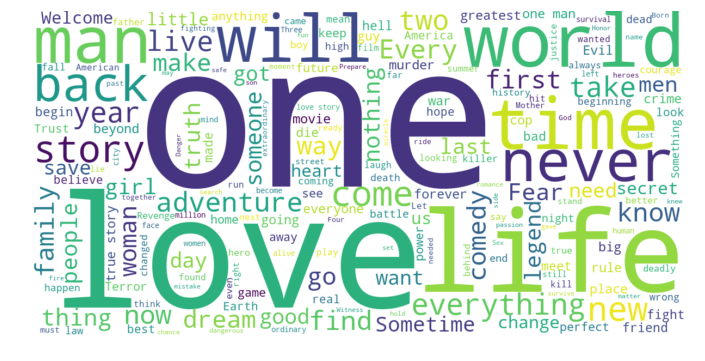

In [125]:
# Get all taglines
text = ' '.join(train[train['has_tagline']]['tagline'])

# Generate WordCloud from titles
wordcloud = WordCloud(max_font_size=None, background_color='white', width=1200, height=600).generate(text)

# Display wordcloud
plt.figure(figsize=(12,6))
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis('off')
plt.show()

One world, one life, one love.

Future work: We could try to rate tagline in case of revenue. Which tagline has positive impact on box office revenue?
Generally, the same as with overviews and movie posters.

**Having a tagline affects revenue?**

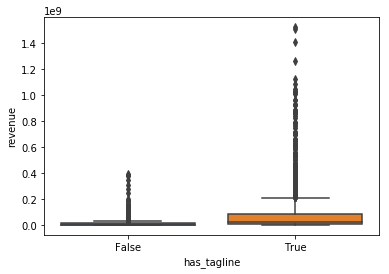

In [126]:
sns.boxplot(x='has_tagline', y='revenue', data=train)

Movies with tagline have bigger revenue. But proportion of movies with and without tagline is not equal, so you can't be 100% sure.

## title

International movie title.

**Which movies have different original title and title?**

In [127]:
print('Movies with different titles: ', train[train['title'] != train['original_title']].shape[0])

# Print sample movies with different titles
train[train['title'] != train['original_title']][['original_title', 'title']].sample(10)

Movies with different titles:  351


original_title  \
2389                     新世紀エヴァンゲリオン劇場版   
2064                             一個人的武林   
2688               The Raid 2: Berandal   
2698         El hombre de las mil caras   
1453        Под электрическими облаками   
1632  Три богатыря и Шамаханская царица   
978                         Joan of Arc   
2988                                 ده   
2292                               Чудо   
1317                            Поводир   

                                        title  
2389                    The End of Evangelion  
2064                           Kung Fu Jungle  
2688                               The Raid 2  
2698                          Smoke & Mirrors  
1453                    Under Electric Clouds  
1632  Tri bogatyrya i Shamakhanskaya tsaritsa  
978   The Messenger: The Story of Joan of Arc  
2988                                      Ten  
2292                              The Miracle  
1317                                The Guide

There are 351 movies with a different original title and title. In most cases, non-English movies have different titles.

In [128]:
# Create new feature indicating if a movie has different original title and title
train['has_different_titles'] = train['original_title'] != train['title']
test['has_different_titles'] = test['original_title'] != test['title']

**Having different titles affects revenue?**

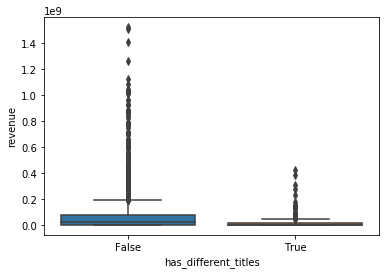

In [129]:
sns.boxplot(x='has_different_titles', y='revenue', data=train)

Movies with different titles have lower revenues. As with tagline, there are only few movies with different titles, so it is difficult to generalize to all cases. 

## Keywords

Keywords describing a movie.

Dictionary of IDs and names. 

**How many movies do not have keywords?**

In [130]:
how_many_missing_values('Keywords')

Missing Keywords in train set: 276/3000 (0.092%)
Missing Keywords in test set: 393/4398 (0.08935879945429741%)


In [131]:
# Parse to json
train['Keywords'] = train['Keywords'].apply(parse_json)

**How many keywords does the movie have?**

Train set Keywords parameters:
 count    3000.000000
mean        6.880667
std         6.653960
min         0.000000
25%         2.000000
50%         5.000000
75%        10.000000
max       149.000000
Name: Keywords, dtype: float64


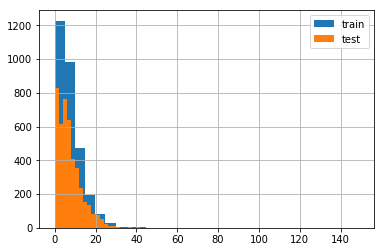

In [132]:
print('Train set Keywords parameters:\n', train['Keywords'].apply(len).describe())
ax = train['Keywords'].apply(len).hist(bins=30)
ax = test['Keywords'].apply(parse_json).apply(len).hist(bins=30)

ax.legend(labels=['train','test'])

On average, movies have almost seven keywords that describe them (+/- 6 keywords). One movie has 149 keywords, which is strange. Let's see which movie is it.

**Which movie has 149 keywords?**

In [133]:
train[train['Keywords'].apply(len) > 100][['original_title','release_date','production_countries','Keywords']]

original_title release_date  \
1793  Werckmeister harmóniák   2000-07-12   

                           production_countries  \
1793  [{'iso_3166_1': 'HU', 'name': 'Hungary'}]   

                                               Keywords  
1793  [{'id': 246, 'name': 'dancing'}, {'id': 255, '...

It is some Hungarian production released in year 2000.

**Which keywords are the most popular?**

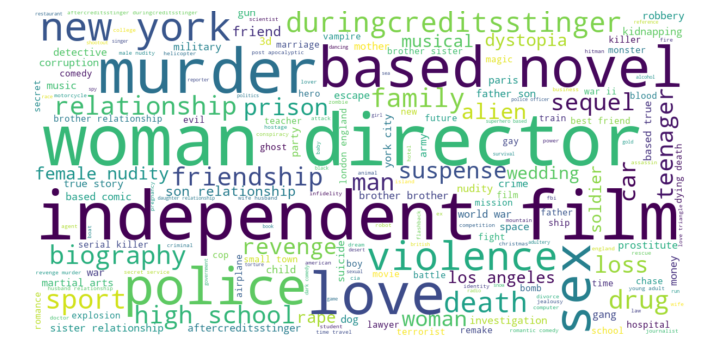

In [134]:
# Get all keywords
text = ','.join(train['Keywords'].apply(parse_to_names).apply(lambda x: ','.join(x)))

# Generate WordCloud from titles
wordcloud = WordCloud(max_font_size=None, background_color='white', width=1200, height=600).generate(text)

# Display wordcloud
plt.figure(figsize=(12,6))
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis('off')
plt.show()


**Which keywords are the most popular?**

Represented as a list of 200 most common keywords.

I will skip first element because it represents missing keyword.

In [135]:
keywords = Counter(text.split(',')).most_common(201)[1:]

# Print keywords
keywords

[('woman director', 168),
 ('independent film', 153),
 ('duringcreditsstinger', 133),
 ('murder', 123),
 ('based on novel', 107),
 ('violence', 84),
 ('sport', 80),
 ('biography', 75),
 ('dystopia', 73),
 ('revenge', 73),
 ('aftercreditsstinger', 73),
 ('sequel', 66),
 ('friendship', 66),
 ('suspense', 65),
 ('sex', 65),
 ('love', 64),
 ('police', 63),
 ('teenager', 61),
 ('nudity', 53),
 ('drug', 52),
 ('female nudity', 51),
 ('los angeles', 48),
 ('high school', 48),
 ('new york', 46),
 ('prison', 46),
 ('musical', 46),
 ('kidnapping', 41),
 ('investigation', 41),
 ('family', 40),
 ('father son relationship', 40),
 ('3d', 40),
 ('wedding', 39),
 ('detective', 38),
 ('paris', 35),
 ('based on comic', 35),
 ('robbery', 34),
 ('brother brother relationship', 34),
 ('prostitute', 34),
 ('escape', 33),
 ('rape', 33),
 ('alien', 33),
 ('based on true story', 33),
 ('london england', 33),
 ('death', 32),
 ('superhero', 32),
 ('corruption', 32),
 ('new york city', 31),
 ('martial arts', 31),

In [136]:
# Get only keywords from most common keywords list
keywords = [x[0] for x in keywords]

In [137]:
# One hot encode most common keywords
keywords_df = list_one_hot_encoding(train, 'Keywords', keywords)

**How each of selected 200 keywords affects revenue?**

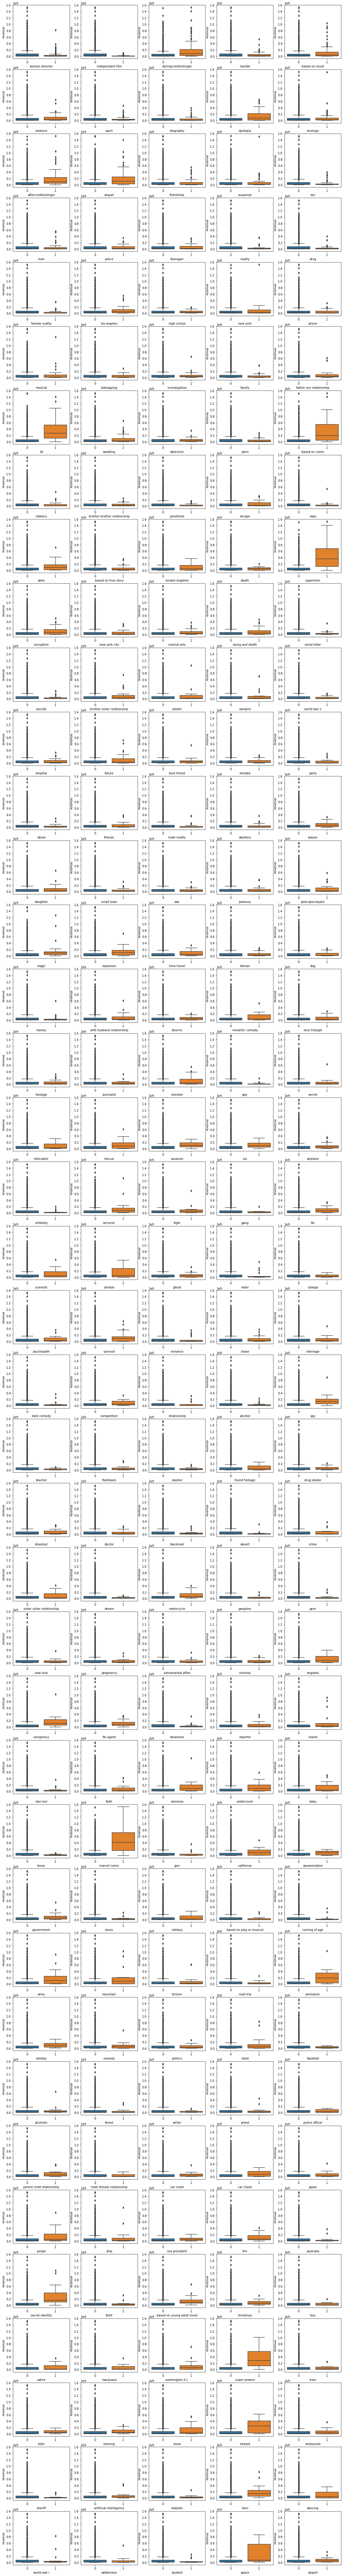

In [138]:
fig, ax = plt.subplots(40,5, figsize=(20,160))
for x in range(40):
    for y in range(5):
        sns.boxplot(x=keywords[(x*5)+y], y='revenue', data=keywords_df, ax=ax[x][y])

It is a lot of boxplots. Let's find meaningful keywords based on those plots.

 - women director: it is the most popular keyword and as we can see movies with women director have lower box office revenue.
 - independent film: second most popular keyword. If a movie is independent film, there is no chance for a real profit.
 - duringcreditsstinger: if a movie have scene after some credits, its revenue is way higher.
 - murder: [skip it]
 - based on novel: if a movie is based on novel, its revenue is higher.
 - violence: if a movie is violent, it has a slightly higher revenue.
 - sport: [skip it]
 - biography: doesn't really matter.
 - dystopia: if it is a dystopian movie, it will make more money.
 - revenge: doesn't really matter. (There is only one movie about revange that had huge box office revenue.)
 - aftercreditsstinger: if there is a scene after all credits, then movie will have a bigger revenue.
 - sequel: if a movie is a sequel, it will make more money.
 - frendship: doesn't really matter.
 - suspense: doesn't really matter. (There is only one suspense movie that had huge box office revenue.)
 - sex: [skip it]
 - love: [skip it]
 - police: doesn't really matter.
 - teenager: doesn't really matter.
 - nudity: [skip it]
 - drug: [skip it]
 - female nudity: [skip it]
 - los angeles: if action of the movie takes place in Los Angeles, then the movie has greater chance for a little bigger revenue.
 - high school: doesn't really matter.
 - new york: if action of the movie takes place in New York, then movie has greater chance for a little bigger revenue.
 - prison: doesn't really matter.
 - musical: doesn't really matter.
 - kidnapping: doesn't really matter.
 - invastigation: doesn't really matter.
 - family: doesn't really matter.
 - father son relationship: doesn't really matter.
 - 3d: if a movie is in 3D, it will definitely have a bigger revenue.
 - wedding: doesn't really matter.
 - detective: doesn't really matter.
 - paris: doesn't really matter.
 - based on comic: if movie is based on comic, it will definitely have a bigger revenue.
 - robbery: doesn't really matter.
 - brother brother relationship: doesn't really matter.
 - prostitute: doesn't really matter.
 - escape: if a movie have keyword 'escape', then it has small chance for a slightly bigger revenue.
 - rape: doesn't really matter.
 - alien: if a movie is about alien(s), it should have bigger revenue.
 - based on true story: doesn't really matter. (I thought this keyword would make a difference.)
 - london england: if action of a movie takes place in London, England, then movie should have a bigger revenue. It is probably connected with the fact that movies produced in UK have bigger revenue.
 - death: doesn't really matter.
 - superhero: if a movie is about superhero, it will definitely have a bigger revenue. In most cases connected with 'based on comic'.
 - corruption: if a movie is about corruption, it should have a slightly bigger revenue.
 - new york city: doesn't really matter. ('new york' and 'new york city' should have been merge into one keyword.)
 - martial arts: if there are some martial arts in a movie, then movie has a very small chance for a slightly better revenue.
 - dying and death: if a movie is about dying and death, it has small chance for a slightly bigger revenue. (probably most films should have this keyword.)
 - serial killer: [skip it]
 - suicide: [skip it]
 - brother sister relationship: if a movie is about brother sister relationship, it has a small chance for a slightly bigger revenue.
 - soldier: if a movie is about soldier, it has a small chance for a slightly bigger revenue.
 - vampire: doesn't really matter.
 - world war ii: doesn't really matter. (and should have!)
 - hospital: doesn't really matter.
 - future: if a movie is about future times, it has a chance for bigger revenue.
 - best friend: doesn't really matter.
 - remake: doesn't really matter.
 - party: doesn't really matter.
 - blood: [skip it]
 - friends: doesn't really matter.
 - male nudity: [skip it]
 - adultery: doesn't really matter.
 - lawyer: if a movie is about lawyer, it has a chance for bigger revenue.
 - daughter: doesn't really matter. (maybe a little bit.)
 - small town: doesn't really matter.
 - war: doesn't really matter.
 - jealousy: doesn't really matter.
 - post-apocalyptic: if it is a post-apocalyptic movie, it has a slightly better chance for a small improvement with revenue.
 - magic: if a movie is about magic, it has a slightly better chance for a slightly bigger revenue.
 - explosion: if a movie contains explosions, it has a chance for bigger revenue.
 - time travel: if a movie is about time travel, it has a slightly better chance for slightly bigger revenue.
 - hitman: doesn't really matter.
 - dog: doesn't really matter.
 - money: doesn't matter at all.
 - wife husband relationship: doesn't really matter.
 - divorce: doesn't really matter.
 - romantic comedy: if a movie is a romantic comedy, then it has a chance for bigger revenue.
 - love triangle: doesn't really matter.
 - hostage: doesn't really matter.
 - journalist: doesn't really matter.
 - monster: if a movie is about monster, it has a chance for bigger revenue.
 - gay: doesn't matter.
 - secret: doesn't really matter.
 - helcopter: if there is a helicopter in a movie, then movie has a slight chance for bigger revenue.
 - rescue: if a movie is about rescue, it should have a bigger revenue.
 - assassin: if a movie is about assassin, it should have a bigger revenue.
 - cia: if a movie is about cia, it should have bigger revenue.
 - airplane: doesn't really matter.
 - infidelity: [skip it]
 - terrorist: if a movie is about terrorist, it has a chance for bigger revenue.
 - fight: if a movie has any fights in it, it has a slightly higher chance for a slightly bigger revenue.
 - gang: doesn't matter.
 - fbi: if a movie is about fbi, it should have a bigger revenue.
 - scientist: if a movie is about scientists, it should have a bigger revenue.
 - zombie: if a movie is about zombie, it will definitely have a bigger revenue.
 - ghost: doesn't matter.
 - hotel: [skip it]
 - college: doesn't matter.
 - psychopath: if a movie is about psychopath, it has a slightly higher chance for a slightly bigger revenue.
 - survival: if a movie is about surviving, it should have a bigger revenue.
 - romance: doesn't really matter.
 - chace: doesn't matter.
 - marriage: doesn't matter. (maybe a little bit.)
 - dark comedy: [skip it]
 - competition: if a movie is about competition, it has a slightly higher chance for a slightly bigger revenue.
 - relationship: doesn't really matter.
 - alcohol: doesn't matter.
 - spy: if it is a spy movie, it should have a bigger revenue.
 - teacher: doesn't matter.
 - flashback: doesn't matter.
 - slasher: doesn't matter.
 - found footage: if in a movie someone finds some footage, then movie has a slightly higher chance for a slightly bigger revenue.
 - drug dealer: doesn't matter.
 - shootout: doesn't matter. (maybe a little bit.)
 - doctor: doesn't really matter.
 - blackmail: doesn't matter.
 - desert: [skip it]
 - crime: doesn't really matter.
 - sister sister relationship: if a movie is about sisters relationship, it has a chance for bigger revenue.
 - dream: [skip it]
 - motorcycle: if a movie has any/is about motorcycle, then it has a slightly higher chance for a slightly bigger revenue.
 - gangster: doesn't matter.
 - gore: [skip it]
 - new love: doesn't matter.
 - pregnancy: doesn't matter.
 - extramarital affair: doesn't matter.
 - criminal: doesn't matter.
 - england: if action of a movie takes place in England (or is somehow connected to it), then movie should have a bigger revenue.
 - conspiracy: if a movie is about conspiracy, it should have a bigger revenue.
 - fbi agent: if a movie is about fbi agent, it has a chance for bigger revenue.
 - reporter: doesn't matter. (maybe a little bit.)
 - island: if action of a movie takes place on island, it has a chance for slightly bigger revenue.
 - neo-noir: [skip it]
 - faith: if a movie is about faith, it has a chance for slightly bigger revenue.
 - amnesia: if in a movie someone has amnesia, it should have a bigger revenue.
 - undercover: if a movie is about someone undercover, it should have a bigger revenue.
 - baby: if a movie is about baby, it has a chance for bigger revenue.
 - texas: [skip it]
 - marvel comic: if a movie is based on Marvel comic, it will definitely have a big revenue.
 - gun: doesn't matter.
 - california: if action of a movie takes place in California, it should have a bigger revenue.
 - assassination: if a movie is about assassination, it should have a bigger revenue.
 - government: if a movie is about government, it has a chance for slightly bigger revenue.
 - music: doesn't matter.
 - military: if action of a movie is connected with military, then movie has a small chance for slightly higher revenue.
 - based on play or musical: doesn't matter.
 - coming of age: [skip it]
 - army: if a movie is about army, it should have a bigger revenue.
 - mountain: if action of a movie takes place in mountain, then movie should have a bigger revenue.
 - torture: doesn't matter.
 - road trip: doesn't matter.
 - animation: if it is an animated movie, it will definitely have a bigger revenue.
 - holiday: if action of a movie takes place on holiday, then movie has a chance for bigger revenue.
 - comedy: if it is comedy movie, it has a chance for slightly higher revenue.
 - politics: doesn't matter.
 - robot: if a movie is about robot(s), it has a small chance for slightly higher revenue.
 - baseball: doesn't matter.
 - alcoholic: doesn't matter.
 - forest: doesn't matter.
 - writer: doesn't matter.
 - priest: doesn't matter.
 - police officer: if a movie is about police officer, it has a vary small chance for slightly higher revenue.
 - parent child relationship: if a movie is about parent child relationship, it has a small chance for slightly higher revenue.
 - male female relationship: doesn't matter.
 - car crash: if a movie is about car crash, then it has a very small chance for slightly higher revenue.
 - car chase: if in a movie is car chase, then movie has a chance for slightly higher revenue.
 - japan: doesn't matter.
 - jungle: if action of a movie takes place in jungle, then movie has a chance for slightly higher revenue.
 - ship: doesn't matter.
 - usa president: if a movie is about USA president, then it has a small chance for slightly higher revenue.
 - fire: if movie contains fire, then it has a small chance for slightly higher revenue.
 - australia: [skip it]
 - secret identity: if a movie is about someone with secret identity, then it should have a bigger revenue.
 - thief: doesn't matter.
 - based on young adult novel: if a movie is based on young adult novel, then it has a chance for bigger revenue.
 - christmas: if action of a movie takes place on Christmas, then movie has a small chance for bigger revenue.
 - kiss: doesn't matter.
 - satire: doesn't matter.
 - marijuana: doesn't matter.
 - washington d.c.: if action of a movie takes place in Washington D.C., then movie has a small chance for slightly bigger revenue.
 - super powers: if a movie is about super powers, then it definitely have a bigger revenue.
 - train: doesn't matter.
 - killer: doesn't matter.
 - training: doesn't matter.
 - snow: if there is snow in a movie, then movie has a small chance for slightly bigger revenue.
 - mutant: if a movie is about mutant, then it will definitely have a bigger revenue.
 - restaurant: if a movie is about restaurant, then it has a small chance for slightly bigger revenue.
 - sheriff: [skip it]
 - artificial intelligence: unfortunately, it doesn't matter.
 - movster: doesn't matter.
 - hero: if a movie is about some hero, then it will definitely have a bigger revenue.
 - dancting: if a movie is about dancing, than it has a chance for bigger revenue.
 - world war i: [skip it]
 - wilderness: doesn't matter.
 - student: [skip it]
 - space: if action of a movie takes place in space, then movie has a chance for bigger revenue.
 - airport: if action of a movie takes place in airport, then movie has a small chance for slightly higher revenue.

In [139]:
# From above list let's select keywords that I thought have some impact on revenue.
keywords = ['woman director',
            'independent film',
            'duringcreditsstinger',
            'based on novel',
            'violence',
            'dystopia',
            'aftercreditsstinger',
            'sequel',
            'los angeles',
            'new york',
            '3d',
            'based on comic',
            'escape',
            'alien',
            'london england',
            'superhero',
            'corruption',
            'martial arts',
            'dying and death',
            'brother sister relationship',
            'soldier',
            'future',
            'lawyer',
            'post-apocalyptic',
            'magic',
            'explosion',
            'time travel',
            'romantic comedy',
            'monster',
            'helicopter',
            'rescue',
            'assassin',
            'cia',
            'terrorist',
            'fight',
            'fbi',
            'scientist',
            'zombie',
            'psychopath',
            'survival',
            'competition',
            'spy',
            'found footage',
            'sister sister relationship',
            'motorcycle',
            'england',
            'conspiracy',
            'fbi agent',
            'island',
            'faith',
            'amnesia',
            'undercover',
            'baby',
            'marvel comic',
            'california',
            'assassination',
            'government',
            'military',
            'army',
            'mountain',
            'animation',
            'holiday',
            'comedy',
            'robot',
            'police officer',
            'parent child relationship',
            'car crash',
            'car chase',
            'jungle',
            'usa president',
            'fire',
            'secret identity',
            'based on young adult novel',
            'christmas',
            'washington d.c.',
            'super powers',
            'snow',
            'mutant',
            'restaurant',
            'hero',
            'dancing',
            'space',
            'airport'
           ]

# List is longer than I assume.

In [140]:
# Create from selected keywords new features
train = list_one_hot_encoding(train, 'Keywords', keywords)

In [141]:
# Remove keywords_df from memory
del keywords_df

## cast

Cast of a movie.

Dictionary of: 
 - cast_id:
 - character: character name.
 - credit_id:
 - gender: gender of character/actor. (1 - female, 2 - men, 0 - unknown (male or female))
 - id: id of an actor.
 - name: name of an actor.
 - order: importance of a character (from most to less important).
 - profile_path: path to photo of an actor.
 

In [142]:
# Parse cast data.
train['cast'] = train['cast'].replace('\'','\"').apply(lambda x: ast.literal_eval(x) if pd.notna(x) else {})

**How many people are in the cast?**

count    3000.000000
mean       20.603667
std        16.629635
min         0.000000
25%        11.000000
50%        16.000000
75%        24.000000
max       156.000000
Name: cast, dtype: float64


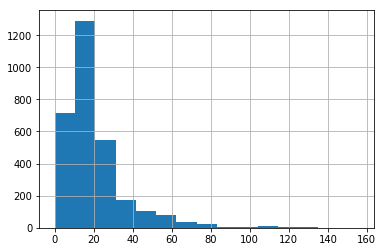

In [143]:
print(train['cast'].apply(len).describe())
train['cast'].apply(len).hist(bins=15)

On average, there are 20 actors in the cast (+/- 16). The maximum number of actors in the cast is 156 people.

**Which movies have over 80 actors in the cast?**

In [144]:
(train[train['cast'].apply(len) >= 80][['original_title','release_date','revenue','cast']]
 .assign(cast_count=lambda x: x['cast'].apply(len)).sort_values(by='cast_count'))

original_title release_date  \
1718                                    Boris - Il film   2011-04-01   
2018                            Guardians of the Galaxy   2014-07-30   
2527                                            Boyhood   2014-06-05   
941                                          Maleficent   2014-05-28   
2737                                            Spectre   2015-10-26   
2402                                    Starsky & Hutch   2004-03-05   
1377                               The Princess Diaries   2001-08-03   
471                                        The Hangover   2009-06-05   
1195                                         Green Zone   2010-03-11   
2269                                     American Pie 2   2001-08-10   
1660                                 North by Northwest   1959-07-07   
1477  Percy Jackson & the Olympians: The Lightning T...   2010-02-01   
2860                                             Gandhi   1982-11-30   
2038                                        Wall Street   1987-12-10   
846                                                Gold   2016-12-22   
1597                             Not Another Teen Movie   2001-12-07   
2024                                Crank: High Voltage   2009-04-16   
2364                                     Into the Storm   2014-08-06   
2412                                           Red Dawn   2012-11-21   
1565                                      The Big Short   2015-12-11   
1143                                         Casablanca   1942-11-26   
2793                                              Ted 2   2015-06-25   
462                                             Contact   1997-07-11   
1630                      Transformers: The Last Knight   2017-06-21   
2639                                        The Dilemma   2011-01-13   
2266                                    What Women Want   2000-12-15   
686                                            War Dogs   2016-08-17   
832                                       Batman Begins   2005-06-10   
2305                                        Hot Pursuit   2015-05-08   
896                                             Step Up   2006-08-11   
1182                                  The Fifth Element   1997-05-07   
1126                                       The Avengers   2012-04-25   
2120                                          Spartacus   1960-10-06   
2454                                     The Internship   2013-06-07   
2190                                          The Women   1939-01-01   
683                                Paul Blart: Mall Cop   2009-01-15   
1012                                      Pitch Perfect   2012-09-28   
1613                             The Life of David Gale   2003-02-21   
1673                                    The Dark Knight   2008-07-16   
684                                Beauty and the Beast   2017-03-16   

         revenue                                               cast  \
1718     1248748  [{'cast_id': 1003, 'character': 'Ren√© Ferrett...   
2018   773328629  [{'cast_id': 1, 'character': 'Peter Quill / St...   
2527    44349000  [{'cast_id': 3, 'character': 'Mason', 'credit_...   
941    758539785  [{'cast_id': 7, 'character': 'Maleficent', 'cr...   
2737   880674609  [{'cast_id': 1, 'character': 'James Bond', 'cr...   
2402   170268750  [{'cast_id': 1, 'character': 'David Starsky', ...   
1377   165335153  [{'cast_id': 10, 'character': 'Amelia "Mia" Th...   
471    459270619  [{'cast_id': 1, 'character': 'Phil Wenneck', '...   
1195    94882889  [{'cast_id': 3, 'character': 'Roy Miller', 'cr...   
2269   287553595  [{'cast_id': 1, 'character': 'Jim Levenstein',...   
1660    13275000  [{'cast_id': 3, 'character': 'Roger O. Thornhi...   
1477   226497209  [{'cast_id': 1, 'character': 'Percy Jackson', ...   
2860    77737889  [{'cast_id': 7, 'character': 'Mahatma Gandhi',...   
2038    43848069  [{'cast_id': 8, 'character': 'Bud Fox', 'credi...   
846      7227038  [{'ca

There are 40 movies with 80 or more actors. Each cast includes all actors who played in the movie, no matter how big or small their role were.

**What are the most popular words in characters names?**

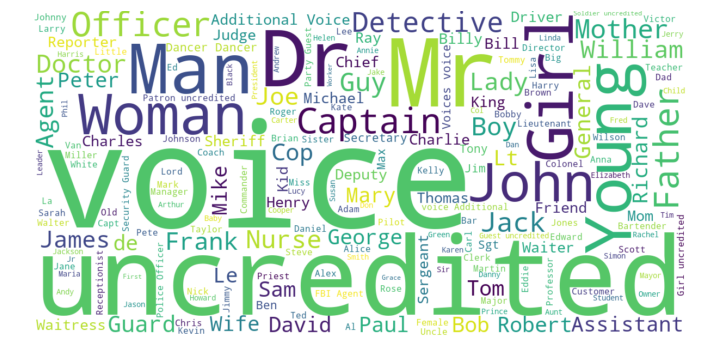

In [145]:
# Get all character names
text = ','.join(train['cast'].apply(lambda x: [actor['character'] for actor in x]).apply(lambda x: ','.join(x)))

# Generate WordCloud from characters names
wordcloud = WordCloud(max_font_size=None, background_color='white', width=1200, height=600).generate(text)

# Display wordcloud
plt.figure(figsize=(12,6))
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis('off')
plt.show()

**What are the top 25 most popular character names?**

In [146]:
Counter(text.split(',')).most_common(25)

[('', 845),
 ('Himself', 610),
 ('Herself', 155),
 ('Dancer', 144),
 ('Additional Voices (voice)', 100),
 ('Doctor', 77),
 ('Reporter', 70),
 ('Waitress', 69),
 ('Nurse', 65),
 ('Bartender', 55),
 ('Jack', 54),
 ('Debutante', 54),
 ('Security Guard', 50),
 ('Paul', 48),
 ('Frank', 44),
 ('Charlie', 41),
 ('Waiter', 41),
 ('Cop', 40),
 ('Priest', 40),
 ('Student', 39),
 ('Mary', 39),
 ('Sam', 38),
 ('John', 38),
 ('David', 38),
 ('Tony', 38)]

The most popular character name is for 'actors' that don't even get a character name (probably extras). Next places are for Himself/Herself. Generally, most character names from the list are names describing job position. Probably they are characters that play meaningless roles in the movie. 

The most popular name on the list is Jack.

In [147]:
# Count gender values form 'df' dataframe from 'feature' column.
# Returns Series with gender value counts.
def gender_counts(df, feature):
    gender_count = pd.Series(data=[0,0,0], index=[0,1,2])
    for row in df[feature]:
        for person in row:
            gender_count.loc[person['gender']] += 1
    return gender_count

**Which gender is the most popular among actors?**

0    20329
1    13533
2    27949
dtype: int64


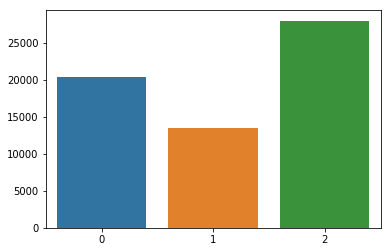

In [148]:
tmp = gender_counts(train, 'cast')
print(tmp)

sns.barplot(x=tmp.index, y=tmp.values)

The largest group represents actors (2 - male). The actresses are half as much (1 - female). Group describe as 0 represents unknown gender (male or female) which is probably connected with people that play extras in mostly one movie.

In [149]:
# Create new dataframe with aggregated actors data.
# Returns new dataframe with columns:
#  [id, name, movies_played, mean_gender, mean_order, start_year, end_year, 
#   mean_movie_popularity, mean_movie_budget, mean_movie_revenue, mean_movie_profit]
def aggregate_actors_data(df):
    
    #Create new dataframe for actors data
    actors_df = pd.DataFrame(columns=['id','name','movies_played','mean_gender','mean_order',
                                      'start_year','end_year','mean_movie_popularity','mean_movie_budget',
                                      'mean_movie_revenue','mean_movie_profit'])
    
    # Iterate through movies
    for index, movie in df.iterrows():
        
        #Iterate through cast list
        for actor in movie['cast']:
            
            #Chack if actor is already in dataframe
            if actors_df['id'].isin([actor['id']]).sum() == 0:
                
                # If not create new entry for actor
                actors_df = actors_df.append({'id': actor['id'],
                                              'name': actor['name'],
                                              'movies_played': 1,
                                              'mean_gender': actor['gender'],
                                              'mean_order': actor['order'],
                                              'start_year': movie['release_date_year'],
                                              'end_year': movie['release_date_year'],
                                              'mean_movie_popularity': movie['popularity'],
                                              'mean_movie_budget': movie['budget'],
                                              'mean_movie_revenue': movie['revenue'],
                                              'mean_movie_profit': movie['profit']
                                             },
                                             ignore_index=True)
            else:
                # If exists, then update values
                actors_df.loc[actors_df['id'] == actor['id'], 'movies_played'] += 1
                actors_df.loc[actors_df['id'] == actor['id'], 'mean_gender'] += actor['gender']
                actors_df.loc[actors_df['id'] == actor['id'], 'mean_order'] += actor['order']
                actors_df.loc[actors_df['id'] == actor['id'], 'start_year'] = min(actors_df.loc[actors_df['id'] == actor['id'], 'start_year'].values[0], 
                                                                                  movie['release_date_year'])
                actors_df.loc[actors_df['id'] == actor['id'], 'end_year'] = max(actors_df.loc[actors_df['id'] == actor['id'], 'end_year'].values[0], 
                                                                                  movie['release_date_year'])
                actors_df.loc[actors_df['id'] == actor['id'], 'mean_movie_popularity'] += movie['popularity']
                actors_df.loc[actors_df['id'] == actor['id'], 'mean_movie_budget'] += movie['budget']
                actors_df.loc[actors_df['id'] == actor['id'], 'mean_movie_revenue'] += movie['revenue']
                actors_df.loc[actors_df['id'] == actor['id'], 'mean_movie_profit'] += movie['profit']

    # Get mean values
    actors_df['mean_gender'] = actors_df['mean_gender'] / actors_df['movies_played']
    actors_df['mean_order'] = actors_df['mean_order'] / actors_df['movies_played']
    actors_df['mean_movie_popularity'] = actors_df['mean_movie_popularity'] / actors_df['movies_played']
    actors_df['mean_movie_budget'] = actors_df['mean_movie_budget'] / actors_df['movies_played']
    actors_df['mean_movie_revenue'] = actors_df['mean_movie_revenue'] / actors_df['movies_played']
    actors_df['mean_movie_profit'] = actors_df['mean_movie_profit'] / actors_df['movies_played']
    
    # Change data types to numeric ones.
    actors_df['id'] = actors_df['id'].astype('int64')
    actors_df['movies_played'] = actors_df['movies_played'].astype('int64')
    actors_df['mean_gender'] = actors_df['mean_gender'].astype('float64')
    actors_df['mean_order'] = actors_df['mean_order'].astype('float64')
    actors_df['mean_movie_popularity'] = actors_df['mean_movie_popularity'].astype('float64')
    actors_df['mean_movie_budget'] = actors_df['mean_movie_budget'].astype('float64')
    actors_df['mean_movie_revenue'] = actors_df['mean_movie_revenue'].astype('float64')
    actors_df['mean_movie_profit'] = actors_df['mean_movie_profit'].astype('float64')
    
    # Return new dataframe
    return actors_df

In [160]:
# Get aggregated actors data
#actors_df = aggregate_actors_data(train)

# Save actors dataframe to file
#actors_df.to_pickle('./data/actors.pkl')

# Load actors dataframe from file
actors_df = pd.read_pickle('./data/actors.pkl')

# Show sample actors data
actors_df.sample(10)

id               name  movies_played  mean_gender  mean_order  \
15231  1140044        Kevin Cheng              1          0.0        18.0   
22778   120724        Jaden Smith              2          2.0         0.0   
14017  1844707      Julianna Rose              2          1.0        26.0   
9001   1229130      George Malpas              1          2.0        42.0   
15672   557865        Ugo Paletti              1          0.0         3.0   
25412  1485819         Joel Davis              1          0.0        14.0   
32558   146423  Ralph A. Recchia               2          0.0        82.0   
18090     4122     Helmut Dantine              1          2.0        35.0   
2775     77993         Parry Shen              2          2.0        21.5   
21452  1153611   Bernie Gigliotti              1          0.0        17.0   

       start_year  end_year  mean_movie_popularity  mean_movie_budget  \
15231        2013      2013               1.541050                0.0   
22778        2010      2013              11.219212         85000000.0   
14017        2011      2013               7.732920         35000000.0   
9001         1989      1989              14.788987         48000000.0   
15672        1966      1966              11.322173           800000.0   
25412        2011      2011               9.832342         40000000.0   
32558        2012      2014               7.360356         57500000.0   
18090        1942      1942              13.916101           878000.0   
2775         2010      2013              13.328832         20850000.0   
21452        1992      1992               4.337214                0.0   

       mean_movie_revenue  mean_movie_profit  
15231             37884.0            37884.0  
22778         300847761.0        215847761.0  
14017          85019286.0         50019286.0  
9001          474171806.0        426171806.0  
15672            921548.0           121548.0  
25412          51070807.0         11070807.0  
32558         102704488.5         45204488.5  
18090          10462500.0          9584500.0  
2775           43405758.0         22555758.0  
21452          17530973.0         17530973.0

**Which names are the most popular among actors names?**

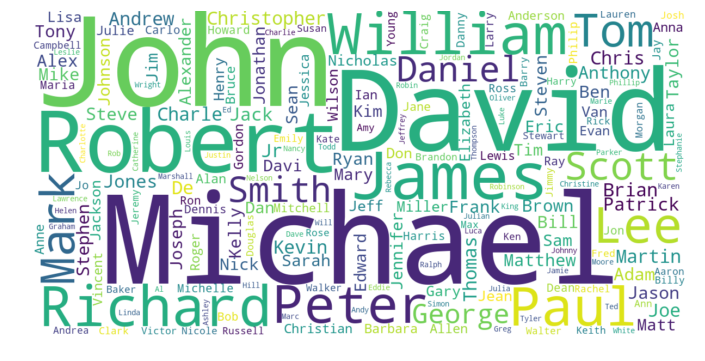

In [161]:
# Get all actors names
text = ','.join(actors_df['name'])

# Generate WordCloud from actors names
wordcloud = WordCloud(max_font_size=None, background_color='white', width=1200, height=600).generate(text)

# Display wordcloud
plt.figure(figsize=(12,6))
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis('off')
plt.show()

**How many actors are in dataframe?**

In [162]:
print('Actors number: ', actors_df.shape[0])

Actors number:  38760


**How many actors played in only one movie?**

In [163]:
print('Number of actors that played in only one movie: ', actors_df[actors_df['movies_played'] == 1].shape[0])

Number of actors that played in only one movie:  29446


In [164]:
# Lets drop all actors that played in only one movie.
# (Those actors have no meaningful informations. Would only obscure the real picture)
actors_df = actors_df.drop(actors_df[actors_df['movies_played'] == 1].index, axis=0)

**Which actor/actress has played in largest number of movies?**

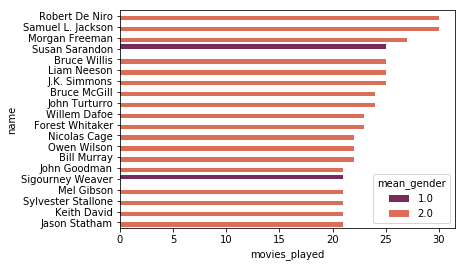

In [165]:
g = sns.barplot(y='name', x='movies_played', hue='mean_gender', 
                data=actors_df.sort_values(by='movies_played', ascending=False).head(20), palette='rocket')

Robert De Niro and Samuel L. Jackson played in the largest number of movies, which is 30. It is worth mentioning that on the top 25 list there are only two actresses: Susan Sarandon (4th place with 25 movies) and Sigourney Weaver (20th place with 21 movies). The rest are male actors.

**How many people are each gender?**

In [166]:
actors_df['mean_gender'].value_counts()

2.0    5188
1.0    2451
0.0    1675
Name: mean_gender, dtype: int64

Actresses (1) are half as numerous as actors (2). Also, there is a third group (0) that represents unknown gender.

**Who played in more movies, actors or actresses?**

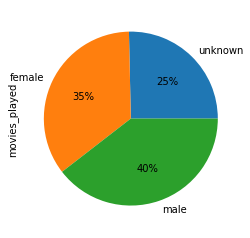

In [167]:
actors_df.groupby(by='mean_gender')['movies_played'].mean().plot(kind='pie', legend=False, autopct='%1.0f%%', 
                                                                 labels=['unknown','female','male'])

Slight advantage in favour of actors. But we need to remember that in unknown group may be more actresses and the plot would look differently and about that actresses are less numerous than actors.

**Who plays more important roles on average, acotrs or actresses?**

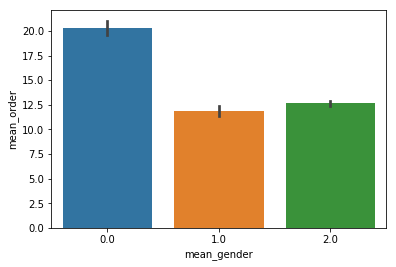

In [168]:
sns.barplot(x='mean_gender', y='mean_order', data=actors_df)

Actresses slightly often play more important roles than actors. But we need to remember how numerous each group is. In this plot we can see that unknown group (0) genrerally should be treated as extras. And this is the confirmation of what I already said earlier about this group.

**Which actor most often played the most important roles?**

Excluding all actors that played in less than 8 productions.

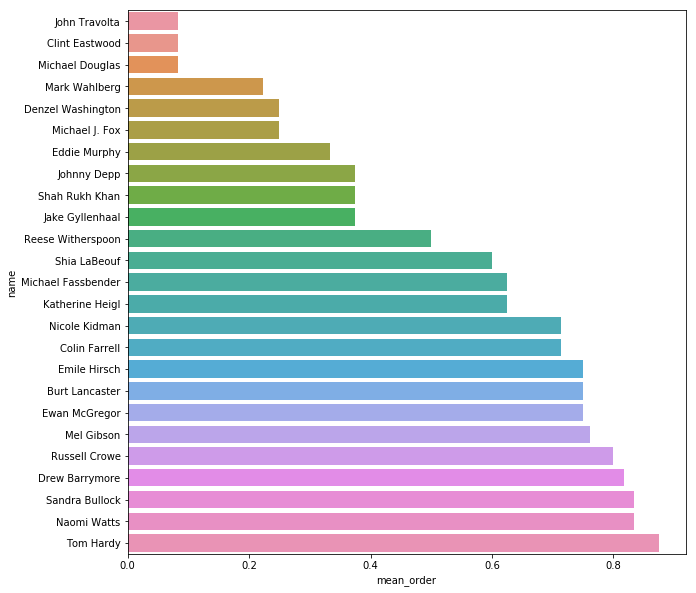

In [169]:
tmp = actors_df[actors_df['movies_played'] > 7].sort_values(by='mean_order').head(25)

plt.figure(figsize=(10,10))
sns.barplot(x='mean_order', y='name', data=tmp)

John Travolta, Clint Eastwood, Michael Douglas almost allways play the main characters.

**Which actor is/was the longest professionally active?**

Excluding all actors that played in less than 8 productions.

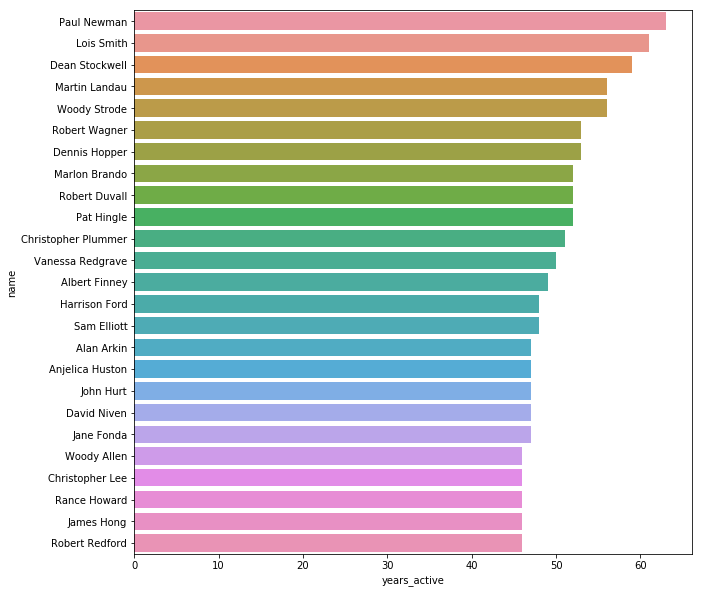

In [170]:
# Calculate years of professional activity
actors_df = actors_df.assign(years_active=lambda x: x['end_year'] - x['start_year'])

plt.figure(figsize=(10,10))
tmp = actors_df[actors_df['movies_played'] > 7].sort_values(by='years_active', ascending=False).head(25)

sns.barplot(x='years_active', y='name', data=tmp)

Based on the plot Paul Newman was the longest professionally active actor (63 years difference between his first movie and last). But when we take a closer look, his last movie in which he was credited was released in 2017 and he died in 2008. So this movie contains his archival footage not his live work. Taking this into account, the longest professionally active actor or should I say actress, should be Lois Smith. She is still living (she's 88 years old) and still playing in the movies. From our data she has been professionally active for 61 years.

**Which movies are the most popular on average beased on actor that played in it?**

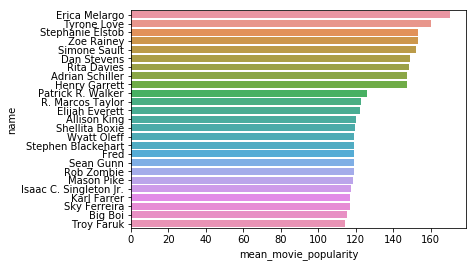

In [171]:
sns.barplot(x='mean_movie_popularity', y='name', data=actors_df.sort_values(by='mean_movie_popularity', 
                                                                            ascending=False).head(25))

This is probably not what I suspected. I need to select only actors that played in more movies than only just a couple.

To be sure let's check in how many movies all of above actors played.

In [172]:
actors_df.sort_values(by='mean_movie_popularity',ascending=False).head(25)[['name','movies_played']]

name  movies_played
11499           Erica Melargo              2
11497             Tyrone Love              2
11418        Stephanie Elstob              2
11380              Zoe Rainey              2
11390            Simone Sault              2
11366             Dan Stevens              2
2477              Rita Davies              2
11370         Adrian Schiller              2
11383           Henry Garrett              2
25028       Patrick R. Walker              2
11796        R. Marcos Taylor              2
25036          Elijah Everett              2
25031            Allison King              2
25030          Shellita Boxie              2
28310             Wyatt Oleff              2
28318      Stephen Blackehart              2
28316                    Fred              2
28311               Sean Gunn              2
28320              Rob Zombie              2
25053              Mason Pike              2
29281  Isaac C. Singleton Jr.              2
11492             Karl Farrer              3
23048            Sky Ferreira              2
25023                 Big Boi              2
25058              Troy Faruk              2

All of them played only in 2 movies.

**Which movies are the most popular on average beased on actor that played in it?**

Excluding all actors that played in less than 10 productions.

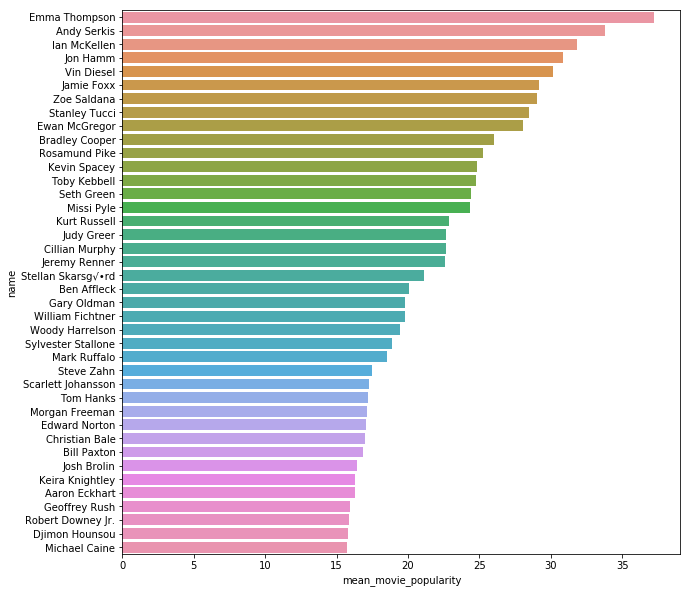

In [173]:
tmp = actors_df[actors_df['movies_played'] >= 10].sort_values(by='mean_movie_popularity', ascending=False).head(40)
plt.figure(figsize=(10,10))
sns.barplot(x='mean_movie_popularity', y='name', data=tmp)

Emma Thompson is in the lead. Second and third places belongs to actors that played in The Lord of the Rings Trilogy. Andy Serkis is before Ian McKellen probably because he also played in Planet of the Apes movies. Jon Hamm is surprise to me in his fourth position. It is probably connected with popularity of Baby Driver. Jamie Foxx also played in this movie and he is also in high place. Between them is Vin Disel with his popularity based on Fast & Furious series. There are also numerous actors that played in superheros movies which was obvious.

**Which actor played in movies with the biggest revenue and the biggest budget?**

Excluding all actors that played in less than nine movies.

In [174]:
tmp = actors_df[actors_df['movies_played'] > 8].sort_values(by='mean_movie_revenue', ascending=False).head(50)

traces = []
for _, row in tmp.iterrows():
    traces.append(go.Scatter(
        x=[row['mean_movie_budget']],
        y=[row['mean_movie_revenue']],
        name=row['name'],
        mode='markers'
    ))

layout = go.Layout(
    title = go.layout.Title(text='Actors based on mean movies revenue and budget'),
    xaxis = go.layout.XAxis(title=go.layout.xaxis.Title(text='Mean movie budget')), 
    yaxis = go.layout.YAxis(title=go.layout.yaxis.Title(text='Mean movie revenue'))
)

fig = go.Figure(data=traces, layout=layout)
iplot(fig, show_link=False)

# Seaborn version (no interactive)
#plt.figure(figsize=(16,10))
#sns.stripplot(x='mean_movie_budget', y='mean_movie_revenue', hue='name', data=tmp)

The unquestionable king is Andy Serkis. Movies in which he plays have the biggest budget and the biggest revenue. Just to remind you, he played among others Gollum in The Lord of the Rings trilogy and in Hobbit trilogy, Caesar in Planet of the Apes trilogy or in Avengers: Age of Ultron. Movies with Andy Serkis have around 50M dollars advantage over movies with Orlando Bloom who is in second place.

**Which actor played in movies with the largest profits?**

Excluding all actors that played in less than 8 productions.

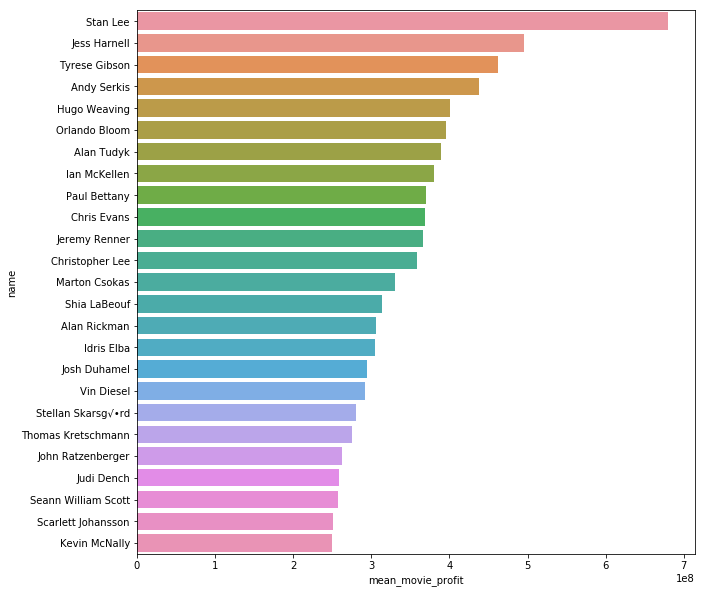

In [175]:
tmp = actors_df[actors_df['movies_played'] > 7].sort_values(by='mean_movie_profit', ascending=False).head(25)

plt.figure(figsize=(10,10))
sns.barplot(x='mean_movie_profit', y='name', data=tmp)

Stan Lee with his cameo appearances in Marvel movies based on his comics is in first place with huge advantage. Second place belongs to Jess Harnell who played in Transformers movies. In third is Tyrese Gibson who played in Fast & Furious movies.

In [176]:
# Get IDs for top 100 actors that have biggest mean movie revenue.
# Excluding all actros that played in less than nine movies.
ids = (actors_df[actors_df['movies_played'] > 8]
       .sort_values(by='mean_movie_revenue', ascending=False)['id'].head(100).values.tolist())

In [177]:
# Check if person worked in a movie.
def is_person_in_cast(cast, ids):
    for person in cast:
        if person['id'] in ids:
            return True
    return False

In [178]:
# Create new feature indicating if in a movie played any of actors from the above list.
train['has_top_actor'] = train['cast'].apply(lambda x: is_person_in_cast(x, ids))

In [179]:
# Get top 6 actors
def top_actors(cast):
    actors = pd.Series(data=['', '', '', '', '', ''],
                       index=['actor0', 'actor1', 'actor2', 'actor3', 'actor4', 'actor5'])
    for n in range(min(6, len(cast))):
        actors.loc['actor{}'.format(n)] = cast[n]['name']
    return actors

In [180]:
# Create new feature for top 6 actors in the cast
train[['actor0', 'actor1', 'actor2', 'actor3', 'actor4', 'actor5']] = train['cast'].apply(top_actors)

In [181]:
# Remove actors dataframe to free memory
del actors_df

**Do movies with top actors really have bigger revenue?**

How numerous each group are:
 False    2214
True      786
Name: has_top_actor, dtype: int64


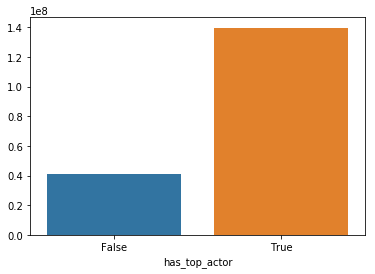

In [182]:
tmp = train.groupby(by='has_top_actor')['revenue'].mean()
sns.barplot(x=tmp.index, y=tmp.values)

print('How numerous each group are:\n', train['has_top_actor'].value_counts())

It is just a confirmation of what I said earlier. If actor from the list plays in the movie, then movie have bigger revenue. 

## crew

Crew responsible for producing a movie.

Dictionary of:
 - credit_id:
 - department: department to which job belongs to
 - gender: gender of crew member
 - id: id of crew member
 - job: job name
 - name: name of crew member
 - profile_path: path to image of crew member

In [183]:
# Parse crew data
train['crew'] = train['crew'].replace('\'','\"').apply(lambda x: ast.literal_eval(x) if pd.notna(x) else {})

**How many people are on average in the crew?**

count    3000.000000
mean       20.603667
std        16.629635
min         0.000000
25%        11.000000
50%        16.000000
75%        24.000000
max       156.000000
Name: cast, dtype: float64

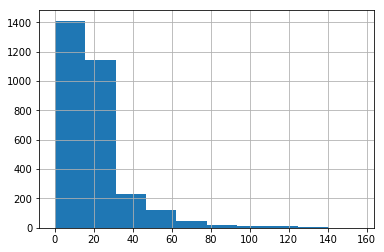

In [184]:
# Show histogram
train['cast'].apply(len).hist()

# Describe data
train['cast'].apply(len).describe()

On average there are 20 people (+/- 16) in movie crew.

**Which gender is the most popular in the crew?**

Gender counts:
 0    41787
1     6412
2    24898
dtype: int64


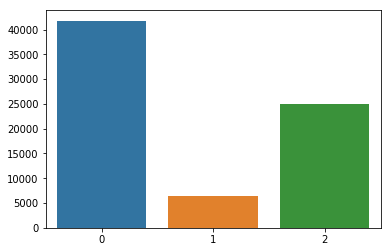

In [185]:
gender = gender_counts(train, 'crew')

print('Gender counts:\n', gender)

sns.barplot(x=gender.index, y=gender.values)

The most numerous gender is the unknown gender. They are probably not decision making crew members. Among the remaining people, men prevail. We could even say that crew mostly consists of men. I would assume that women in the crew are responsibe for more creative jobs, such as directing, writing, casting.

In [186]:
# Return list of departments
def get_departments(df):
    departments = set()
    for crew in df:
        for person in crew:
            departments.add(person['department'])
    return list(departments)

In [187]:
# Return list of jobs by departments
def get_jobs_by_department(df, departments):
    jobs = {department:set() for department in departments}
    for crew in df:
        for person in crew:
            jobs[person['department']].add(person['job'])
    return jobs

**What departments exist and what positions do they have?**

In [188]:
# Get list of departments
departments = get_departments(train['crew'])

# Get list of jobs by departments
jobs = get_jobs_by_department(train['crew'], departments)

# Print jobs
jobs

{'Actors': {'Stunt Double'},
 'Lighting': {'Best Boy Electric',
  'Best Boy Electrician',
  'Chief Lighting Technician',
  'Electrician',
  'Gaffer',
  'Lighting Artist',
  'Lighting Director',
  'Lighting Manager',
  'Lighting Supervisor',
  'Lighting Technician',
  'Master Lighting Artist',
  'Rigging Gaffer',
  'Rigging Grip',
  'Rigging Supervisor'},
 'Camera': {'Additional Camera',
  'Additional Photography',
  'Additional Still Photographer',
  'Aerial Camera',
  'Aerial Camera Technician',
  'Aerial Director of Photography',
  'Camera Department Manager',
  'Camera Intern',
  'Camera Loader',
  'Camera Operator',
  'Camera Supervisor',
  'Camera Technician',
  'Director of Photography',
  'Dolly Grip',
  'Epk Camera Operator',
  'First Assistant Camera',
  'Grip',
  'Helicopter Camera',
  'Key Grip',
  'Other',
  'Russian Arm Operator',
  'Second Unit Director of Photography',
  'Steadicam Operator',
  'Still Photographer',
  'Ultimate Arm Operator',
  'Underwater Camera',
  'Un

**How many different jobs are in each department?**

In [189]:
['{}: {}'.format(x, len(jobs[x])) for x in jobs]

['Actors: 1',
 'Lighting: 14',
 'Camera: 27',
 'Visual Effects: 51',
 'Art: 38',
 'Writing: 24',
 'Crew: 121',
 'Directing: 12',
 'Production: 35',
 'Editing: 16',
 'Sound: 48',
 'Costume & Make-Up: 38']

It will be wise to select only jobs that matter in production (jobs that have creative impact on the movie), for example 'Director'.

In [190]:
# I manually selected below jobs (by my intuition)
selected_jobs =  ['Casting', 'Original Music Composer', 'Screenplay', 'Director', 'Director of Photography', 
                  'Editor', 'Costume Design', 'Producer', 'Executive Producer']

From this point forward all analysis for crew will be restricted only to selected jobs.

In [191]:
# Get list of person jobs from crew data
def get_person_jobs(df, person_id):
    person_jobs = set()
    for crew in df:
        for person in crew:
            if person['id'] == person_id:
                person_jobs.add(person['job'])
    return list(person_jobs)

In [192]:
# Aggregate crew data and return new dataframe with features:
# [id, name, gender, job, movies_created, start_year, end_year, 
#  mean_movie_popularity, mean_movie_budget, mean_movie_revenue, mean_movie_profit]
def aggregate_crew_data(df, jobs):
    
    # Create new dataframe
    crew_df = pd.DataFrame(columns=['id', 'name', 'gender', 'job', 'movies_created', 'start_year', 'end_year',
                                    'mean_movie_popularity', 'mean_movie_budget','mean_movie_revenue',
                                    'mean_movie_profit'])
    
    # Iterate through movies
    for index, movie in df.iterrows():
        
        # Iterate through crew members
        for person in movie['crew']:
            
            # Check if person works in one of selected jobs
            if person['job'] in jobs:
            
                # Chack if person is already in dataframe
                if crew_df['id'].isin([person['id']]).sum() == 0:

                    # If not, then add new entry for crew member
                    crew_df = crew_df.append({'id': person['id'],
                                              'name': person['name'],
                                              'gender': person['gender'],
                                              'job': get_person_jobs(df['crew'], person['id']),
                                              'movies_created': 1,
                                              'start_year': movie['release_date_year'],
                                              'end_year': movie['release_date_year'],
                                              'mean_movie_popularity': movie['popularity'],
                                              'mean_movie_budget': movie['budget'],
                                              'mean_movie_revenue': movie['revenue'],
                                              'mean_movie_profit': movie['profit']
                                             },
                                             ignore_index=True)

                else:

                    # If exists, then update values
                    crew_df.loc[crew_df['id'] == person['id'], 'movies_created'] += 1
                    crew_df.loc[crew_df['id'] == person['id'], 'start_year'] = min(crew_df.loc[crew_df['id'] == person['id'], 'start_year'].values[0],
                                                                                   movie['release_date_year'])
                    crew_df.loc[crew_df['id'] == person['id'], 'end_year'] = max(crew_df.loc[crew_df['id'] == person['id'], 'end_year'].values[0],
                                                                                   movie['release_date_year'])
                    crew_df.loc[crew_df['id'] == person['id'], 'mean_movie_popularity'] += movie['popularity']
                    crew_df.loc[crew_df['id'] == person['id'], 'mean_movie_budget'] += movie['budget']
                    crew_df.loc[crew_df['id'] == person['id'], 'mean_movie_revenue'] += movie['revenue']
                    crew_df.loc[crew_df['id'] == person['id'], 'mean_movie_profit'] += movie['profit']
            
    # Get mean values
    crew_df['mean_movie_popularity'] = crew_df['mean_movie_popularity'] / crew_df['movies_created']
    crew_df['mean_movie_budget'] = crew_df['mean_movie_budget'] / crew_df['movies_created']
    crew_df['mean_movie_revenue'] = crew_df['mean_movie_revenue'] / crew_df['movies_created']
    crew_df['mean_movie_profit'] = crew_df['mean_movie_profit'] / crew_df['movies_created']
    
    # Change data types to numeric ones
    crew_df['id'] = crew_df['id'].astype('int64')
    crew_df['gender'] = crew_df['gender'].astype('int64')
    crew_df['movies_created'] = crew_df['movies_created'].astype('int64')
    crew_df['mean_movie_popularity'] = crew_df['mean_movie_popularity'].astype('float64')
    crew_df['mean_movie_budget'] = crew_df['mean_movie_budget'].astype('float64')
    crew_df['mean_movie_revenue'] = crew_df['mean_movie_revenue'].astype('float64')
    crew_df['mean_movie_profit'] = crew_df['mean_movie_profit'].astype('float64')
    
    # Return crew dataframe
    return crew_df

In [193]:
# Get aggregated crew data
#crew_df = aggregate_crew_data(train, selected_jobs)

# Save crew dataframe to file
#crew_df.to_pickle('./data/crew.pkl')

# Load crew dataframe from file
crew_df = pd.read_pickle('./data/crew.pkl')

# Show sample crew data
crew_df.sample(10)

id               name  gender  \
3498     38655           Hal Gaba       0   
10948  1714260   Nandini Shrikent       0   
5615      4453  Thomas Vinterberg       2   
9269    661870         Armando Bo       2   
4199   1142742         Tom Bradby       0   
8129   1333052  Takeshi Matsubara       0   
1143      9852       Gene Milford       2   
210       5328       Kerry Barden       2   
11821    94108     Dennis Iliadis       2   
4825   1445974     Eriko Miyagawa       0   

                                       job  movies_created  start_year  \
3498                  [Executive Producer]               2        2007   
10948                            [Casting]               1        2016   
5615                            [Director]               1        2015   
9269                          [Screenplay]               1        2010   
4199                   [Screenplay, Novel]               1        2012   
8129             [Original Music Composer]               1        2013   
1143                              [Editor]               2        1954   
210                              [Casting]              32        1995   
11821                           [Director]               1        2009   
4825   [Art Department Assistant, Casting]               2        2007   

       end_year  mean_movie_popularity  mean_movie_budget  mean_movie_revenue  \
3498       2007               5.929189         22000000.0        7.297145e+07   
10948      2016               3.699552          4300000.0        3.376375e+06   
5615       2015               7.832484                0.0        3.022998e+07   
9269       2010               7.131568                0.0        2.514779e+07   
4199       2012               4.388060          6300000.0        4.199530e+05   
8129       2013               7.074042                0.0        1.997896e+07   
1143       1967              12.213865          2455000.0        1.030000e+07   
210        2016               7.941882         14171875.0        3.289536e+07   
11821      2009              13.634766         15000000.0        3.272164e+07   
4825       2011               6.278889         57000000.0        8.429374e+07   

       mean_movie_profit  
3498        5.097145e+07  
10948      -9.236250e+05  
5615        3.022998e+07  
9269        2.514779e+07  
4199       -5.880047e+06  
8129        1.997896e+07  
1143        7.845000e+06  
210         1.872348e+07  
11821       1.772164e+07  
4825        2.729374e+07

In [194]:
# Remove all crew members with only one movie created and with popularity less than 9.
crew_df = crew_df[~((crew_df['movies_created'] == 1) & (crew_df['mean_movie_popularity'] < 9))]

**Who worked in the largest number of movies?**

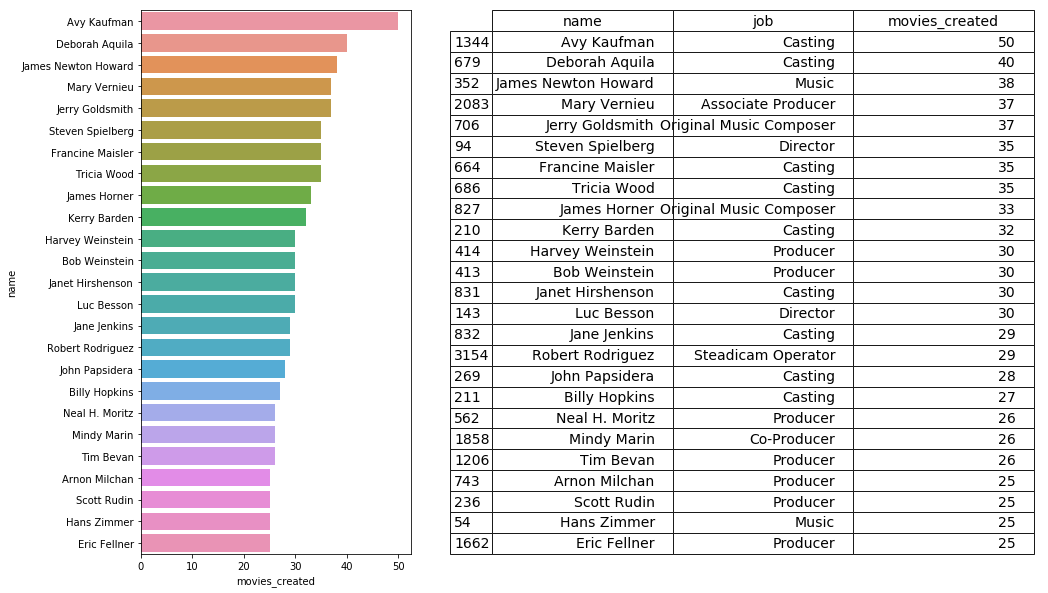

In [195]:
tmp = crew_df[['name','job','movies_created']].sort_values('movies_created', ascending=False).head(25)
tmp['job'] = tmp['job'].apply(lambda x: x[0])

fig, ax = plt.subplots(1,2, figsize=(16,10), gridspec_kw = {'width_ratios':[1, 2]})
sns.barplot(x='movies_created', y='name', data=tmp, ax=ax[0])

ax[1].axis('off')
table = ax[1].table(cellText=tmp.values, 
                  rowLabels=tmp.index, 
                  colLabels=tmp.columns, 
                  bbox=[0,0,1,1])
table.auto_set_font_size(False)
table.set_fontsize(14)

Avy Kaufman is the leader with 50 movies in which she was responsible for casting. 

Type of job shown in the table corresponds to the first value from the list of jobs that given person ever did. It some cases, position is not correspond to job that given person is most famous for, for example Robert Rodriguez - Steadicam Operator (director would be more appropriate).

**Which crew member works the longest in business?**

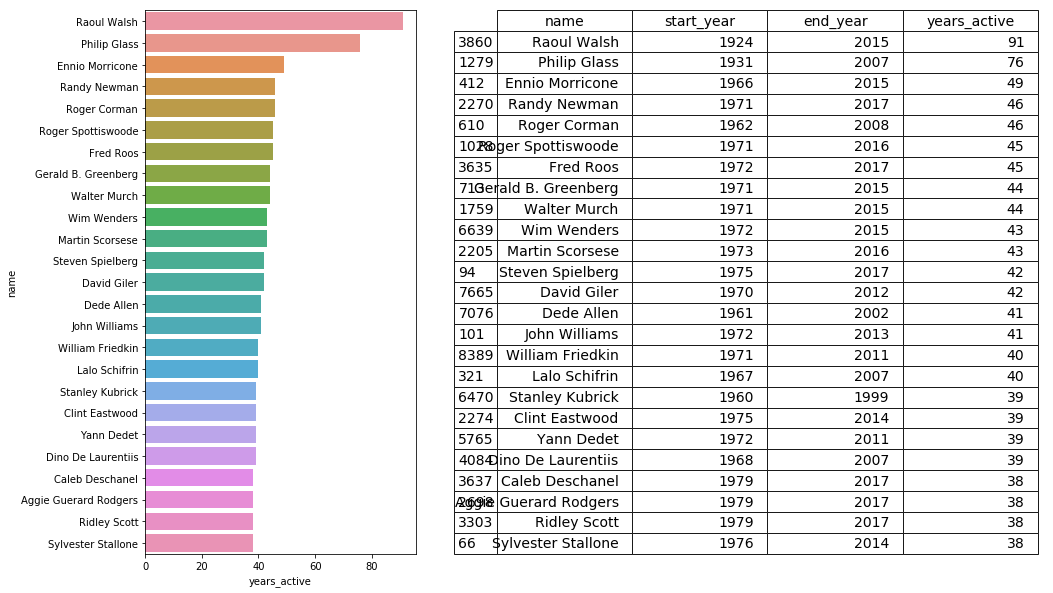

In [196]:
crew_df = crew_df.assign(years_active=lambda x: x['end_year'] - x['start_year'])

tmp = crew_df[['name','start_year','end_year','years_active']].sort_values(by='years_active', ascending=False).head(25)

fig, ax = plt.subplots(1,2, figsize=(16,10), gridspec_kw = {'width_ratios':[1, 2]})
sns.barplot(x='years_active', y='name', data=tmp, ax=ax[0])

ax[1].axis('off')
table = ax[1].table(cellText=tmp.values, 
                  rowLabels=tmp.index, 
                  colLabels=tmp.columns, 
                  bbox=[0,0,1,1])
table.auto_set_font_size(False)
table.set_fontsize(14)

First two names on the list are wrong. Raoul Walsh died in 1980 so he couldn't have work till 2015. In reality he worked 51 years as a director. Philip Glass was born in 1937 and started working as a composer in 1964 (he is still professionally active). So he shouldn't be able to start working in 1931. So proper leader should be Ennio Morricone  with 49 years of working as a composer.

On the list are three female crew members. The highest place among them belongs to Dede Allen with 41 years. She worked as an editor.

**Which crew member has the highest mean popularity of movies in which he/she worked?**

Excluding all crew that worked on less than 8 movies.

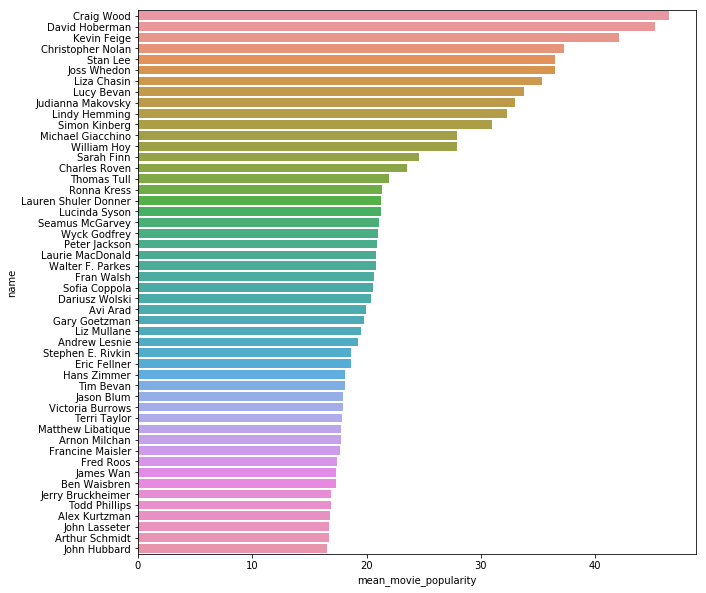

In [197]:
tmp = crew_df[crew_df['movies_created'] > 7].sort_values('mean_movie_popularity', ascending=False).head(50)

plt.figure(figsize=(10,10))
sns.barplot(x='mean_movie_popularity', y='name', data=tmp)

Top 5 names on the list:
 1. Craig Wood (editor) - Pirates of the Caribbean series, Guardians of the Galaxy movies.
 2. David Hoberman (producer) - Beauty and the Beast
 3. Kevin Feige (producer) - movies from Marvel Universe.
 4. Christopher Nolan (director) - no need to introduce.
 5. Stan Lee (screenplay by his comic books, producer) - no need to introduce.

Generally, most of them worked on blockbuster movies.

In [198]:
# Get the list of 'popular' crew members IDs
crew_popularity_ids = tmp['id'].values.tolist()

In [199]:
# Create new feature indicating if a movie was created by one of 'popular' crew members
train['has_popular_crew'] = train['crew'].apply(lambda x: is_person_in_cast(x, crew_popularity_ids))

**Which crew member worked on movies with the biggest revenue and the biggest budget?**

Excluding all crew members that worked on less than eight movies.

In [200]:
tmp = crew_df[crew_df['movies_created'] > 7].sort_values(by='mean_movie_revenue', ascending=False).head(50)

traces = []
for _, row in tmp.iterrows():
    traces.append(go.Scatter(
        x=[row['mean_movie_budget']],
        y=[row['mean_movie_revenue']],
        name=row['name'],
        mode='markers'
    ))

layout = go.Layout(
    title = go.layout.Title(text='Crew members based on mean movies revenue and budget'),
    xaxis = go.layout.XAxis(title=go.layout.xaxis.Title(text='Mean movie budget')), 
    yaxis = go.layout.YAxis(title=go.layout.yaxis.Title(text='Mean movie revenue'))
)

fig = go.Figure(data=traces, layout=layout)
iplot(fig, show_link=False)

Three out of five people with more than 600M revenue worked on The Lord of the Rings Trilogy:
 - Fran Walsh (screenplay) [wife of Peter Jackson]
 - Peter Jackson (director)
 - Liz Mullane (casting)
The other two: Joss Whedon and Kevin Feige worked together on Avengers and Avengers: Age of Ultron.

Just below 600M revenue there is Andrew Lesnie (Director Of Photography) that also worked on The Lord of the Rings Trilogy.

The biggest budget have movies that Craig Wood produced.

In [201]:
# Get IDs for top 100 crew members that have biggest mean movie revenue.
# Excluding all crew members that worked on less than eight movies.
crew_revenue_ids = crew_df[crew_df['movies_created'] > 7].sort_values(by='mean_movie_revenue', ascending=False).head(100)

In [202]:
# Create new feature indicating if a movie was created by one of crew members with biggest mean revenue
train['has_top_crew'] = train['crew'].apply(lambda x: is_person_in_cast(x, crew_revenue_ids))

**Which crew members worked on movies with the biggest profits?**

Excluding all crew members that worked on less then eight movies.

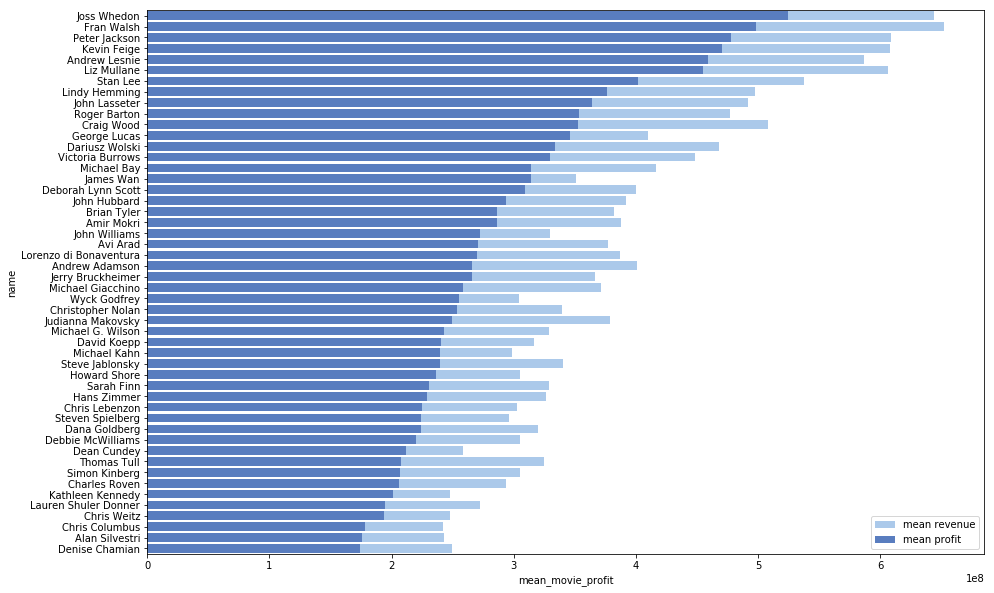

In [203]:
tmp = crew_df[crew_df['movies_created'] > 7].sort_values(by='mean_movie_profit', ascending=False).head(50)

plt.figure(figsize=(15,10))

sns.set_color_codes('pastel')
ax = sns.barplot(x='mean_movie_revenue', y='name', data=tmp, label='mean revenue', color='b')

sns.set_color_codes('muted')
ax = sns.barplot(x='mean_movie_profit', y='name', data=tmp, label='mean profit', color='b')

ax.legend(loc='lower right')

In most cases, these are the same people as before. Just in a slightly different order. Still LotR and Marvel in front.

**Who are the best crew member based on job type in case of movie revenue?**

Excluding all crew members that worked in less than eight movies.

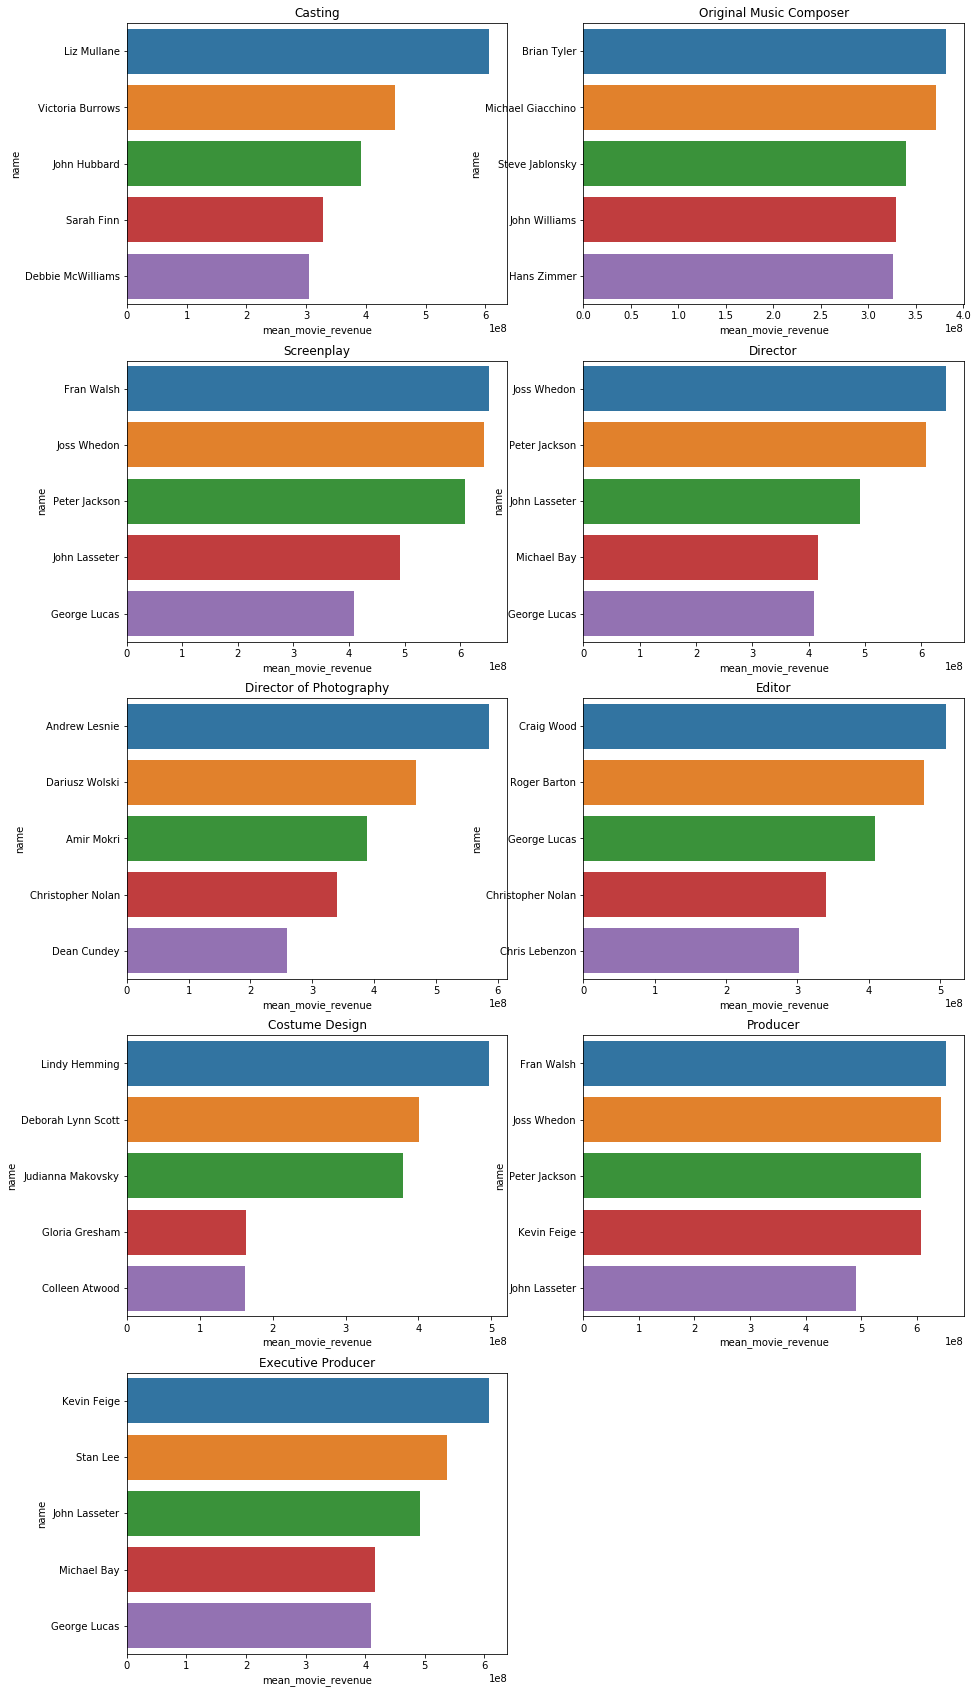

In [204]:
fig = plt.figure(figsize=(15,30))

for x, job in enumerate(selected_jobs):
    tmp = (crew_df[(crew_df['job'].apply(lambda x: job in x)) & (crew_df['movies_created'] > 7)]
           .sort_values('mean_movie_revenue', ascending=False).head(5))

    ax = fig.add_subplot(5,2,x+1)
    sns.barplot(x='mean_movie_revenue', y='name', data=tmp, ax=ax)
    ax.set_title(job)

In all cases, top places belongs to people that worked on movies based on comics (one DC, rest Marvel) or on The Lord of the Rings trilogy.

Original Music Composer and Producer are aligned categories. There are no big differences between the leaders. Casting, Director of Photography and Costume Design have clear leader.

**Who are the best crew member from directors in case of movie revenue?**

Excluding all crew members that worked in less than eight movies.

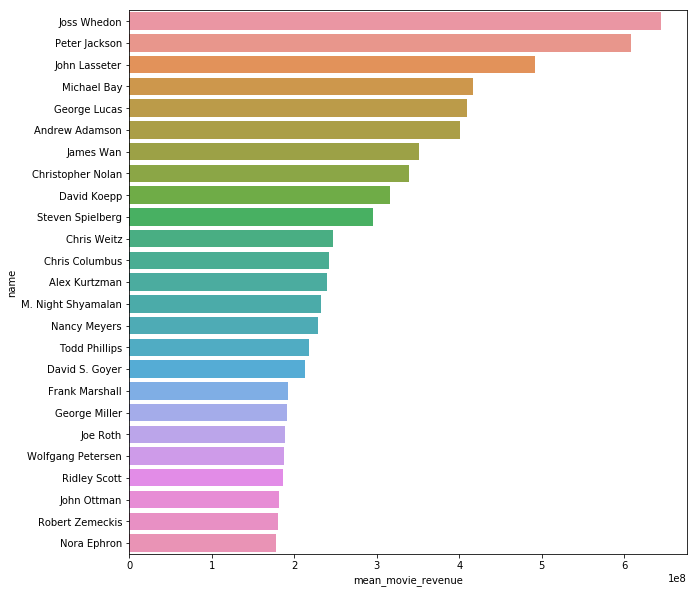

In [205]:
tmp = (crew_df[(crew_df['job'].apply(lambda x: 'Director' in x)) & (crew_df['movies_created'] > 7)]
       .sort_values('mean_movie_revenue', ascending=False).head(25))

plt.figure(figsize=(10,10))
sns.barplot(x='mean_movie_revenue', y='name', data=tmp)

Top 5 places:
 1. Joss Whedon - Avengers
 2. Peter Jackson - The Lord of the Rings trilogy, Hobbit movies
 3. John Lasseter - Toy Story series
 4. Michael Bay - Transformers collection
 5. George Lucas - Star Wars movies, Indiana Jones

**Who are the best crew member from casting in case of movie revenue?**

Excluding all crew members that worked on less than eight movies.

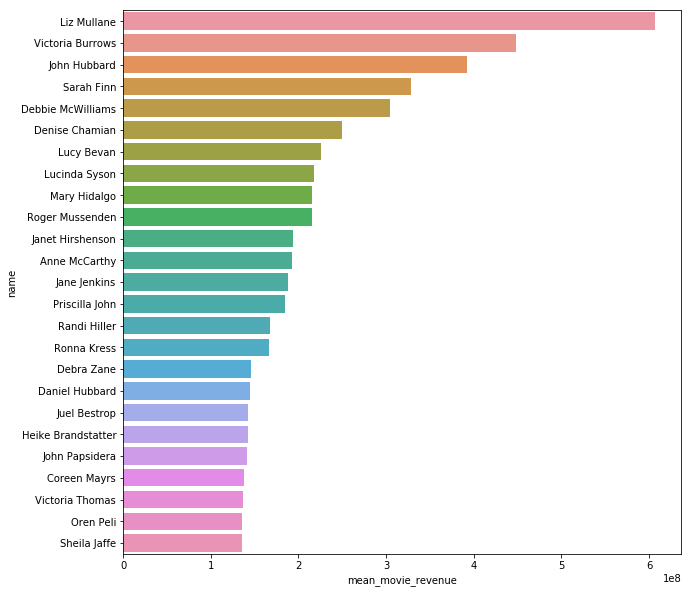

In [206]:
tmp = (crew_df[(crew_df['job'].apply(lambda x: 'Casting' in x)) & (crew_df['movies_created'] > 7)]
       .sort_values('mean_movie_revenue', ascending=False).head(25))

plt.figure(figsize=(10,10))
sns.barplot(x='mean_movie_revenue', y='name', data=tmp)

Top 3 places belongs to The Lord of the Rings.

**Who are the best crew member from directors of photography in case of movie revenue?**

Excluding all crew members that worked in less than eight movies.

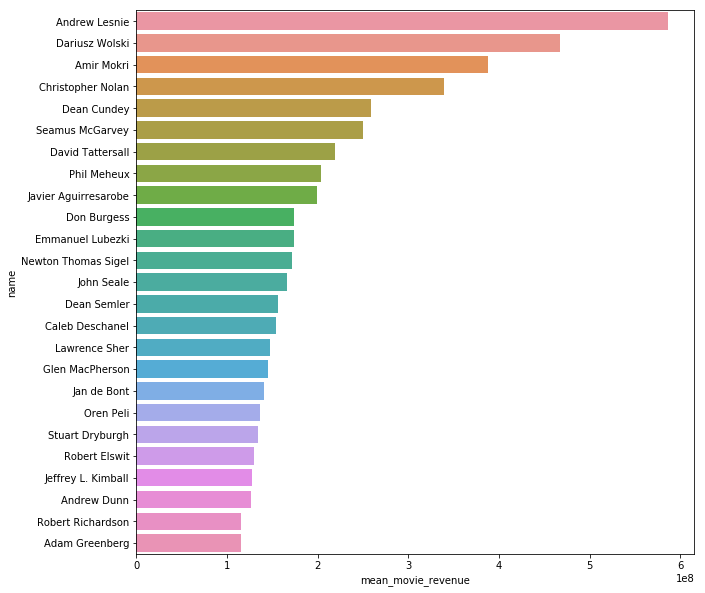

In [207]:
tmp = (crew_df[(crew_df['job'].apply(lambda x: 'Director of Photography' in x)) & (crew_df['movies_created'] > 7)]
       .sort_values('mean_movie_revenue', ascending=False).head(25))

plt.figure(figsize=(10,10))
sns.barplot(x='mean_movie_revenue', y='name', data=tmp)

Top 3 places:
 1. Andrew Lesine - The Lord of the Rings
 2. Dariusz Wolski - Pirates of the Caribbean
 3. Amir Mokri - Man of Steel, Transformers 3, Trnasformers: Age of Extinction

**Who are the best crew member from costume design in case of movie revenue?**

Excluding all crew members that worked in less than eight movies.

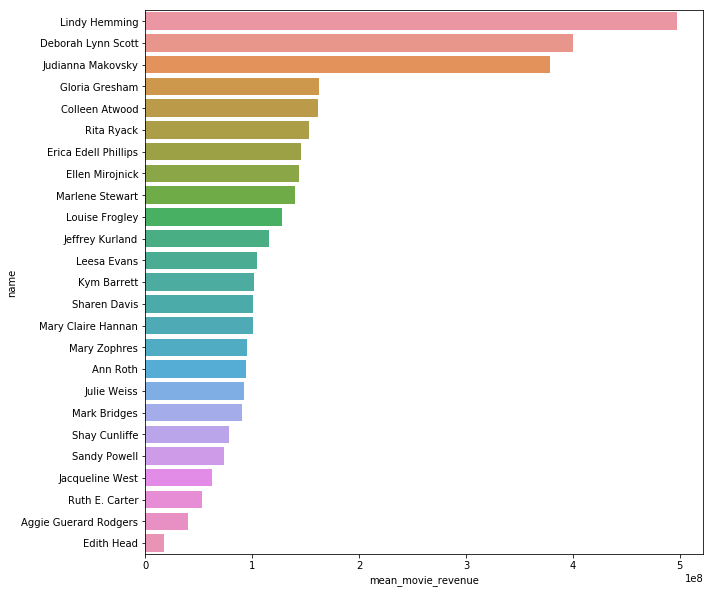

In [208]:
tmp = (crew_df[(crew_df['job'].apply(lambda x: 'Costume Design' in x)) & (crew_df['movies_created'] > 7)]
       .sort_values('mean_movie_revenue', ascending=False).head(25))

plt.figure(figsize=(10,10))
sns.barplot(x='mean_movie_revenue', y='name', data=tmp)

There are three very clear leaders in this job with huge advantage over the rest costume designers.
 1. Lindy Hemming - Wonder Woman, The Dark Knight Trilogy
 2. Deborah Lynn Scott - Titanic, Avatar, Transformers
 3. Judianna Makovsky - latest Marvel movies

In [209]:
# Get person name of job role for the movie
def get_crew_role_name(crew, job):
    for person in crew:
        if person['job'] == job:
            return pd.Series(data=[person['name']], index=[job])
    return pd.Series(data=[''], index=[job])

In [210]:
# Create new feature for director
train['director'] = train['crew'].apply(lambda x: get_crew_role_name(x,'Director'))

**Which director have the biggest mean movie revenue?**

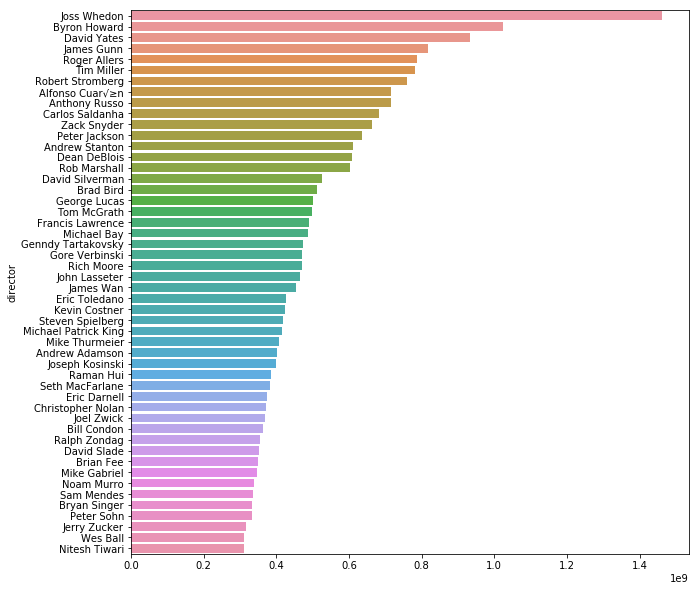

In [211]:
directors = train.groupby('director')['revenue'].mean().sort_values(ascending=False).head(50)

plt.figure(figsize=(10, 10))
sns.barplot(x=directors.values, y=directors.index)

Double check. Directors that are in this list are different from the earlier list. This is the case because in earlier list I show all 'directors' that worked on more than seven movies and what is also important I classify them as directors no matter how many movies they directed.

Top 5:
 1. Joss Whedon (Avengers)
 2. Byron Howard (Zootopia, Tangled, Bolt)
 3. David Yates (Harry Potter)
 4. James Gunn (Guardians of the Galaxy)
 5. Roger Allers (The Lion King)

In general, the movie's revenue depends on the choice of the person responsible for directing. Directors that are popular, that created movies that viewer seen, have bigger chance for bigger movie revenue in future.

In [212]:
# Remove crew dataframe from memory
del crew_df

## The End

Just kidding. It is the end of EDA, I think. In the future I will try to engineer some new features and try to predict box office revenue.

See you soon.

**References**:
 - [medium.com/@nagalr_63588/tmdb-box-office-prediction-kaggle-com-6e14e013955b](https://medium.com/@nagalr_63588/tmdb-box-office-prediction-kaggle-com-6e14e013955b)
 - [kaggle.com/artgor/eda-feature-engineering-and-model-interpretation](https://www.kaggle.com/artgor/eda-feature-engineering-and-model-interpretation)